In [2]:
import os 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import numpy as np
import gym
import warnings
import matplotlib.pyplot as plt
from agent import *
from memory import *
from torch.distributions.categorical import Categorical
warnings.simplefilter("ignore")


In [47]:
class PPOMemory():
    """
    Memory for PPO
    """
    def  __init__(self, batch_size):
        self.states = []
        self.actions= []
        self.action_probs = []
        self.rewards = []
        self.vals = []
        self.dones = []
        
        self.batch_size = batch_size

    def generate_batches(self):
        ## suppose n_states=20 and batch_size = 4
        n_states = len(self.states)
        ##n_states should be always greater than batch_size
        ## batch_start is the starting index of every batch
        ## eg:   array([ 0,  4,  8, 12, 16]))
        batch_start = np.arange(0, n_states, self.batch_size) 
        ## random shuffling if indexes
        # eg: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
        indices = np.arange(n_states, dtype=np.int64)
        ## eg: array([12, 17,  6,  7, 10, 11, 15, 13, 18,  9,  8,  4,  3,  0,  2,  5, 14,19,  1, 16])
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]
        ## eg: [array([12, 17,  6,  7]),array([10, 11, 15, 13]),array([18,  9,  8,  4]),array([3, 0, 2, 5]),array([14, 19,  1, 16])]
        return np.array(self.states),np.array(self.actions),\
               np.array(self.action_probs),np.array(self.vals),np.array(self.rewards),\
               np.array(self.dones),batches
    
       
    

    def store_memory(self,state,action,action_prob,val,reward,done):
        self.states.append(state)
        self.actions.append(action)
        self.action_probs.append(action_prob)
        self.rewards.append(reward)
        self.vals.append(val)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.actions= []
        self.action_probs = []
        self.rewards = []
        self.vals = []
        self.dones = []




In [48]:
## initialize actor network and critic network


class ActorNwk(nn.Module):
    def __init__(self,input_dim,out_dim,
                 adam_lr,
                 chekpoint_file,
                 hidden1_dim=256,
                 hidden2_dim=256
                 ):
        super(ActorNwk, self).__init__()

        self.actor_nwk = nn.Sequential(
            nn.Linear(*input_dim,hidden1_dim),
            nn.ReLU(),
            nn.Linear(hidden1_dim,hidden2_dim),
            nn.ReLU(),
            nn.Linear(hidden2_dim,out_dim),  
            nn.Softmax(dim=-1)
        )

        self.checkpoint_file = chekpoint_file
        self.optimizer = torch.optim.Adam(params=self.actor_nwk.parameters(),lr=adam_lr)

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    
    def forward(self,state):
        out = self.actor_nwk(state)
        dist = Categorical(out)
        return dist

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))



class CriticNwk(nn.Module):
    def __init__(self,input_dim,
                 adam_lr,
                 chekpoint_file,
                 hidden1_dim=256,
                 hidden2_dim=256
                 ):
        super(CriticNwk, self).__init__()

        self.critic_nwk = nn.Sequential(
            nn.Linear(*input_dim,hidden1_dim),
            nn.ReLU(),
            nn.Linear(hidden1_dim,hidden2_dim),
            nn.ReLU(),
            nn.Linear(hidden2_dim,1),  
   
        )

        self.checkpoint_file = chekpoint_file
        self.optimizer = torch.optim.Adam(params=self.critic_nwk.parameters(),lr=adam_lr)

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    
    def forward(self,state):
        out = self.critic_nwk(state)
        return out

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))




In [49]:
## agent

class Agent():
    def __init__(self, gamma, policy_clip,lamda, adam_lr,
                 n_epochs, batch_size, state_dim, action_dim):
        
        self.gamma = gamma 
        self.policy_clip = policy_clip
        self.lamda  = lamda
        self.n_epochs = n_epochs

        self.actor = ActorNwk(input_dim=state_dim,out_dim=action_dim,adam_lr=adam_lr,chekpoint_file='tmp/actor')
        self.critic = CriticNwk(input_dim=state_dim,adam_lr=adam_lr,chekpoint_file='tmp/ctitic')
        self.memory = PPOMemory(batch_size)

    def store_data(self,state,action,action_prob,val,reward,done):
        self.memory.store_memory(state,action,action_prob,val,reward,done)
       

    def save_models(self):
        print('... Saving Models ......')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()
    
    def load_models(self):
        print('... Loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.actor.device)

        dist = self.actor(state)
        ## sample the output action from a categorical distribution of predicted actions
        action = dist.sample()
        probs = torch.squeeze(dist.log_prob(action)).item()
        action = torch.squeeze(action).item()

        ## value from critic model
        value = self.critic(state)
        value = torch.squeeze(value).item()

        return action, probs, value
    
    def calculate_advanatage(self,reward_arr,value_arr,dones_arr):
        time_steps = len(reward_arr)
        advantage = np.zeros(len(reward_arr), dtype=np.float32)

        for t in range(0,time_steps-1):
            discount = 1
            running_advantage = 0
            for k in range(t,time_steps-1):
                if int(dones_arr[k]) == 1:
                    running_advantage += reward_arr[k] - value_arr[k]
                else:
                
                    running_advantage += reward_arr[k] + (self.gamma*value_arr[k+1]) - value_arr[k]

                running_advantage = discount * running_advantage
                # running_advantage += discount*(reward_arr[k] + self.gamma*value_arr[k+1]*(1-int(dones_arr[k])) - value_arr[k])
                discount *= self.gamma * self.lamda
            
            advantage[t] = running_advantage
        advantage = torch.tensor(advantage).to(self.actor.device)
        return advantage
    
    def learn(self):
        for _ in range(self.n_epochs):

            ## initially all will be empty arrays
            state_arr, action_arr, old_prob_arr, value_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()
            
            advantage_arr = self.calculate_advanatage(reward_arr,value_arr,dones_arr)
            values = torch.tensor(value_arr).to(self.actor.device)

            for batch in batches:
                states = torch.tensor(state_arr[batch], dtype=torch.float).to(self.actor.device)
                old_probs = torch.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = torch.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = torch.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage_arr[batch] * prob_ratio
                weighted_clipped_probs = torch.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage_arr[batch]
                actor_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage_arr[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()   




... Saving Models ......
episode 0 score 15.0 avg score 15.0 time_steps 15 learning_steps 0
episode 1 score 12.0 avg score 13.5 time_steps 27 learning_steps 1
episode 2 score 15.0 avg score 14.0 time_steps 42 learning_steps 2


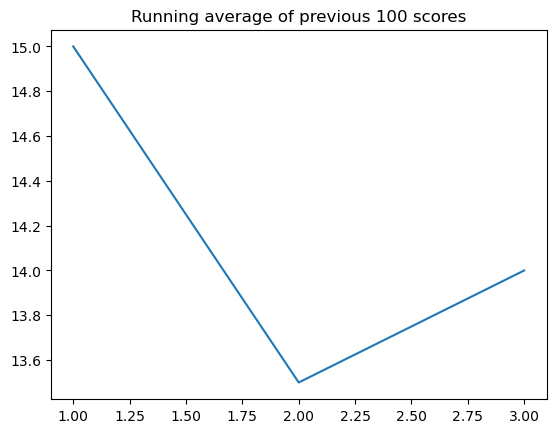

In [4]:




def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)


### directory for saving models ###
if not os.path.exists('tmp'):
    os.makedirs('tmp')


env = gym.make('CartPole-v0')
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.0003
agent = Agent(state_dim=env.observation_space.shape,
              action_dim=env.action_space.n, 
              batch_size=batch_size,
              n_epochs=n_epochs,
              policy_clip=0.2,
              gamma=0.99,lamda=0.95, 
              adam_lr=alpha)
n_games = 300
figure_file = 'cartpole.png'
best_score = env.reward_range[0]
score_history = []
learn_iters = 0
avg_score = 0
n_steps = 0
for i in range(n_games):
    current_state,info = env.reset()
    terminated,truncated = False,False
    done = False
    score = 0
    while not done:
        action, prob, val = agent.choose_action(current_state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = 1 if (terminated or truncated) else 0
        n_steps += 1
        score += reward
        agent.store_data(current_state, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        current_state = next_state
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()
    print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
            'time_steps', n_steps, 'learning_steps', learn_iters)
    
    
x = [i+1 for i in range(len(score_history))]
plot_learning_curve(x, score_history, figure_file)



[ 0.01352168  0.03549898  0.00586398 -0.00455676] [ 0.01423166  0.23053636  0.00577284 -0.29538378] 1
New state:  [ 0.01423166  0.23053636  0.00577284 -0.29538378] Reward:  1.0 Terminated:  False Truncated:  False


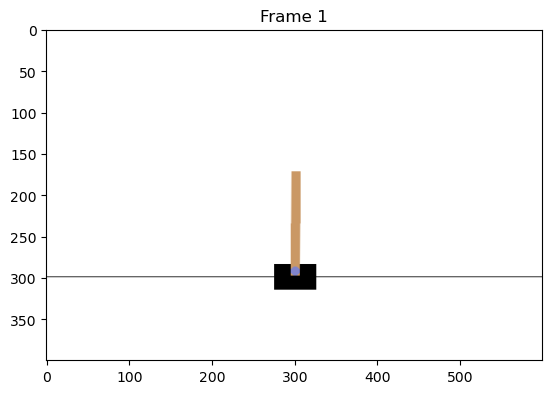

[ 0.01423166  0.23053636  0.00577284 -0.29538378] [ 0.01884239  0.03533258 -0.00013483 -0.00088579] 0
New state:  [ 0.01884239  0.03533258 -0.00013483 -0.00088579] Reward:  1.0 Terminated:  False Truncated:  False


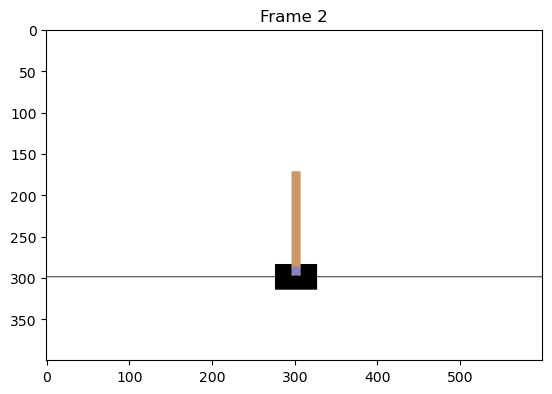

[ 0.01884239  0.03533258 -0.00013483 -0.00088579] [ 1.9549040e-02  2.3045646e-01 -1.5255052e-04 -2.9361126e-01] 1
New state:  [ 1.9549040e-02  2.3045646e-01 -1.5255052e-04 -2.9361126e-01] Reward:  1.0 Terminated:  False Truncated:  False


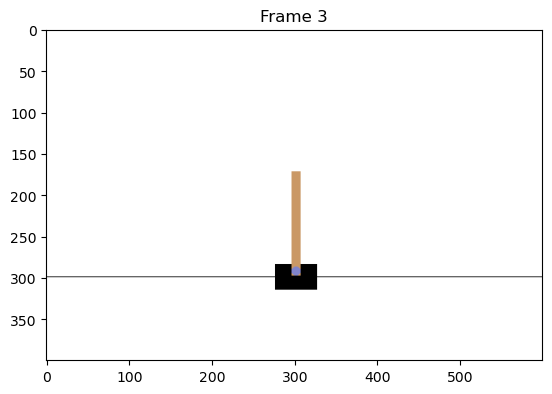

[ 1.9549040e-02  2.3045646e-01 -1.5255052e-04 -2.9361126e-01] [ 0.02415817  0.03533668 -0.00602478 -0.00097645] 0
New state:  [ 0.02415817  0.03533668 -0.00602478 -0.00097645] Reward:  1.0 Terminated:  False Truncated:  False


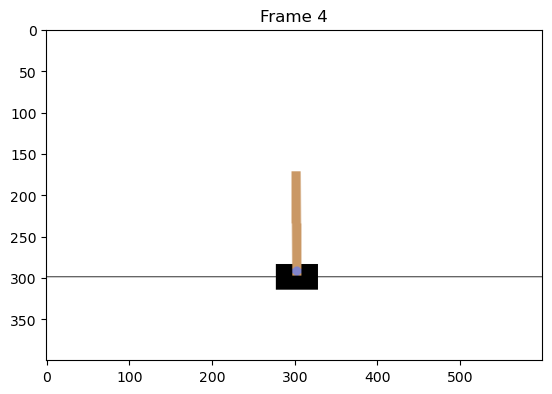

[ 0.02415817  0.03533668 -0.00602478 -0.00097645] [ 0.0248649   0.23054452 -0.0060443  -0.29555416] 1
New state:  [ 0.0248649   0.23054452 -0.0060443  -0.29555416] Reward:  1.0 Terminated:  False Truncated:  False


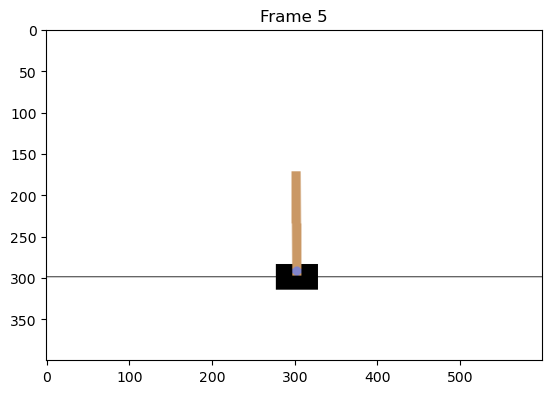

[ 0.0248649   0.23054452 -0.0060443  -0.29555416] [ 0.02947579  0.03550926 -0.01195539 -0.00478362] 0
New state:  [ 0.02947579  0.03550926 -0.01195539 -0.00478362] Reward:  1.0 Terminated:  False Truncated:  False


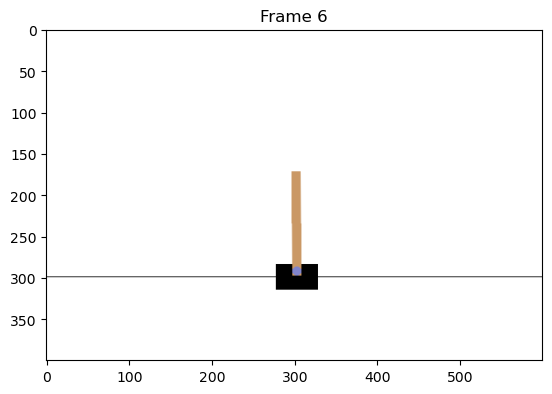

[ 0.02947579  0.03550926 -0.01195539 -0.00478362] [ 0.03018598  0.23080061 -0.01205106 -0.30121452] 1
New state:  [ 0.03018598  0.23080061 -0.01205106 -0.30121452] Reward:  1.0 Terminated:  False Truncated:  False


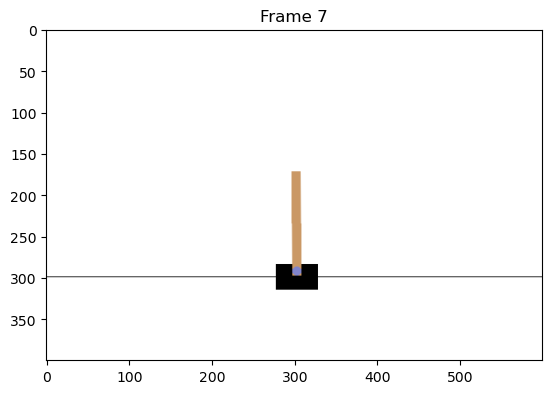

[ 0.03018598  0.23080061 -0.01205106 -0.30121452] [ 0.03480199  0.03585247 -0.01807535 -0.01235647] 0
New state:  [ 0.03480199  0.03585247 -0.01807535 -0.01235647] Reward:  1.0 Terminated:  False Truncated:  False


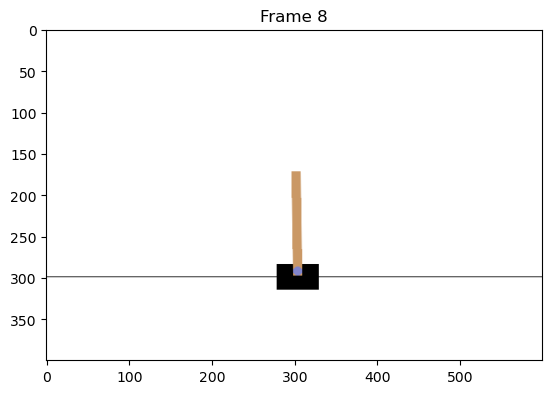

[ 0.03480199  0.03585247 -0.01807535 -0.01235647] [ 0.03551904  0.23122892 -0.01832248 -0.31068712] 1
New state:  [ 0.03551904  0.23122892 -0.01832248 -0.31068712] Reward:  1.0 Terminated:  False Truncated:  False


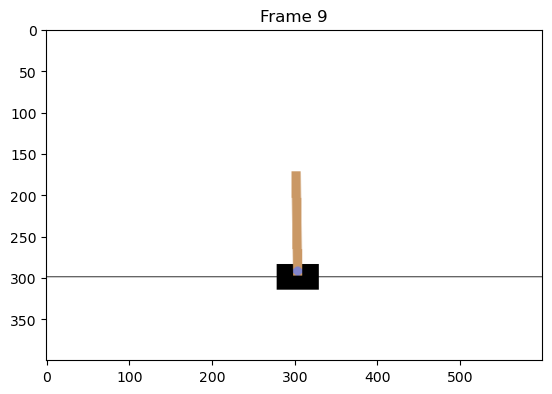

[ 0.03551904  0.23122892 -0.01832248 -0.31068712] [ 0.04014362  0.03637274 -0.02453622 -0.02383844] 0
New state:  [ 0.04014362  0.03637274 -0.02453622 -0.02383844] Reward:  1.0 Terminated:  False Truncated:  False


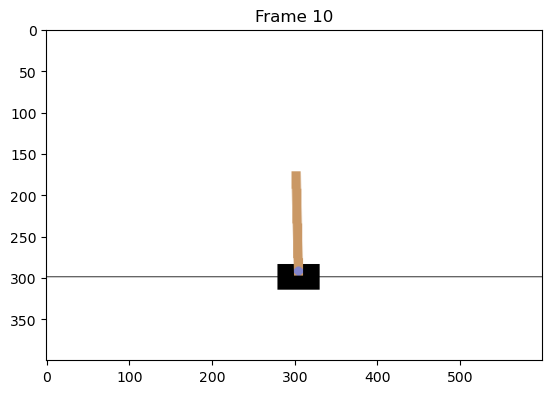

[ 0.04014362  0.03637274 -0.02453622 -0.02383844] [ 0.04087107  0.23183782 -0.02501299 -0.32416072] 1
New state:  [ 0.04087107  0.23183782 -0.02501299 -0.32416072] Reward:  1.0 Terminated:  False Truncated:  False


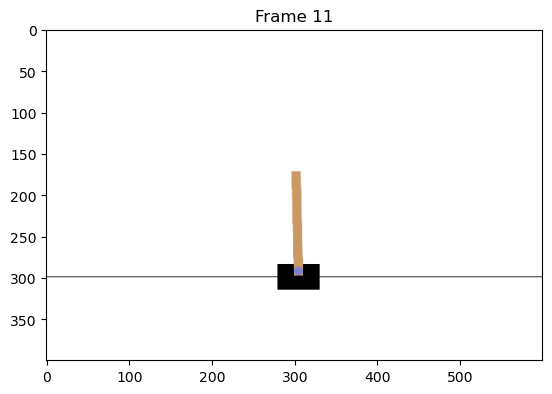

[ 0.04087107  0.23183782 -0.02501299 -0.32416072] [ 0.04550783  0.03708079 -0.0314962  -0.03946962] 0
New state:  [ 0.04550783  0.03708079 -0.0314962  -0.03946962] Reward:  1.0 Terminated:  False Truncated:  False


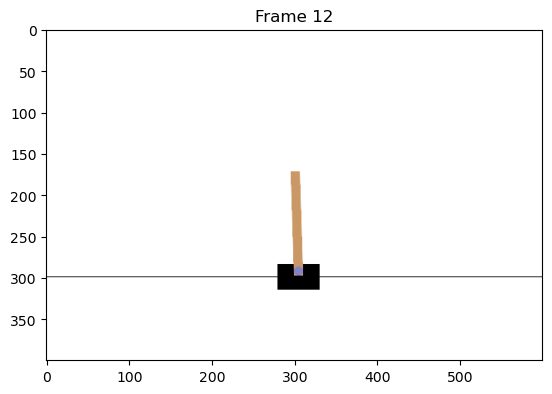

[ 0.04550783  0.03708079 -0.0314962  -0.03946962] [ 0.04624945  0.23263991 -0.0322856  -0.34192115] 1
New state:  [ 0.04624945  0.23263991 -0.0322856  -0.34192115] Reward:  1.0 Terminated:  False Truncated:  False


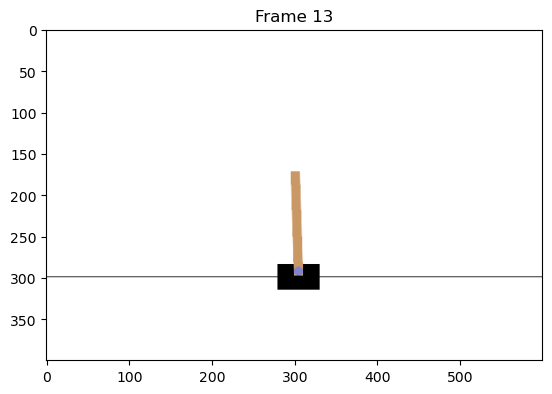

[ 0.04624945  0.23263991 -0.0322856  -0.34192115] [ 0.05090224  0.03799181 -0.03912402 -0.05959149] 0
New state:  [ 0.05090224  0.03799181 -0.03912402 -0.05959149] Reward:  1.0 Terminated:  False Truncated:  False


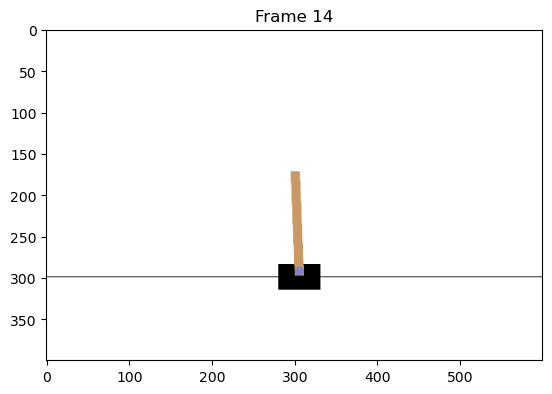

[ 0.05090224  0.03799181 -0.03912402 -0.05959149] [ 0.05166208  0.23365225 -0.04031585 -0.36435708] 1
New state:  [ 0.05166208  0.23365225 -0.04031585 -0.36435708] Reward:  1.0 Terminated:  False Truncated:  False


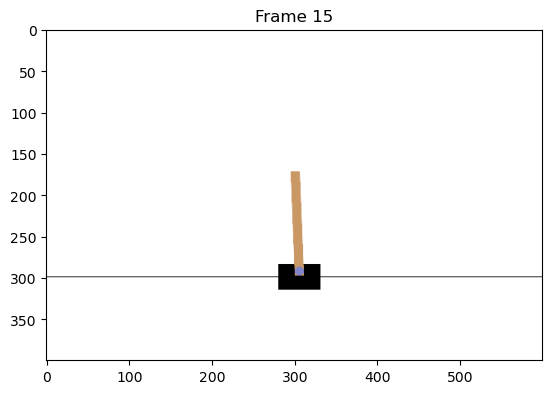

[ 0.05166208  0.23365225 -0.04031585 -0.36435708] [ 0.05633513  0.03912576 -0.04760299 -0.08465411] 0
New state:  [ 0.05633513  0.03912576 -0.04760299 -0.08465411] Reward:  1.0 Terminated:  False Truncated:  False


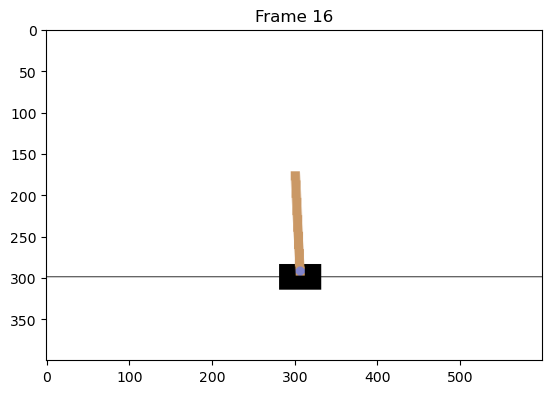

[ 0.05633513  0.03912576 -0.04760299 -0.08465411] [ 0.05711764 -0.15528265 -0.04929608  0.19263817] 0
New state:  [ 0.05711764 -0.15528265 -0.04929608  0.19263817] Reward:  1.0 Terminated:  False Truncated:  False


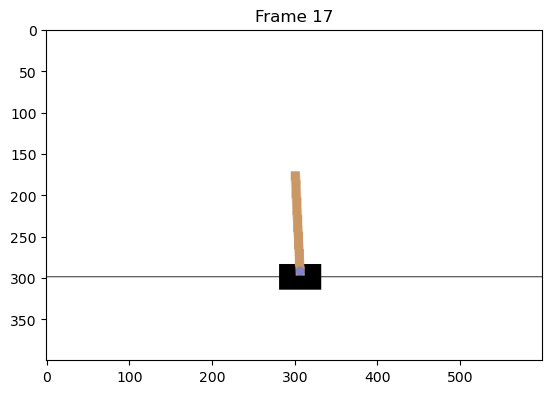

[ 0.05711764 -0.15528265 -0.04929608  0.19263817] [ 0.05401199  0.04050857 -0.04544331 -0.11517905] 1
New state:  [ 0.05401199  0.04050857 -0.04544331 -0.11517905] Reward:  1.0 Terminated:  False Truncated:  False


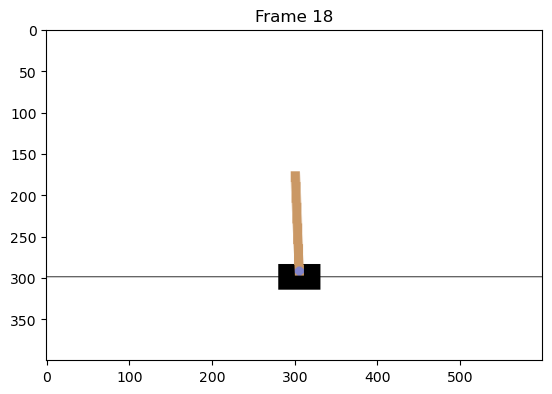

[ 0.05401199  0.04050857 -0.04544331 -0.11517905] [ 0.05482216 -0.15393378 -0.04774689  0.16282763] 0
New state:  [ 0.05482216 -0.15393378 -0.04774689  0.16282763] Reward:  1.0 Terminated:  False Truncated:  False


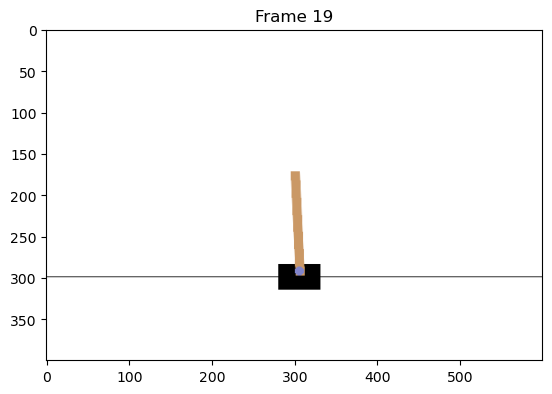

[ 0.05482216 -0.15393378 -0.04774689  0.16282763] [ 0.05174349  0.04183802 -0.04449034 -0.14452766] 1
New state:  [ 0.05174349  0.04183802 -0.04449034 -0.14452766] Reward:  1.0 Terminated:  False Truncated:  False


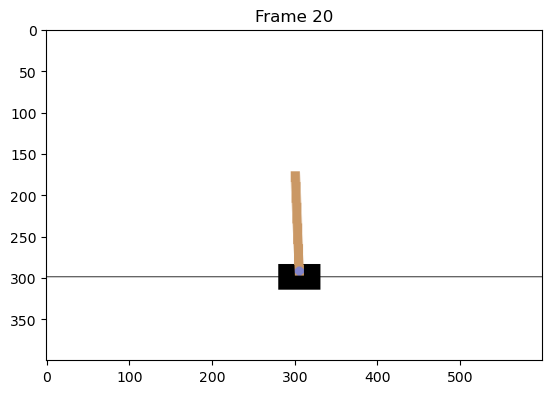

[ 0.05174349  0.04183802 -0.04449034 -0.14452766] [ 0.05258024 -0.15261948 -0.04738089  0.13379411] 0
New state:  [ 0.05258024 -0.15261948 -0.04738089  0.13379411] Reward:  1.0 Terminated:  False Truncated:  False


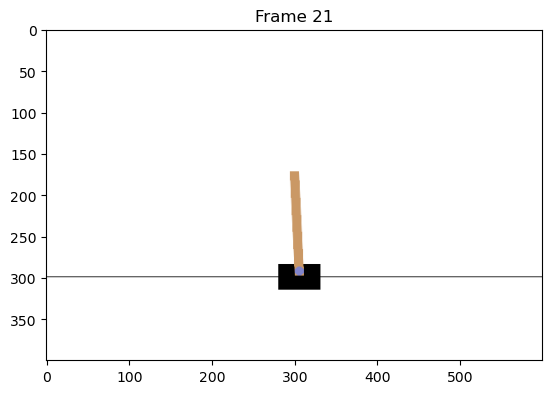

[ 0.05258024 -0.15261948 -0.04738089  0.13379411] [ 0.04952785  0.04314801 -0.04470501 -0.17345233] 1
New state:  [ 0.04952785  0.04314801 -0.04470501 -0.17345233] Reward:  1.0 Terminated:  False Truncated:  False


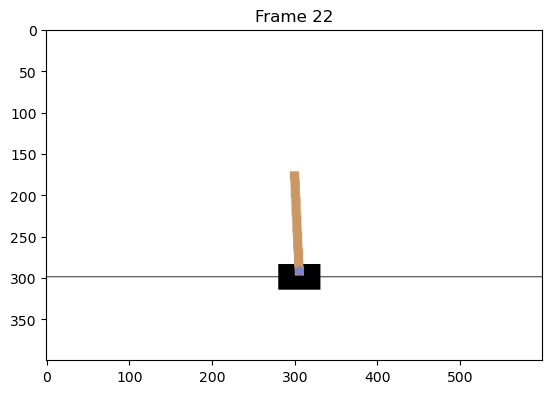

[ 0.04952785  0.04314801 -0.04470501 -0.17345233] [ 0.05039081 -0.15130655 -0.04817406  0.1047992 ] 0
New state:  [ 0.05039081 -0.15130655 -0.04817406  0.1047992 ] Reward:  1.0 Terminated:  False Truncated:  False


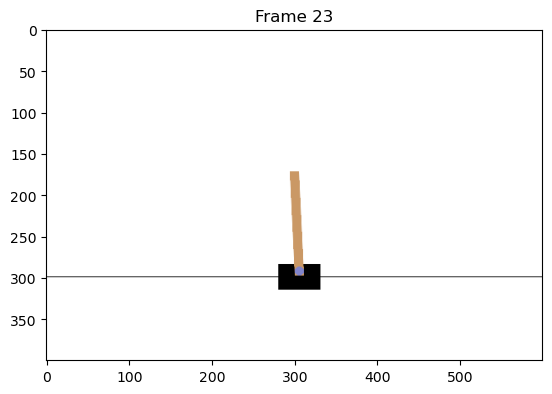

[ 0.05039081 -0.15130655 -0.04817406  0.1047992 ] [ 0.04736468  0.04447148 -0.04607807 -0.20268485] 1
New state:  [ 0.04736468  0.04447148 -0.04607807 -0.20268485] Reward:  1.0 Terminated:  False Truncated:  False


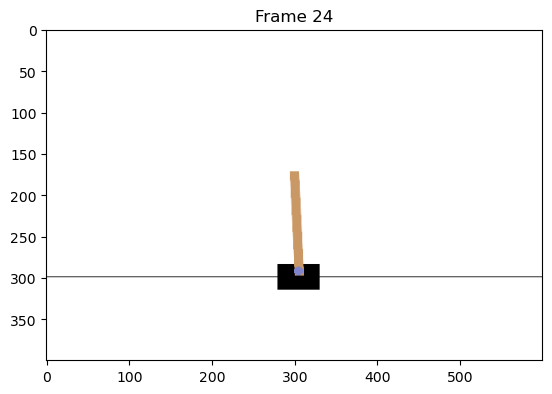

[ 0.04736468  0.04447148 -0.04607807 -0.20268485] [ 0.04825411 -0.14996225 -0.05013177  0.075114  ] 0
New state:  [ 0.04825411 -0.14996225 -0.05013177  0.075114  ] Reward:  1.0 Terminated:  False Truncated:  False


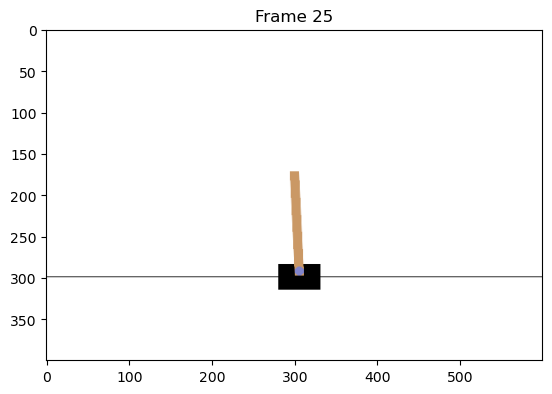

[ 0.04825411 -0.14996225 -0.05013177  0.075114  ] [ 0.04525487  0.04584122 -0.04862949 -0.23295476] 1
New state:  [ 0.04525487  0.04584122 -0.04862949 -0.23295476] Reward:  1.0 Terminated:  False Truncated:  False


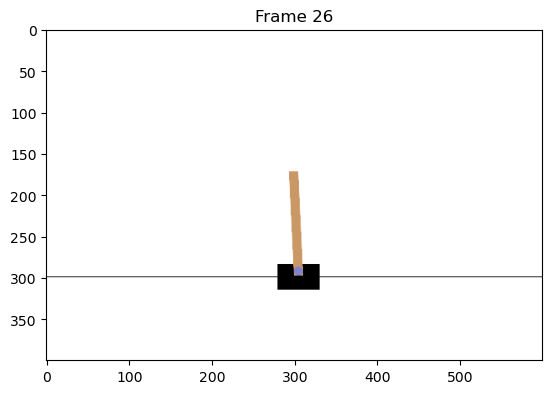

[ 0.04525487  0.04584122 -0.04862949 -0.23295476] [ 0.04617169 -0.14855337 -0.05328859  0.04400099] 0
New state:  [ 0.04617169 -0.14855337 -0.05328859  0.04400099] Reward:  1.0 Terminated:  False Truncated:  False


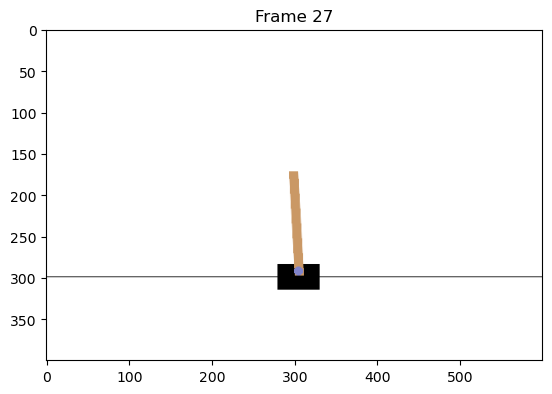

[ 0.04617169 -0.14855337 -0.05328859  0.04400099] [ 0.04320062  0.04729061 -0.05240856 -0.26500744] 1
New state:  [ 0.04320062  0.04729061 -0.05240856 -0.26500744] Reward:  1.0 Terminated:  False Truncated:  False


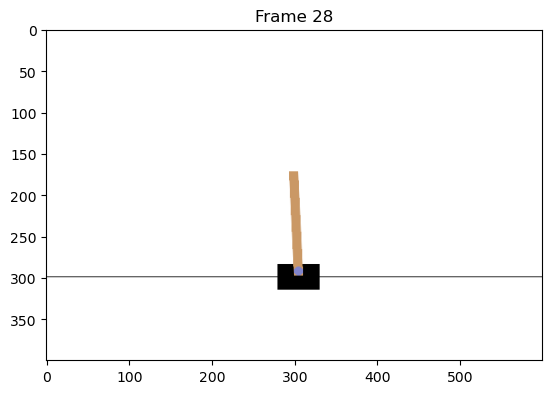

[ 0.04320062  0.04729061 -0.05240856 -0.26500744] [ 0.04414644 -0.14704567 -0.05770871  0.01069569] 0
New state:  [ 0.04414644 -0.14704567 -0.05770871  0.01069569] Reward:  1.0 Terminated:  False Truncated:  False


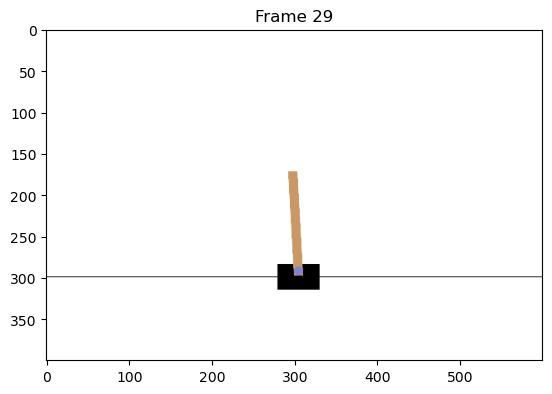

[ 0.04414644 -0.14704567 -0.05770871  0.01069569] [ 0.04120553 -0.34129456 -0.0574948   0.28462702] 0
New state:  [ 0.04120553 -0.34129456 -0.0574948   0.28462702] Reward:  1.0 Terminated:  False Truncated:  False


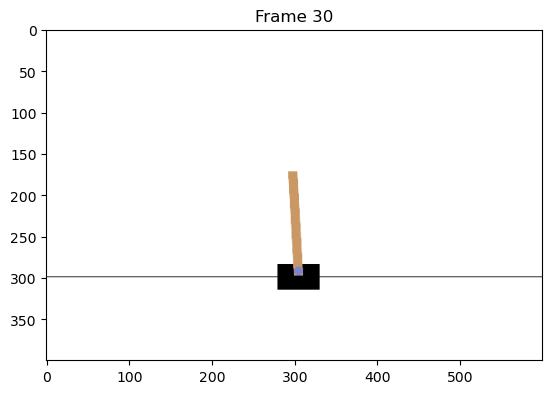

[ 0.04120553 -0.34129456 -0.0574948   0.28462702] [ 0.03437963 -0.14540173 -0.05180226 -0.02562084] 1
New state:  [ 0.03437963 -0.14540173 -0.05180226 -0.02562084] Reward:  1.0 Terminated:  False Truncated:  False


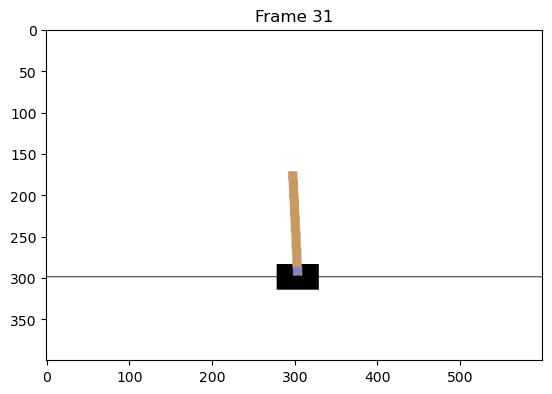

[ 0.03437963 -0.14540173 -0.05180226 -0.02562084] [ 0.0314716  -0.339744   -0.05231468  0.25027847] 0
New state:  [ 0.0314716  -0.339744   -0.05231468  0.25027847] Reward:  1.0 Terminated:  False Truncated:  False


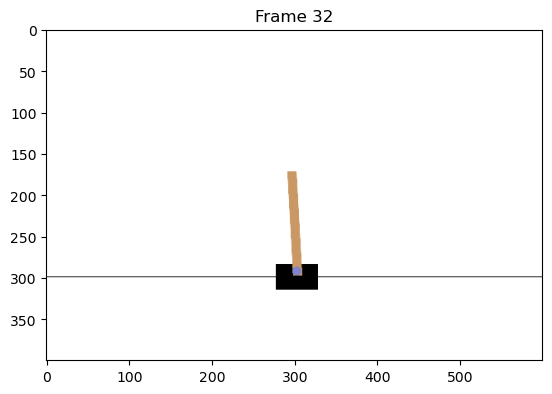

[ 0.0314716  -0.339744   -0.05231468  0.25027847] [ 0.02467672 -0.14391552 -0.04730911 -0.05843589] 1
New state:  [ 0.02467672 -0.14391552 -0.04730911 -0.05843589] Reward:  1.0 Terminated:  False Truncated:  False


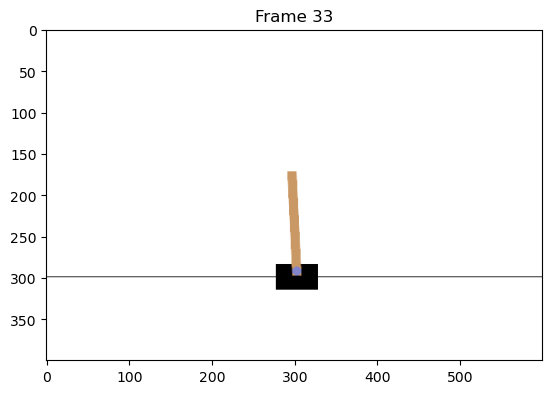

[ 0.02467672 -0.14391552 -0.04730911 -0.05843589] [ 0.02179841 -0.33832833 -0.04847782  0.21895337] 0
New state:  [ 0.02179841 -0.33832833 -0.04847782  0.21895337] Reward:  1.0 Terminated:  False Truncated:  False


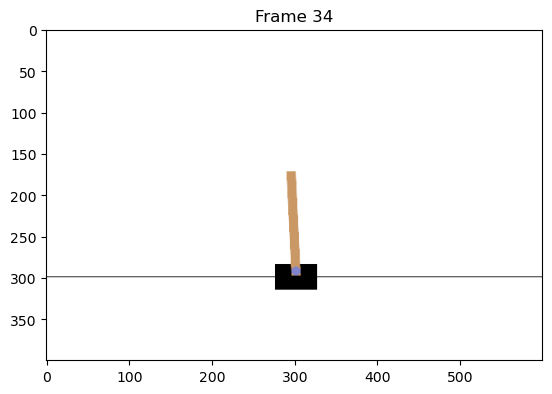

[ 0.02179841 -0.33832833 -0.04847782  0.21895337] [ 0.01503184 -0.14254814 -0.04409876 -0.08861881] 1
New state:  [ 0.01503184 -0.14254814 -0.04409876 -0.08861881] Reward:  1.0 Terminated:  False Truncated:  False


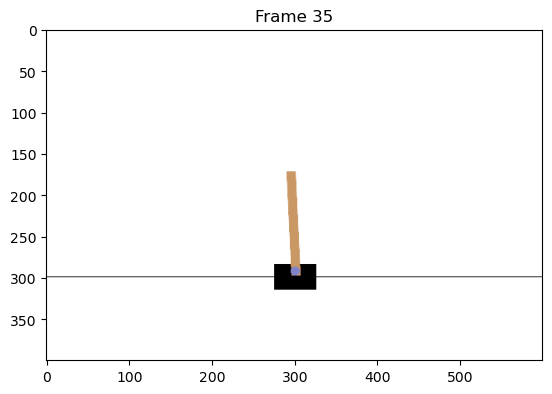

[ 0.01503184 -0.14254814 -0.04409876 -0.08861881] [ 0.01218088 -0.33701116 -0.04587113  0.1898313 ] 0
New state:  [ 0.01218088 -0.33701116 -0.04587113  0.1898313 ] Reward:  1.0 Terminated:  False Truncated:  False


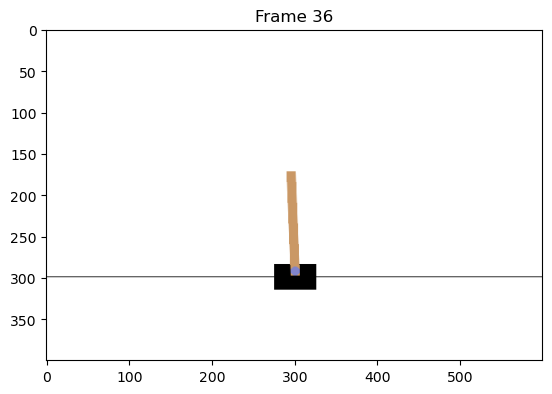

[ 0.01218088 -0.33701116 -0.04587113  0.1898313 ] [ 0.00544065 -0.141264   -0.04207451 -0.11696197] 1
New state:  [ 0.00544065 -0.141264   -0.04207451 -0.11696197] Reward:  1.0 Terminated:  False Truncated:  False


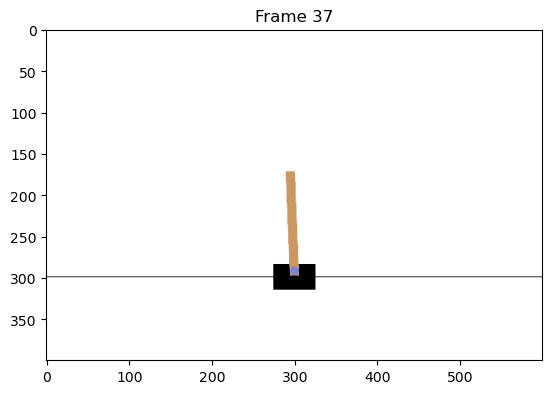

[ 0.00544065 -0.141264   -0.04207451 -0.11696197] [ 0.00261537 -0.33575863 -0.04441375  0.16215554] 0
New state:  [ 0.00261537 -0.33575863 -0.04441375  0.16215554] Reward:  1.0 Terminated:  False Truncated:  False


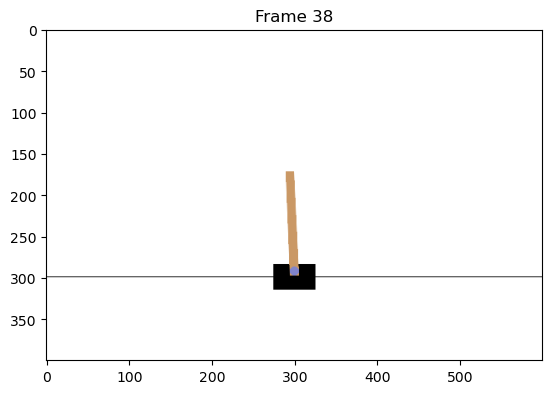

[ 0.00261537 -0.33575863 -0.04441375  0.16215554] [-0.0040998  -0.14002994 -0.04117064 -0.14420134] 1
New state:  [-0.0040998  -0.14002994 -0.04117064 -0.14420134] Reward:  1.0 Terminated:  False Truncated:  False


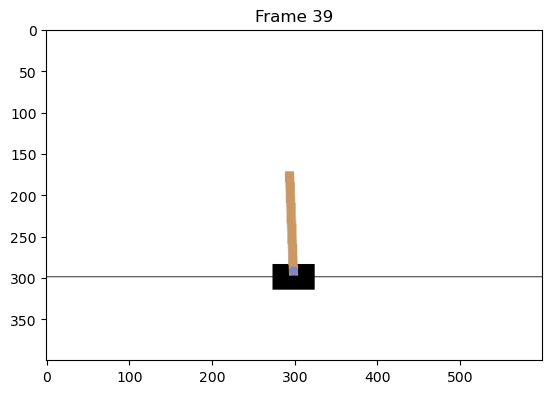

[-0.0040998  -0.14002994 -0.04117064 -0.14420134] [-0.0069004  -0.33453885 -0.04405466  0.13521402] 0
New state:  [-0.0069004  -0.33453885 -0.04405466  0.13521402] Reward:  1.0 Terminated:  False Truncated:  False


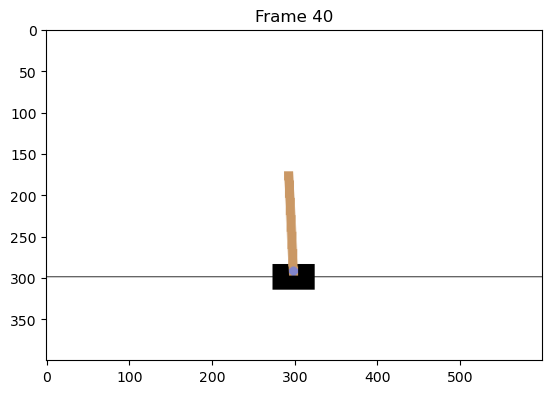

[-0.0069004  -0.33453885 -0.04405466  0.13521402] [-0.01359117 -0.13881445 -0.04135038 -0.17103559] 1
New state:  [-0.01359117 -0.13881445 -0.04135038 -0.17103559] Reward:  1.0 Terminated:  False Truncated:  False


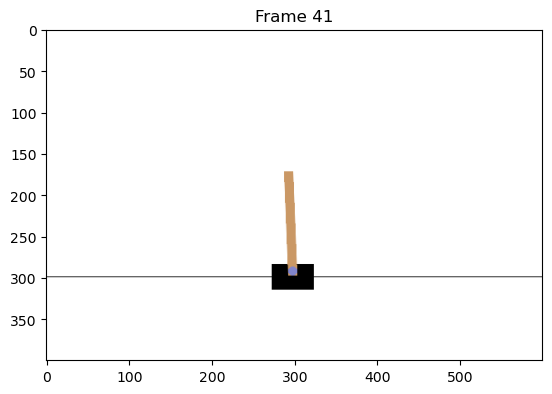

[-0.01359117 -0.13881445 -0.04135038 -0.17103559] [-0.01636746 -0.33332092 -0.0447711   0.10832116] 0
New state:  [-0.01636746 -0.33332092 -0.0447711   0.10832116] Reward:  1.0 Terminated:  False Truncated:  False


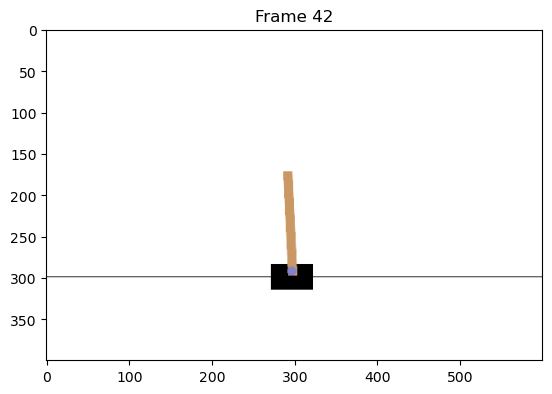

[-0.01636746 -0.33332092 -0.0447711   0.10832116] [-0.02303388 -0.13758694 -0.04260467 -0.1981439 ] 1
New state:  [-0.02303388 -0.13758694 -0.04260467 -0.1981439 ] Reward:  1.0 Terminated:  False Truncated:  False


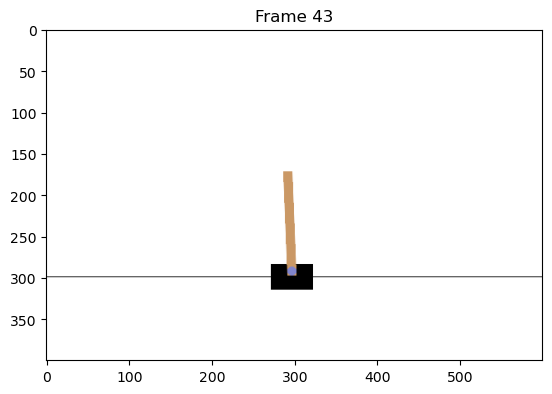

[-0.02303388 -0.13758694 -0.04260467 -0.1981439 ] [-0.02578562 -0.33207443 -0.04656755  0.08080062] 0
New state:  [-0.02578562 -0.33207443 -0.04656755  0.08080062] Reward:  1.0 Terminated:  False Truncated:  False


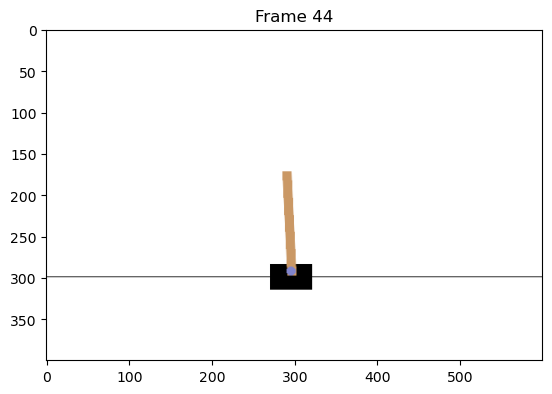

[-0.02578562 -0.33207443 -0.04656755  0.08080062] [-0.03242711 -0.13631694 -0.04495154 -0.22620322] 1
New state:  [-0.03242711 -0.13631694 -0.04495154 -0.22620322] Reward:  1.0 Terminated:  False Truncated:  False


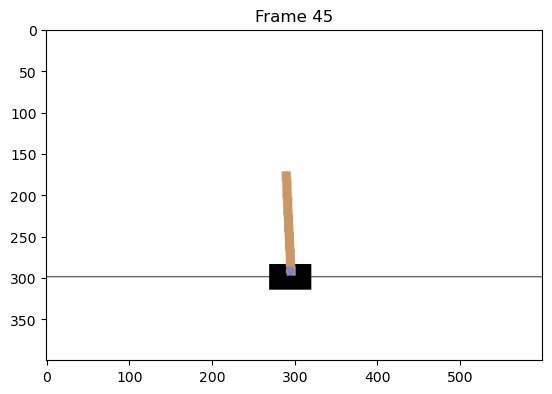

[-0.03242711 -0.13631694 -0.04495154 -0.22620322] [-0.03515345 -0.3307686  -0.0494756   0.05196834] 0
New state:  [-0.03515345 -0.3307686  -0.0494756   0.05196834] Reward:  1.0 Terminated:  False Truncated:  False


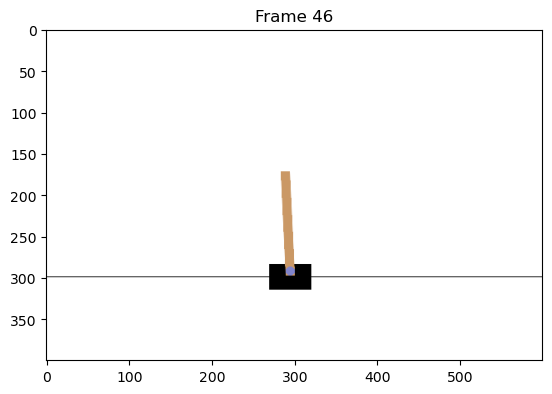

[-0.03515345 -0.3307686  -0.0494756   0.05196834] [-0.04176882 -0.5251475  -0.04843624  0.32864   ] 0
New state:  [-0.04176882 -0.5251475  -0.04843624  0.32864   ] Reward:  1.0 Terminated:  False Truncated:  False


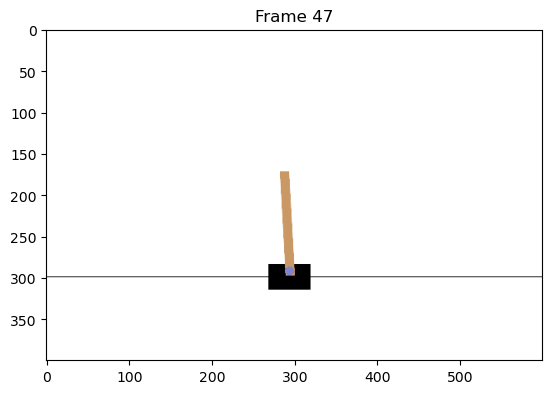

[-0.04176882 -0.5251475  -0.04843624  0.32864   ] [-0.05227177 -0.32937068 -0.04186344  0.02108449] 1
New state:  [-0.05227177 -0.32937068 -0.04186344  0.02108449] Reward:  1.0 Terminated:  False Truncated:  False


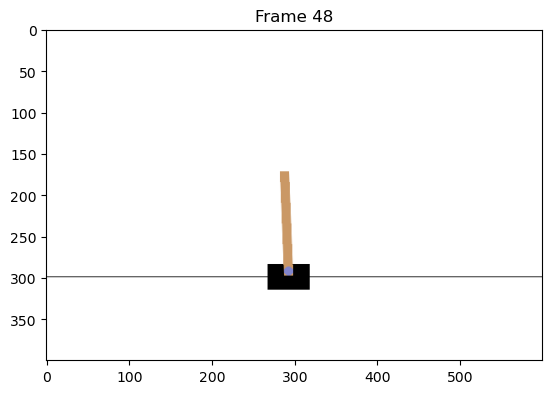

[-0.05227177 -0.32937068 -0.04186344  0.02108449] [-0.05885918 -0.523868   -0.04144175  0.30027068] 0
New state:  [-0.05885918 -0.523868   -0.04144175  0.30027068] Reward:  1.0 Terminated:  False Truncated:  False


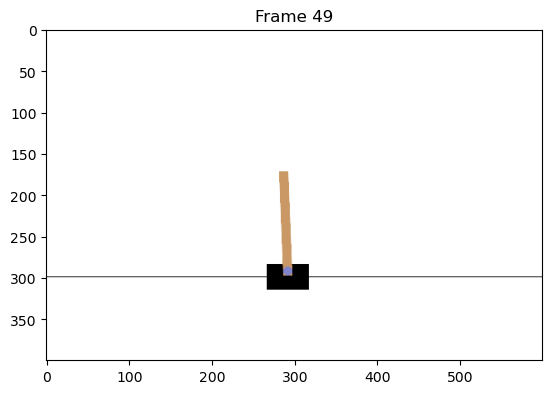

[-0.05885918 -0.523868   -0.04144175  0.30027068] [-0.06933654 -0.32818064 -0.03543633 -0.00518878] 1
New state:  [-0.06933654 -0.32818064 -0.03543633 -0.00518878] Reward:  1.0 Terminated:  False Truncated:  False


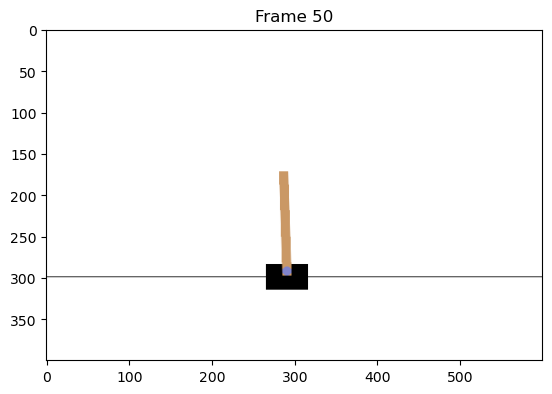

[-0.06933654 -0.32818064 -0.03543633 -0.00518878] [-0.07590015 -0.52277696 -0.03554011  0.27610633] 0
New state:  [-0.07590015 -0.52277696 -0.03554011  0.27610633] Reward:  1.0 Terminated:  False Truncated:  False


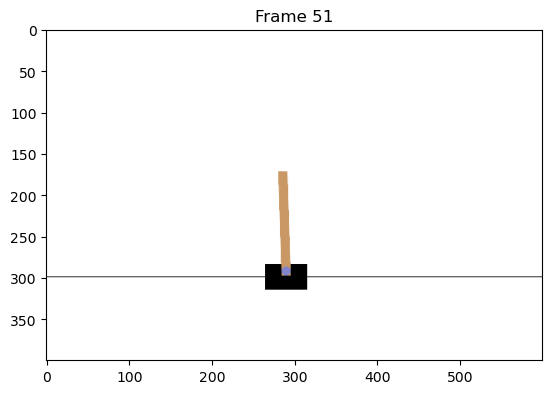

[-0.07590015 -0.52277696 -0.03554011  0.27610633] [-0.08635569 -0.32716644 -0.03001798 -0.02757075] 1
New state:  [-0.08635569 -0.32716644 -0.03001798 -0.02757075] Reward:  1.0 Terminated:  False Truncated:  False


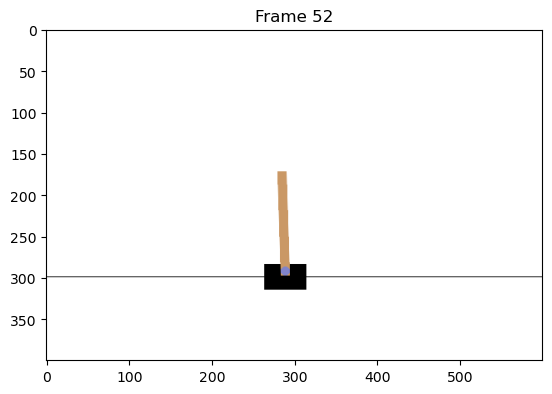

[-0.08635569 -0.32716644 -0.03001798 -0.02757075] [-0.09289902 -0.52184534 -0.0305694   0.2554921 ] 0
New state:  [-0.09289902 -0.52184534 -0.0305694   0.2554921 ] Reward:  1.0 Terminated:  False Truncated:  False


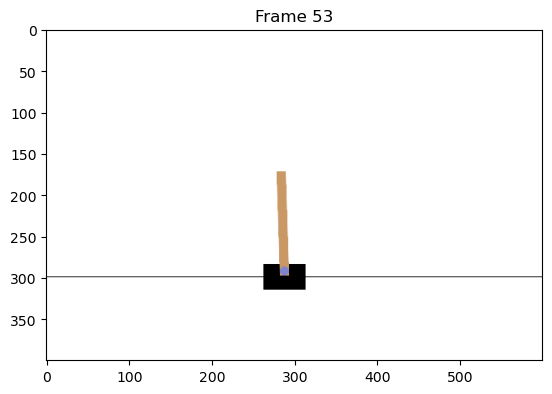

[-0.09289902 -0.52184534 -0.0305694   0.2554921 ] [-0.10333593 -0.32630056 -0.02545956 -0.04667405] 1
New state:  [-0.10333593 -0.32630056 -0.02545956 -0.04667405] Reward:  1.0 Terminated:  False Truncated:  False


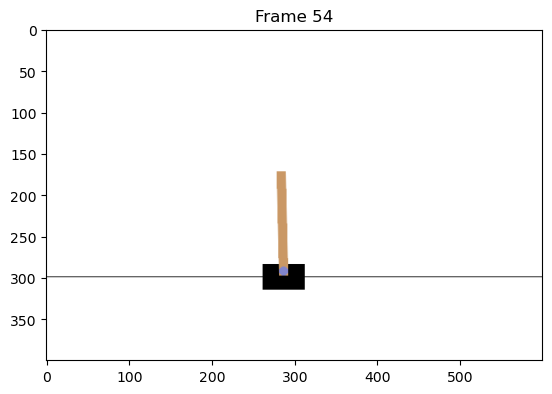

[-0.10333593 -0.32630056 -0.02545956 -0.04667405] [-0.10986194 -0.52104837 -0.02639304  0.23786868] 0
New state:  [-0.10986194 -0.52104837 -0.02639304  0.23786868] Reward:  1.0 Terminated:  False Truncated:  False


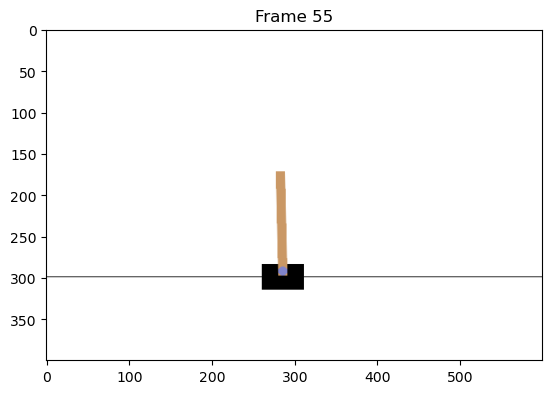

[-0.10986194 -0.52104837 -0.02639304  0.23786868] [-0.12028291 -0.3255595  -0.02163566 -0.06302115] 1
New state:  [-0.12028291 -0.3255595  -0.02163566 -0.06302115] Reward:  1.0 Terminated:  False Truncated:  False


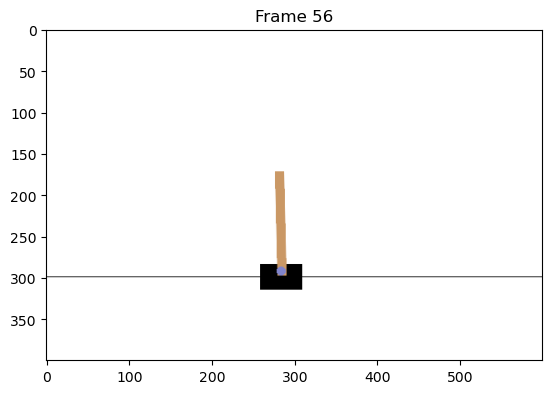

[-0.12028291 -0.3255595  -0.02163566 -0.06302115] [-0.1267941  -0.52036464 -0.02289609  0.22275783] 0
New state:  [-0.1267941  -0.52036464 -0.02289609  0.22275783] Reward:  1.0 Terminated:  False Truncated:  False


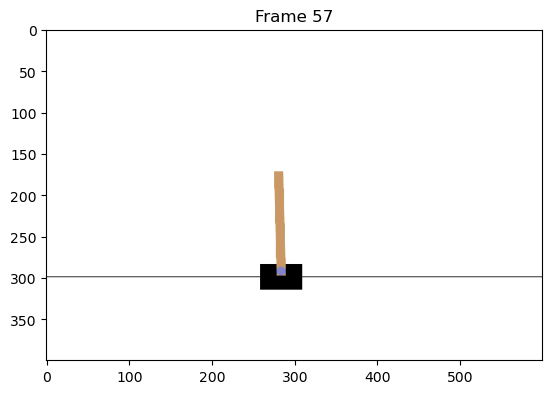

[-0.1267941  -0.52036464 -0.02289609  0.22275783] [-0.13720138 -0.32492307 -0.01844093 -0.07705858] 1
New state:  [-0.13720138 -0.32492307 -0.01844093 -0.07705858] Reward:  1.0 Terminated:  False Truncated:  False


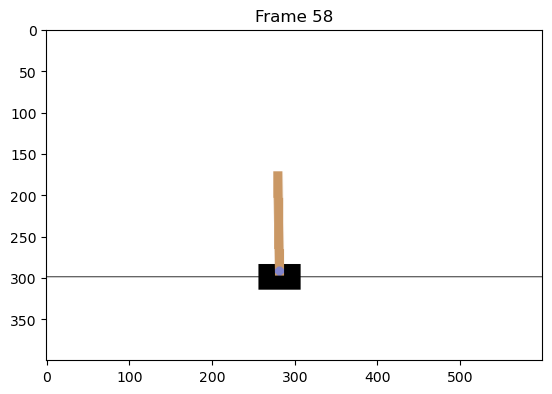

[-0.13720138 -0.32492307 -0.01844093 -0.07705858] [-0.14369985 -0.51977587 -0.0199821   0.2097496 ] 0
New state:  [-0.14369985 -0.51977587 -0.0199821   0.2097496 ] Reward:  1.0 Terminated:  False Truncated:  False


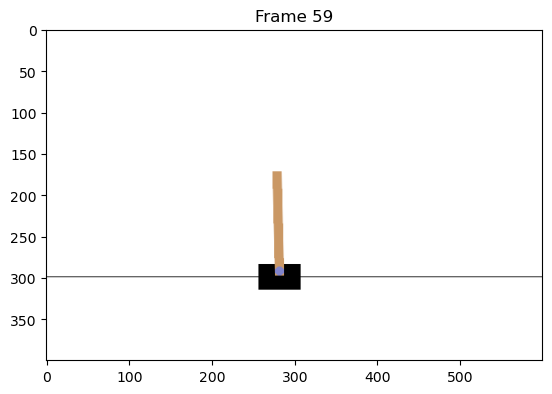

[-0.14369985 -0.51977587 -0.0199821   0.2097496 ] [-0.15409537 -0.324374   -0.01578711 -0.08916906] 1
New state:  [-0.15409537 -0.324374   -0.01578711 -0.08916906] Reward:  1.0 Terminated:  False Truncated:  False


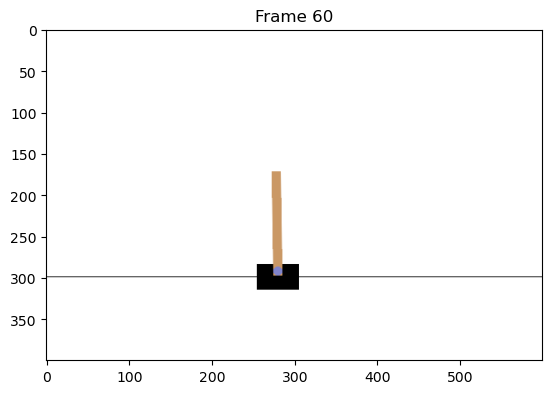

[-0.15409537 -0.324374   -0.01578711 -0.08916906] [-0.16058286 -0.5192661  -0.01757049  0.19849151] 0
New state:  [-0.16058286 -0.5192661  -0.01757049  0.19849151] Reward:  1.0 Terminated:  False Truncated:  False


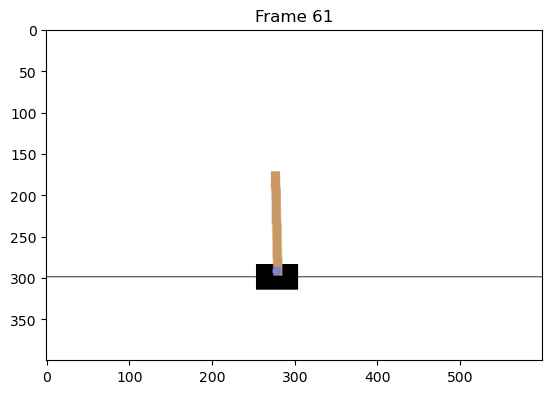

[-0.16058286 -0.5192661  -0.01757049  0.19849151] [-0.17096817 -0.32389733 -0.01360066 -0.09968191] 1
New state:  [-0.17096817 -0.32389733 -0.01360066 -0.09968191] Reward:  1.0 Terminated:  False Truncated:  False


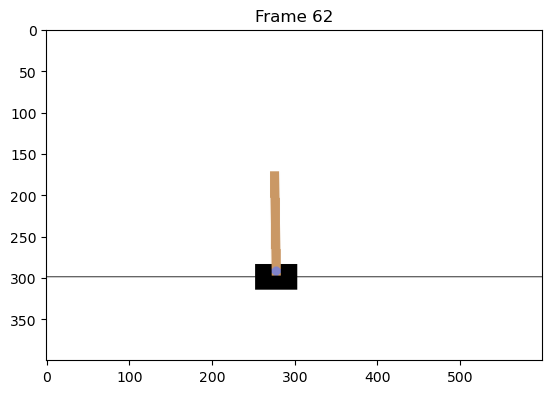

[-0.17096817 -0.32389733 -0.01360066 -0.09968191] [-0.17744611 -0.5188217  -0.0155943   0.1886792 ] 0
New state:  [-0.17744611 -0.5188217  -0.0155943   0.1886792 ] Reward:  1.0 Terminated:  False Truncated:  False


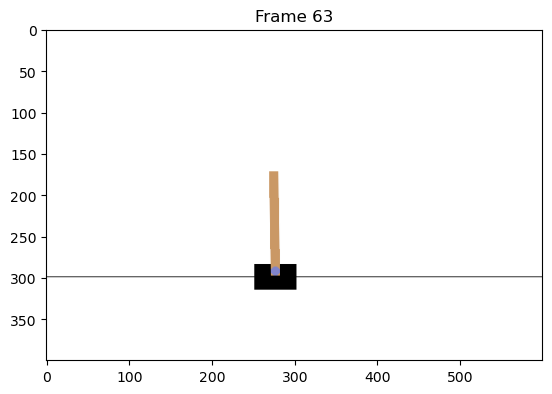

[-0.17744611 -0.5188217  -0.0155943   0.1886792 ] [-0.18782255 -0.3234802  -0.01182071 -0.10888202] 1
New state:  [-0.18782255 -0.3234802  -0.01182071 -0.10888202] Reward:  1.0 Terminated:  False Truncated:  False


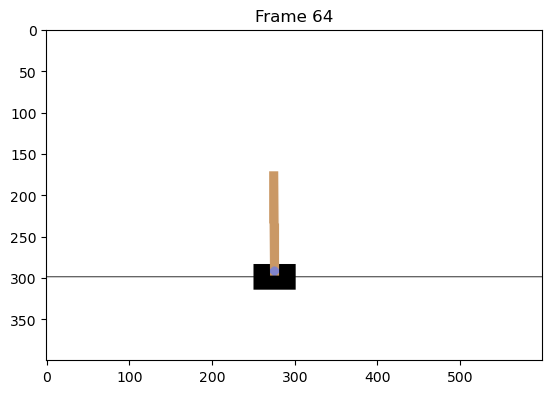

[-0.18782255 -0.3234802  -0.01182071 -0.10888202] [-0.19429216 -0.51843077 -0.01399835  0.18004821] 0
New state:  [-0.19429216 -0.51843077 -0.01399835  0.18004821] Reward:  1.0 Terminated:  False Truncated:  False


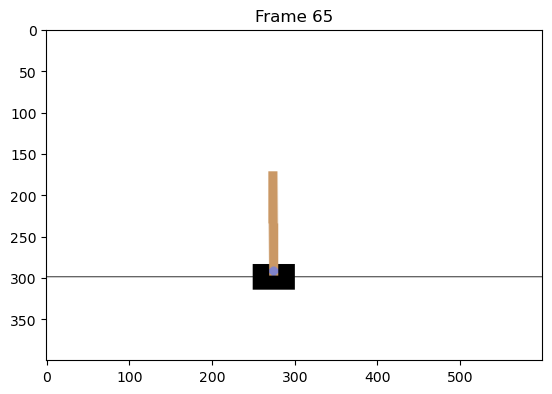

[-0.19429216 -0.51843077 -0.01399835  0.18004821] [-0.20466077 -0.32311136 -0.01039739 -0.11701762] 1
New state:  [-0.20466077 -0.32311136 -0.01039739 -0.11701762] Reward:  1.0 Terminated:  False Truncated:  False


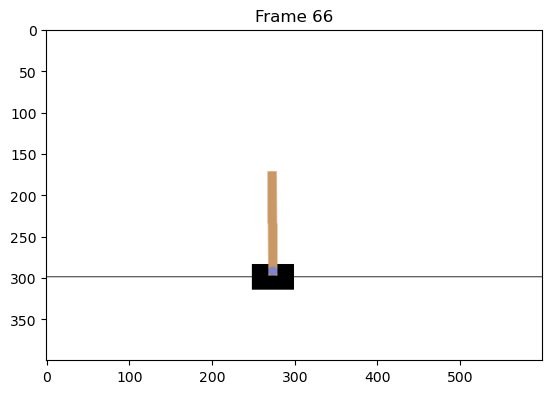

[-0.20466077 -0.32311136 -0.01039739 -0.11701762] [-0.211123   -0.5180828  -0.01273774  0.17236696] 0
New state:  [-0.211123   -0.5180828  -0.01273774  0.17236696] Reward:  1.0 Terminated:  False Truncated:  False


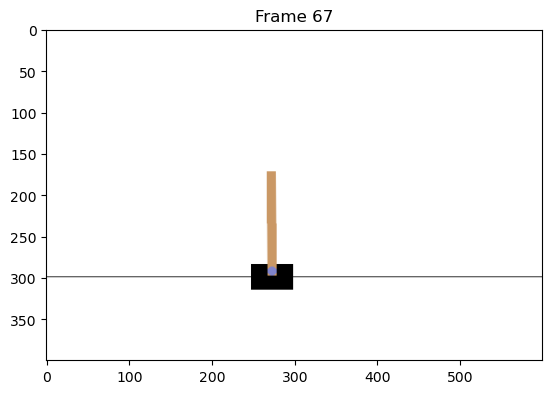

[-0.211123   -0.5180828  -0.01273774  0.17236696] [-0.22148466 -0.32278088 -0.0092904  -0.12430695] 1
New state:  [-0.22148466 -0.32278088 -0.0092904  -0.12430695] Reward:  1.0 Terminated:  False Truncated:  False


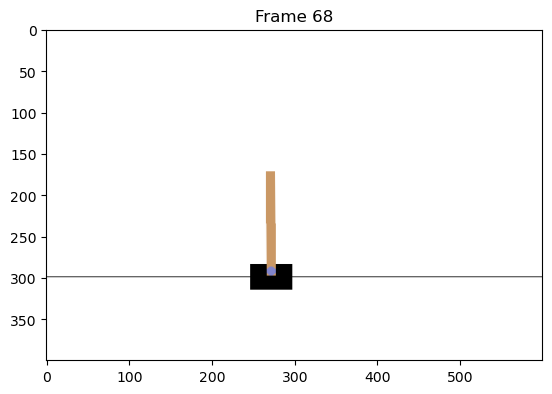

[-0.22148466 -0.32278088 -0.0092904  -0.12430695] [-0.22794028 -0.5177685  -0.01177654  0.16543053] 0
New state:  [-0.22794028 -0.5177685  -0.01177654  0.16543053] Reward:  1.0 Terminated:  False Truncated:  False


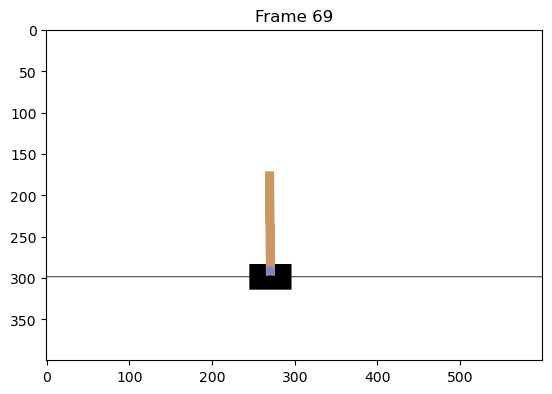

[-0.22794028 -0.5177685  -0.01177654  0.16543053] [-0.23829564 -0.32247996 -0.00846793 -0.13094418] 1
New state:  [-0.23829564 -0.32247996 -0.00846793 -0.13094418] Reward:  1.0 Terminated:  False Truncated:  False


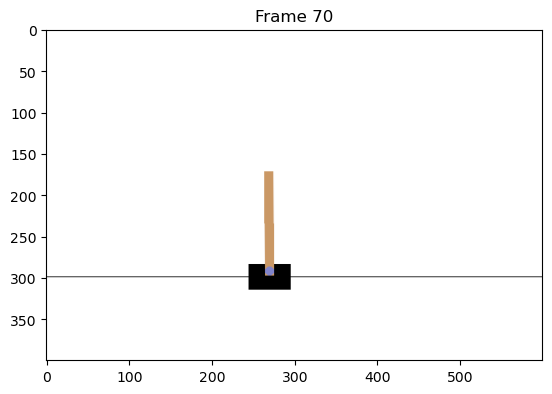

[-0.23829564 -0.32247996 -0.00846793 -0.13094418] [-0.24474524 -0.5174796  -0.01108681  0.15905525] 0
New state:  [-0.24474524 -0.5174796  -0.01108681  0.15905525] Reward:  1.0 Terminated:  False Truncated:  False


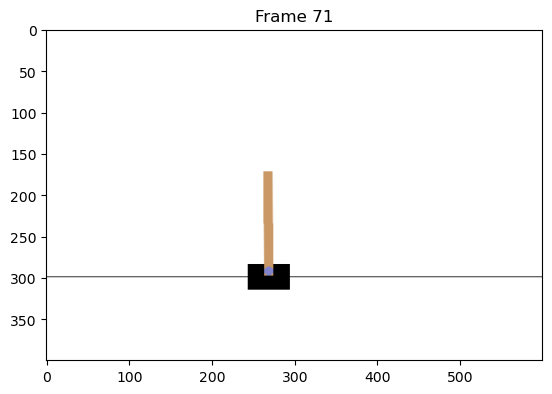

[-0.24474524 -0.5174796  -0.01108681  0.15905525] [-0.25509483 -0.3222007  -0.00790571 -0.13710457] 1
New state:  [-0.25509483 -0.3222007  -0.00790571 -0.13710457] Reward:  1.0 Terminated:  False Truncated:  False


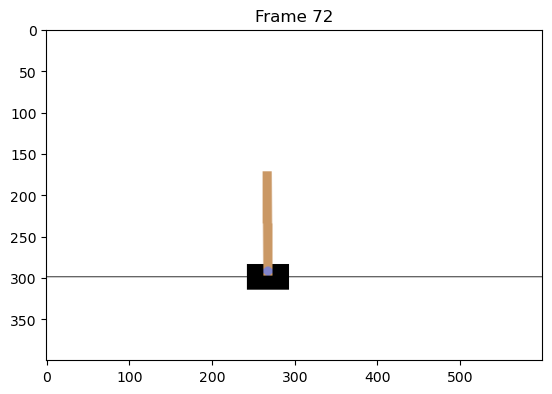

[-0.25509483 -0.3222007  -0.00790571 -0.13710457] [-0.26153883 -0.5172085  -0.0106478   0.15307377] 0
New state:  [-0.26153883 -0.5172085  -0.0106478   0.15307377] Reward:  1.0 Terminated:  False Truncated:  False


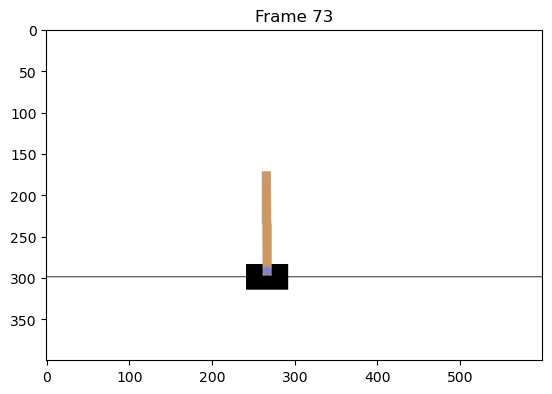

[-0.26153883 -0.5172085  -0.0106478   0.15307377] [-0.271883   -0.32193574 -0.00758633 -0.14294918] 1
New state:  [-0.271883   -0.32193574 -0.00758633 -0.14294918] Reward:  1.0 Terminated:  False Truncated:  False


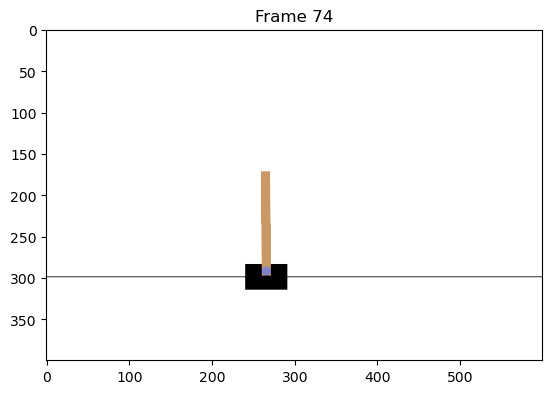

[-0.271883   -0.32193574 -0.00758633 -0.14294918] [-0.27832174 -0.5169482  -0.01044531  0.14733078] 0
New state:  [-0.27832174 -0.5169482  -0.01044531  0.14733078] Reward:  1.0 Terminated:  False Truncated:  False


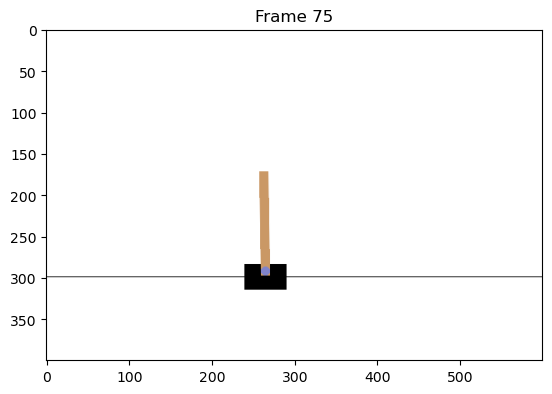

[-0.27832174 -0.5169482  -0.01044531  0.14733078] [-0.2886607  -0.32167825 -0.00749869 -0.14862905] 1
New state:  [-0.2886607  -0.32167825 -0.00749869 -0.14862905] Reward:  1.0 Terminated:  False Truncated:  False


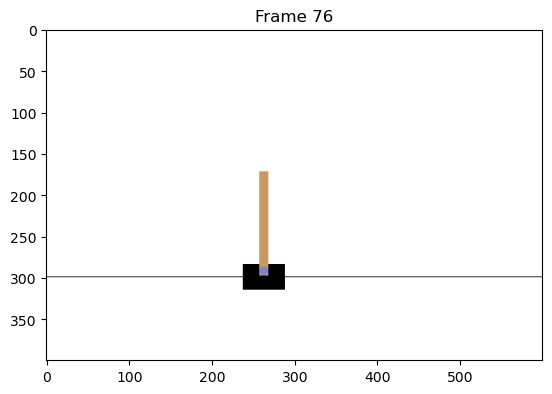

[-0.2886607  -0.32167825 -0.00749869 -0.14862905] [-0.29509425 -0.51669204 -0.01047128  0.14167878] 0
New state:  [-0.29509425 -0.51669204 -0.01047128  0.14167878] Reward:  1.0 Terminated:  False Truncated:  False


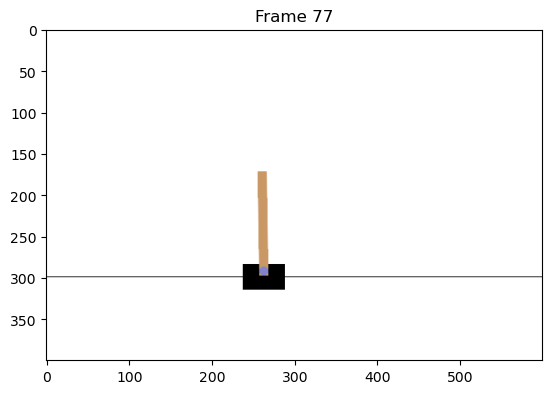

[-0.29509425 -0.51669204 -0.01047128  0.14167878] [-0.30542812 -0.32142168 -0.0076377  -0.15428917] 1
New state:  [-0.30542812 -0.32142168 -0.0076377  -0.15428917] Reward:  1.0 Terminated:  False Truncated:  False


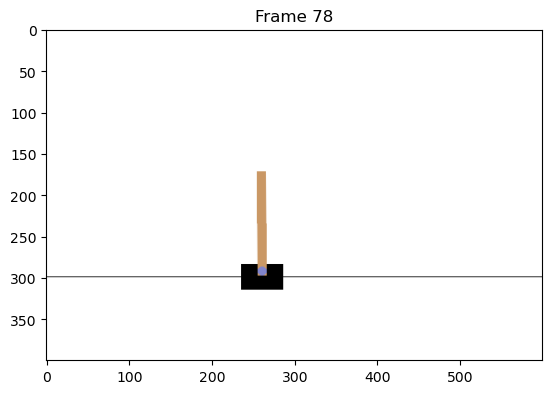

[-0.30542812 -0.32142168 -0.0076377  -0.15428917] [-0.31185654 -0.5164335  -0.01072348  0.13597448] 0
New state:  [-0.31185654 -0.5164335  -0.01072348  0.13597448] Reward:  1.0 Terminated:  False Truncated:  False


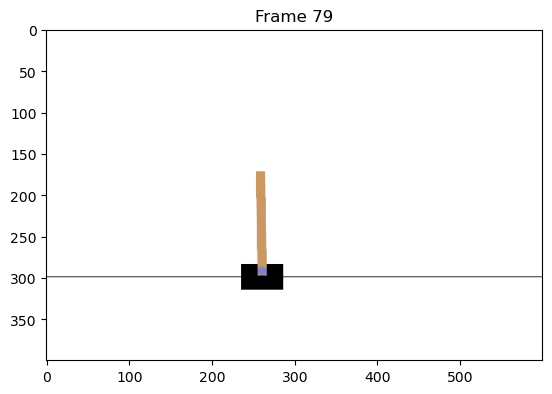

[-0.31185654 -0.5164335  -0.01072348  0.13597448] [-0.32218522 -0.32115957 -0.00800399 -0.16007216] 1
New state:  [-0.32218522 -0.32115957 -0.00800399 -0.16007216] Reward:  1.0 Terminated:  False Truncated:  False


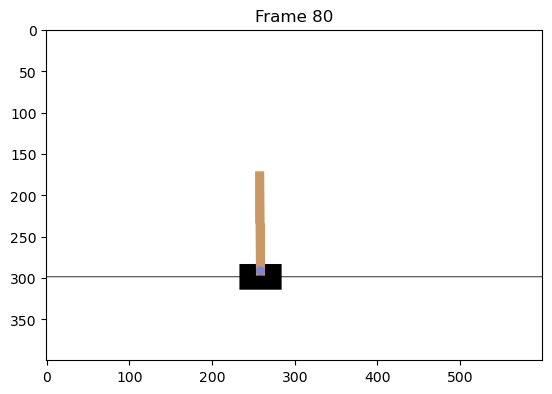

[-0.32218522 -0.32115957 -0.00800399 -0.16007216] [-0.3286084  -0.51616603 -0.01120544  0.130075  ] 0
New state:  [-0.3286084  -0.51616603 -0.01120544  0.130075  ] Reward:  1.0 Terminated:  False Truncated:  False


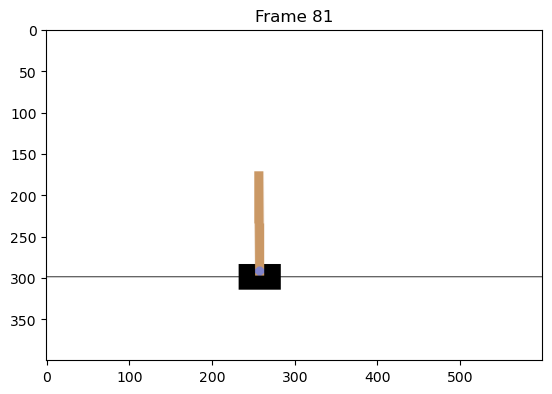

[-0.3286084  -0.51616603 -0.01120544  0.130075  ] [-0.3389317  -0.32088536 -0.00860394 -0.16612193] 1
New state:  [-0.3389317  -0.32088536 -0.00860394 -0.16612193] Reward:  1.0 Terminated:  False Truncated:  False


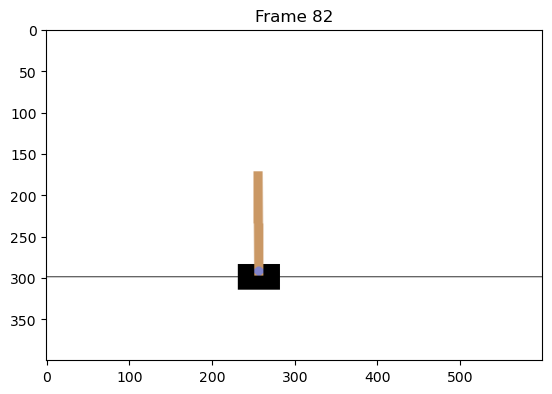

[-0.3389317  -0.32088536 -0.00860394 -0.16612193] [-0.34534943 -0.5158831  -0.01192638  0.12383433] 0
New state:  [-0.34534943 -0.5158831  -0.01192638  0.12383433] Reward:  1.0 Terminated:  False Truncated:  False


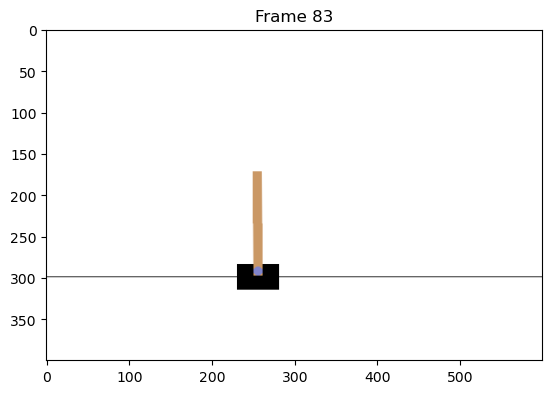

[-0.34534943 -0.5158831  -0.01192638  0.12383433] [-0.35566708 -0.32059234 -0.00944969 -0.17258726] 1
New state:  [-0.35566708 -0.32059234 -0.00944969 -0.17258726] Reward:  1.0 Terminated:  False Truncated:  False


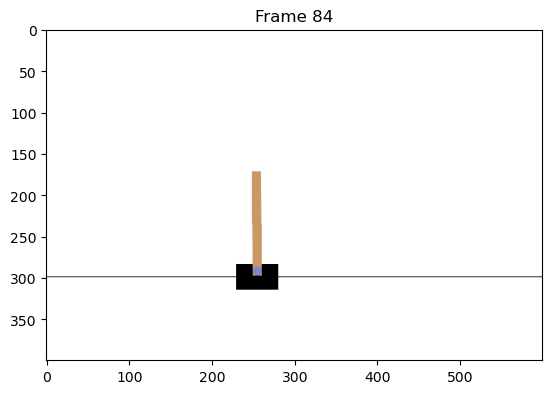

[-0.35566708 -0.32059234 -0.00944969 -0.17258726] [-0.36207893 -0.5155778  -0.01290143  0.11709967] 0
New state:  [-0.36207893 -0.5155778  -0.01290143  0.11709967] Reward:  1.0 Terminated:  False Truncated:  False


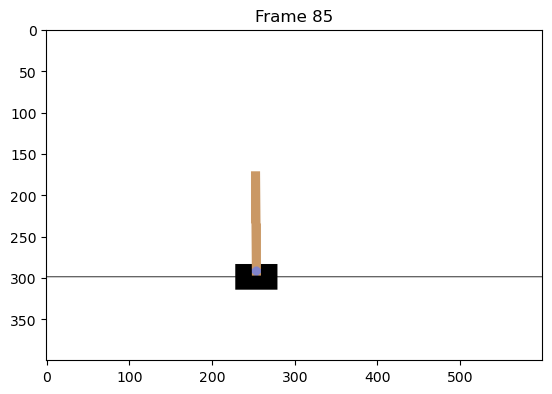

[-0.36207893 -0.5155778  -0.01290143  0.11709967] [-0.37239048 -0.32027337 -0.01055944 -0.17962548] 1
New state:  [-0.37239048 -0.32027337 -0.01055944 -0.17962548] Reward:  1.0 Terminated:  False Truncated:  False


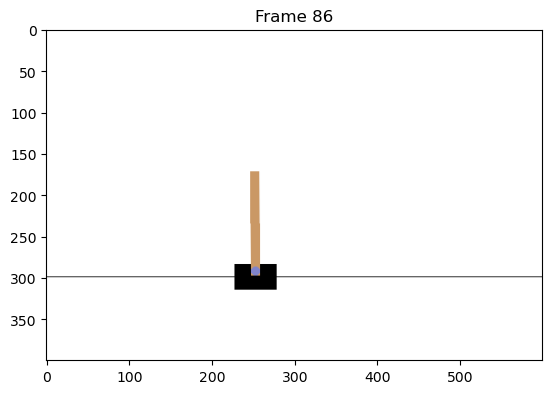

[-0.37239048 -0.32027337 -0.01055944 -0.17962548] [-0.37879595 -0.51524264 -0.01415195  0.10970771] 0
New state:  [-0.37879595 -0.51524264 -0.01415195  0.10970771] Reward:  1.0 Terminated:  False Truncated:  False


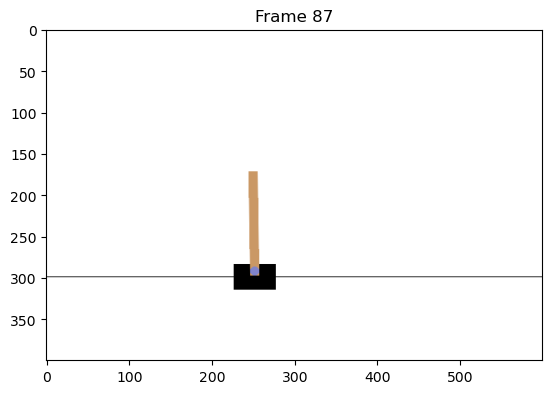

[-0.37879595 -0.51524264 -0.01415195  0.10970771] [-0.38910082 -0.31992078 -0.0119578  -0.18740627] 1
New state:  [-0.38910082 -0.31992078 -0.0119578  -0.18740627] Reward:  1.0 Terminated:  False Truncated:  False


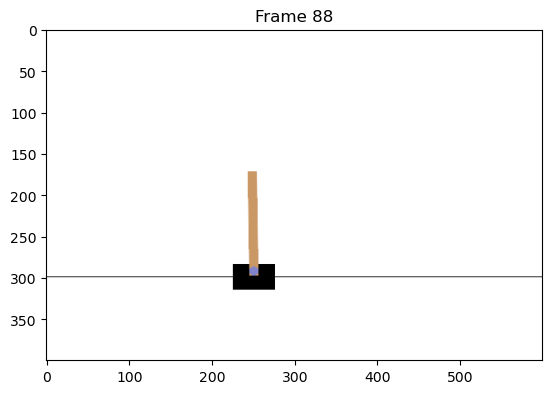

[-0.38910082 -0.31992078 -0.0119578  -0.18740627] [-0.39549923 -0.51486963 -0.01570592  0.10148057] 0
New state:  [-0.39549923 -0.51486963 -0.01570592  0.10148057] Reward:  1.0 Terminated:  False Truncated:  False


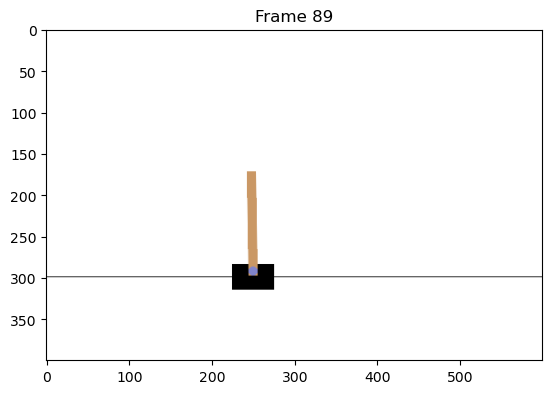

[-0.39549923 -0.51486963 -0.01570592  0.10148057] [-0.40579662 -0.31952614 -0.01367631 -0.19611585] 1
New state:  [-0.40579662 -0.31952614 -0.01367631 -0.19611585] Reward:  1.0 Terminated:  False Truncated:  False


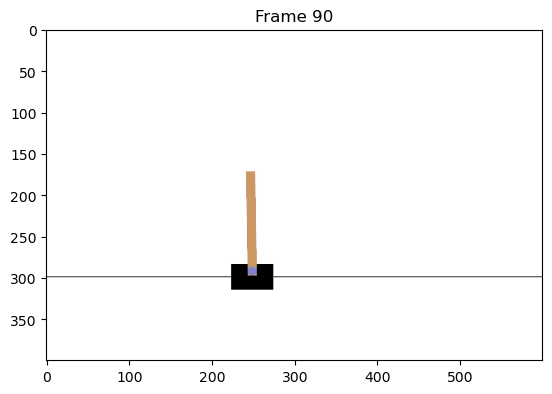

[-0.40579662 -0.31952614 -0.01367631 -0.19611585] [-0.41218713 -0.51444983 -0.01759863  0.09222162] 0
New state:  [-0.41218713 -0.51444983 -0.01759863  0.09222162] Reward:  1.0 Terminated:  False Truncated:  False


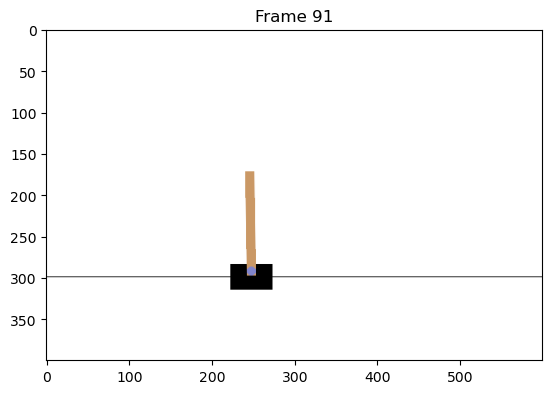

[-0.41218713 -0.51444983 -0.01759863  0.09222162] [-0.42247614 -0.3190801  -0.01575419 -0.2059613 ] 1
New state:  [-0.42247614 -0.3190801  -0.01575419 -0.2059613 ] Reward:  1.0 Terminated:  False Truncated:  False


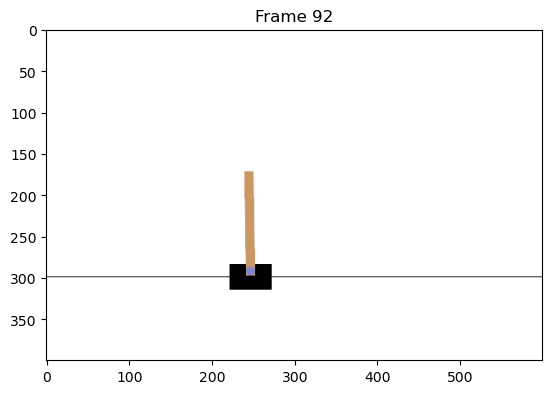

[-0.42247614 -0.3190801  -0.01575419 -0.2059613 ] [-0.42885774 -0.5139733  -0.01987342  0.08171062] 0
New state:  [-0.42885774 -0.5139733  -0.01987342  0.08171062] Reward:  1.0 Terminated:  False Truncated:  False


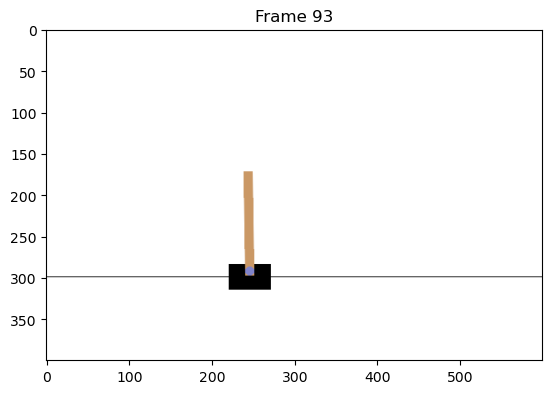

[-0.42885774 -0.5139733  -0.01987342  0.08171062] [-0.4391372  -0.31857216 -0.01823921 -0.21717557] 1
New state:  [-0.4391372  -0.31857216 -0.01823921 -0.21717557] Reward:  1.0 Terminated:  False Truncated:  False


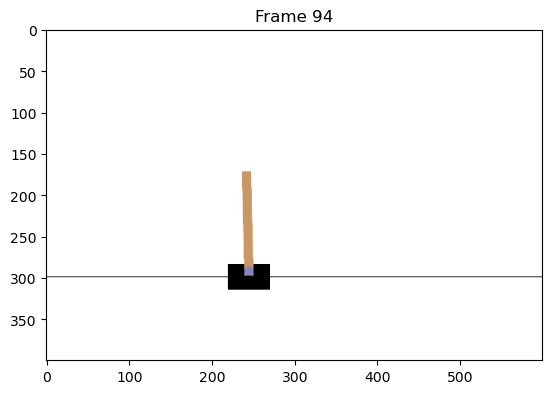

[-0.4391372  -0.31857216 -0.01823921 -0.21717557] [-0.44550866 -0.5134287  -0.02258272  0.06969858] 0
New state:  [-0.44550866 -0.5134287  -0.02258272  0.06969858] Reward:  1.0 Terminated:  False Truncated:  False


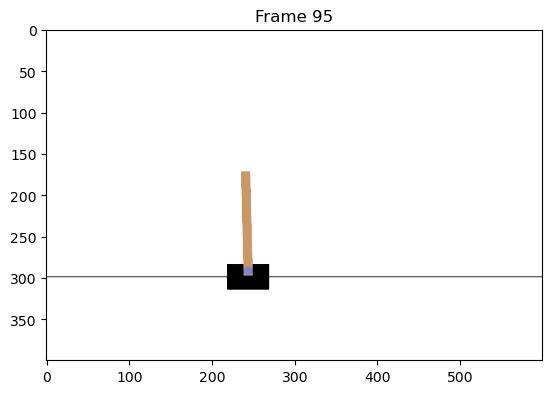

[-0.44550866 -0.5134287  -0.02258272  0.06969858] [-0.45577723 -0.3179904  -0.02118875 -0.23002289] 1
New state:  [-0.45577723 -0.3179904  -0.02118875 -0.23002289] Reward:  1.0 Terminated:  False Truncated:  False


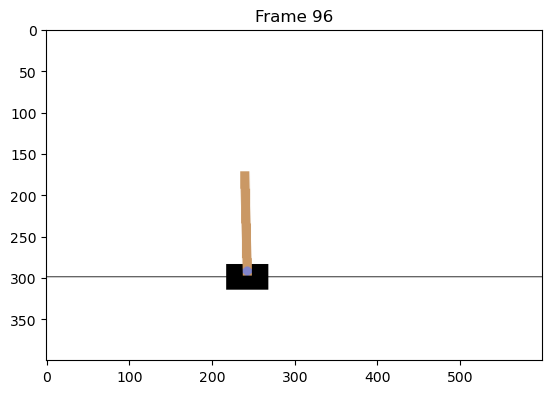

[-0.45577723 -0.3179904  -0.02118875 -0.23002289] [-0.46213704 -0.51280326 -0.0257892   0.05590177] 0
New state:  [-0.46213704 -0.51280326 -0.0257892   0.05590177] Reward:  1.0 Terminated:  False Truncated:  False


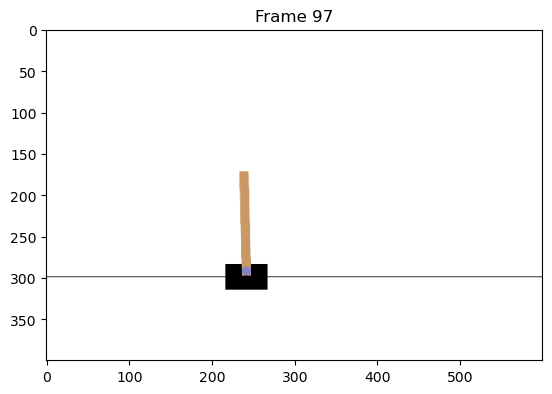

[-0.46213704 -0.51280326 -0.0257892   0.05590177] [-0.4723931  -0.31732118 -0.02467117 -0.244805  ] 1
New state:  [-0.4723931  -0.31732118 -0.02467117 -0.244805  ] Reward:  1.0 Terminated:  False Truncated:  False


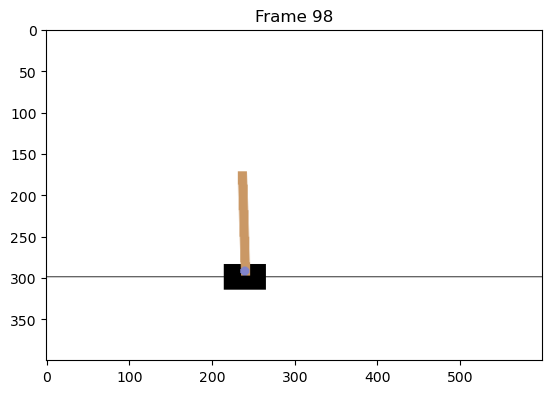

[-0.4723931  -0.31732118 -0.02467117 -0.244805  ] [-0.47873953 -0.5120822  -0.02956727  0.03999509] 0
New state:  [-0.47873953 -0.5120822  -0.02956727  0.03999509] Reward:  1.0 Terminated:  False Truncated:  False


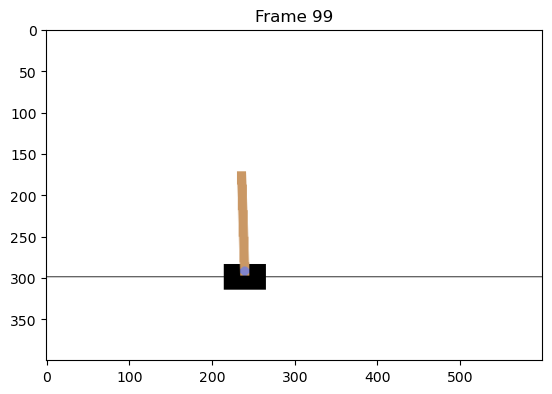

[-0.47873953 -0.5120822  -0.02956727  0.03999509] [-0.48898116 -0.31654903 -0.02876737 -0.26186803] 1
New state:  [-0.48898116 -0.31654903 -0.02876737 -0.26186803] Reward:  1.0 Terminated:  False Truncated:  False


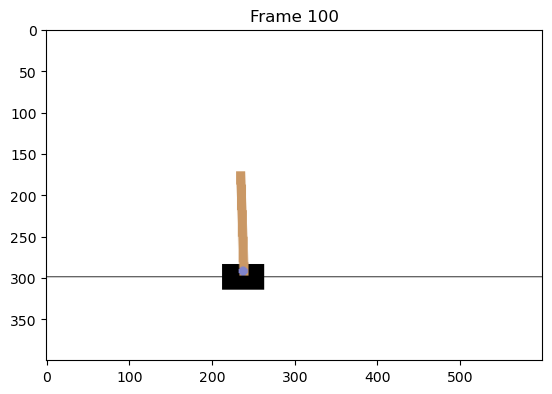

[-0.48898116 -0.31654903 -0.02876737 -0.26186803] [-0.49531215 -0.51124877 -0.03400473  0.02160433] 0
New state:  [-0.49531215 -0.51124877 -0.03400473  0.02160433] Reward:  1.0 Terminated:  False Truncated:  False


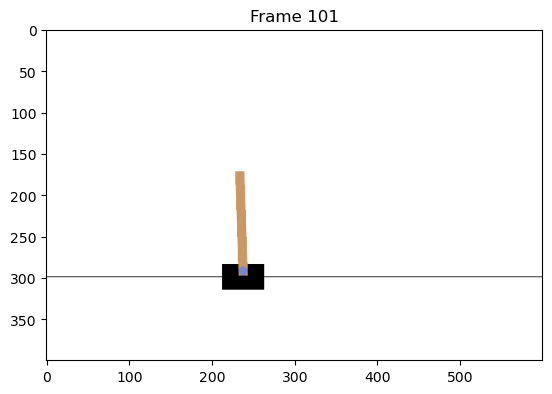

[-0.49531215 -0.51124877 -0.03400473  0.02160433] [-0.5055371  -0.705867   -0.03357264  0.3033674 ] 0
New state:  [-0.5055371  -0.705867   -0.03357264  0.3033674 ] Reward:  1.0 Terminated:  False Truncated:  False


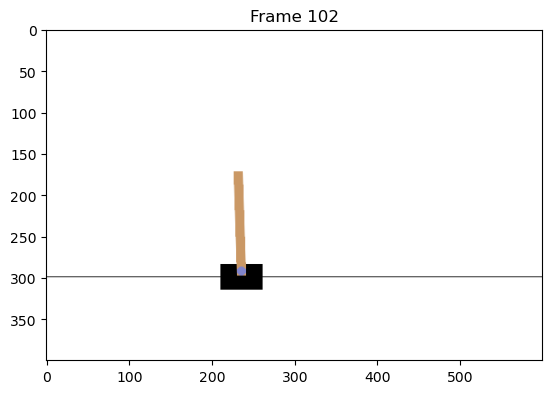

[-0.5055371  -0.705867   -0.03357264  0.3033674 ] [-5.1965445e-01 -5.1028305e-01 -2.7505293e-02  2.8832789e-04] 1
New state:  [-5.1965445e-01 -5.1028305e-01 -2.7505293e-02  2.8832789e-04] Reward:  1.0 Terminated:  False Truncated:  False


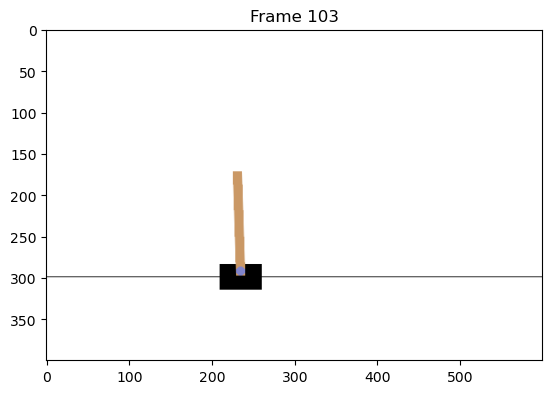

[-5.1965445e-01 -5.1028305e-01 -2.7505293e-02  2.8832789e-04] [-0.52986014 -0.705      -0.02749953  0.28416768] 0
New state:  [-0.52986014 -0.705      -0.02749953  0.28416768] Reward:  1.0 Terminated:  False Truncated:  False


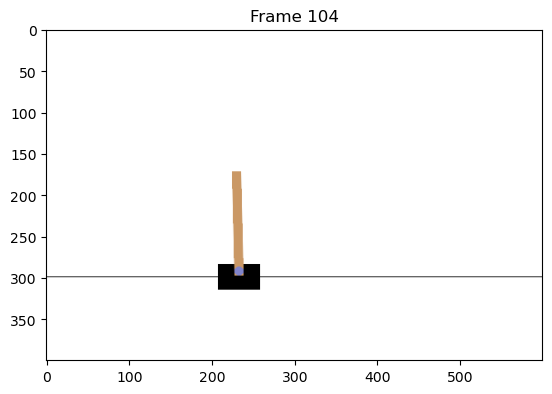

[-0.52986014 -0.705      -0.02749953  0.28416768] [-0.5439601  -0.5094968  -0.02181617 -0.01706002] 1
New state:  [-0.5439601  -0.5094968  -0.02181617 -0.01706002] Reward:  1.0 Terminated:  False Truncated:  False


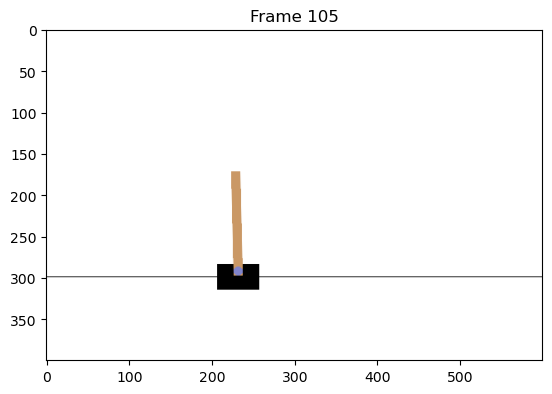

[-0.5439601  -0.5094968  -0.02181617 -0.01706002] [-0.55415004 -0.7042992  -0.02215737  0.2686606 ] 0
New state:  [-0.55415004 -0.7042992  -0.02215737  0.2686606 ] Reward:  1.0 Terminated:  False Truncated:  False


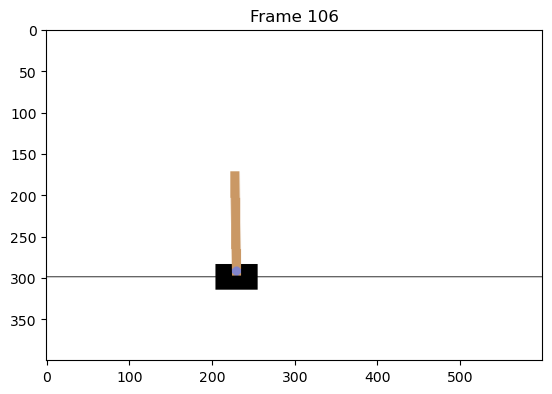

[-0.55415004 -0.7042992  -0.02215737  0.2686606 ] [-0.56823605 -0.50886816 -0.01678416 -0.03092774] 1
New state:  [-0.56823605 -0.50886816 -0.01678416 -0.03092774] Reward:  1.0 Terminated:  False Truncated:  False


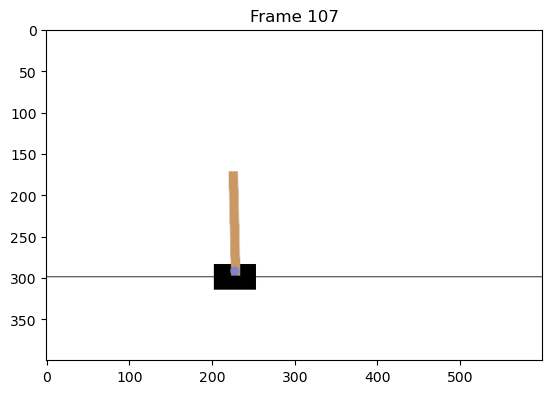

[-0.56823605 -0.50886816 -0.01678416 -0.03092774] [-0.5784134  -0.7037455  -0.01740272  0.2564127 ] 0
New state:  [-0.5784134  -0.7037455  -0.01740272  0.2564127 ] Reward:  1.0 Terminated:  False Truncated:  False


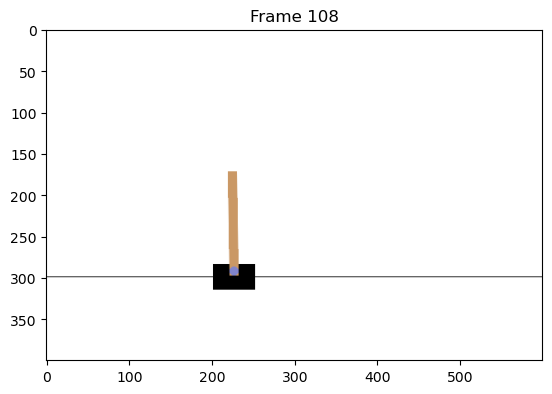

[-0.5784134  -0.7037455  -0.01740272  0.2564127 ] [-0.5924883  -0.5083794  -0.01227446 -0.04170812] 1
New state:  [-0.5924883  -0.5083794  -0.01227446 -0.04170812] Reward:  1.0 Terminated:  False Truncated:  False


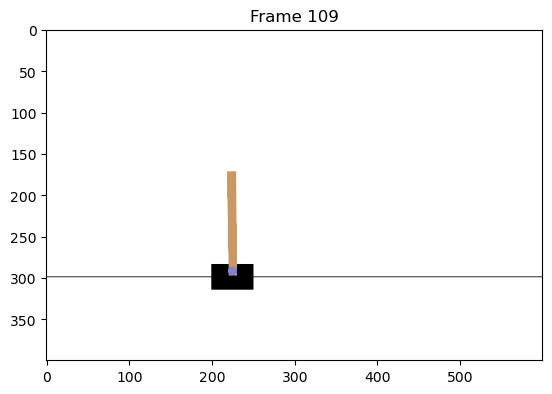

[-0.5924883  -0.5083794  -0.01227446 -0.04170812] [-0.6026559  -0.70332325 -0.01310863  0.24707697] 0
New state:  [-0.6026559  -0.70332325 -0.01310863  0.24707697] Reward:  1.0 Terminated:  False Truncated:  False


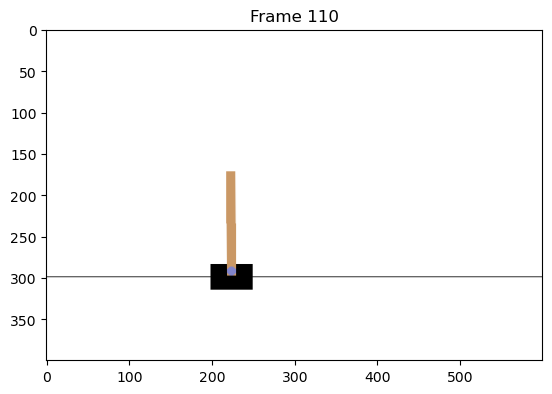

[-0.6026559  -0.70332325 -0.01310863  0.24707697] [-0.61672235 -0.5080165  -0.00816709 -0.04971172] 1
New state:  [-0.61672235 -0.5080165  -0.00816709 -0.04971172] Reward:  1.0 Terminated:  False Truncated:  False


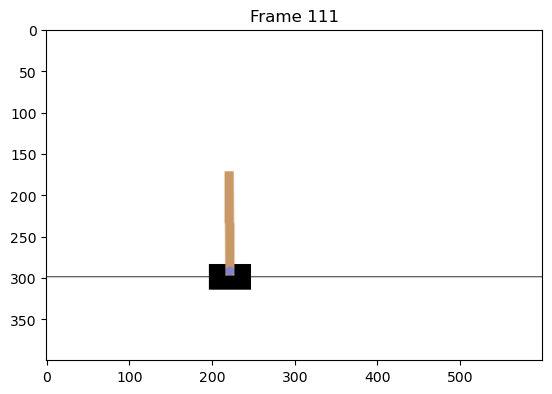

[-0.61672235 -0.5080165  -0.00816709 -0.04971172] [-0.6268827  -0.70302045 -0.00916132  0.24038327] 0
New state:  [-0.6268827  -0.70302045 -0.00916132  0.24038327] Reward:  1.0 Terminated:  False Truncated:  False


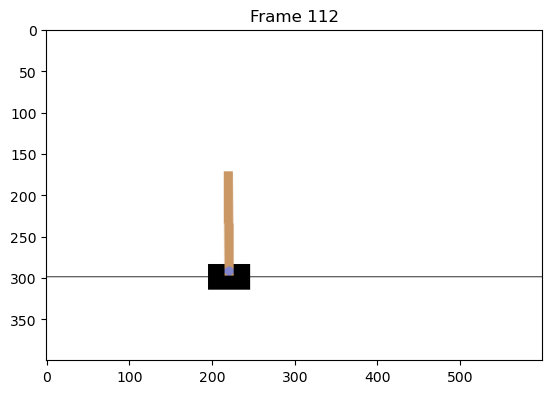

[-0.6268827  -0.70302045 -0.00916132  0.24038327] [-0.6409431  -0.5077688  -0.00435366 -0.05517526] 1
New state:  [-0.6409431  -0.5077688  -0.00435366 -0.05517526] Reward:  1.0 Terminated:  False Truncated:  False


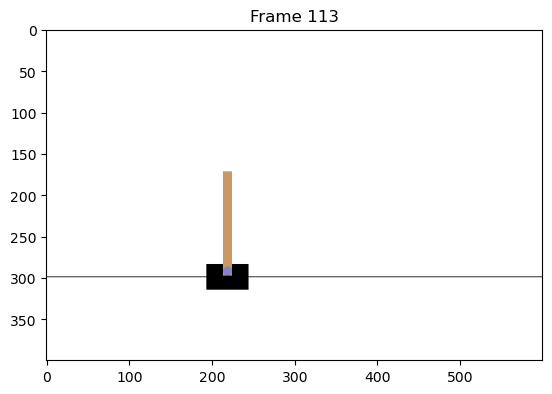

[-0.6409431  -0.5077688  -0.00435366 -0.05517526] [-0.6510985  -0.70282805 -0.00545716  0.2361309 ] 0
New state:  [-0.6510985  -0.70282805 -0.00545716  0.2361309 ] Reward:  1.0 Terminated:  False Truncated:  False


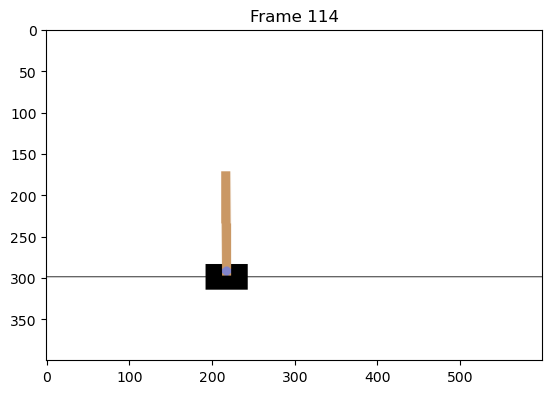

[-0.6510985  -0.70282805 -0.00545716  0.2361309 ] [-0.66515505 -0.50762856 -0.00073454 -0.05826839] 1
New state:  [-0.66515505 -0.50762856 -0.00073454 -0.05826839] Reward:  1.0 Terminated:  False Truncated:  False


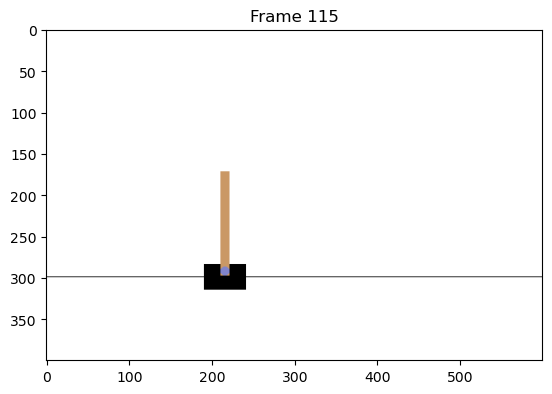

[-0.66515505 -0.50762856 -0.00073454 -0.05826839] [-0.67530763 -0.70274    -0.00189991  0.2341827 ] 0
New state:  [-0.67530763 -0.70274    -0.00189991  0.2341827 ] Reward:  1.0 Terminated:  False Truncated:  False


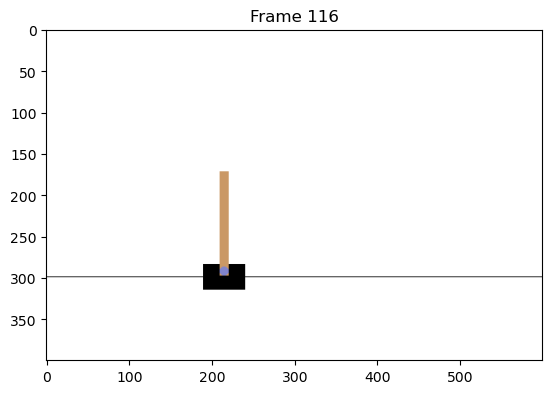

[-0.67530763 -0.70274    -0.00189991  0.2341827 ] [-0.6893624  -0.50759095  0.00278374 -0.05909892] 1
New state:  [-0.6893624  -0.50759095  0.00278374 -0.05909892] Reward:  1.0 Terminated:  False Truncated:  False


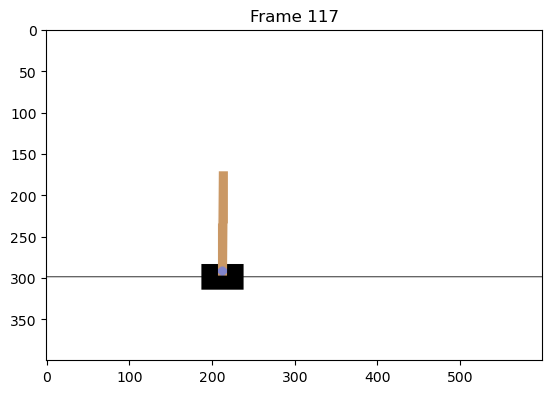

[-0.6893624  -0.50759095  0.00278374 -0.05909892] [-0.6995142  -0.7027527   0.00160177  0.234461  ] 0
New state:  [-0.6995142  -0.7027527   0.00160177  0.234461  ] Reward:  1.0 Terminated:  False Truncated:  False


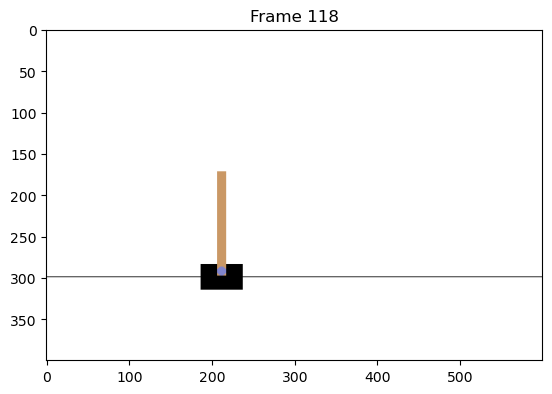

[-0.6995142  -0.7027527   0.00160177  0.234461  ] [-0.7135693  -0.50765365  0.00629099 -0.05771625] 1
New state:  [-0.7135693  -0.50765365  0.00629099 -0.05771625] Reward:  1.0 Terminated:  False Truncated:  False


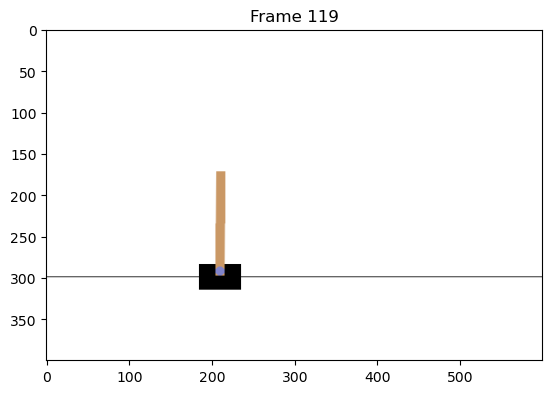

[-0.7135693  -0.50765365  0.00629099 -0.05771625] [-0.72372234 -0.70286524  0.00513666  0.23694487] 0
New state:  [-0.72372234 -0.70286524  0.00513666  0.23694487] Reward:  1.0 Terminated:  False Truncated:  False


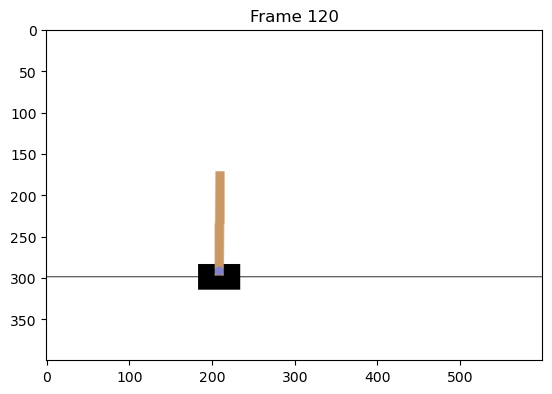

[-0.72372234 -0.70286524  0.00513666  0.23694487] [-0.7377797  -0.5078171   0.00987556 -0.05411338] 1
New state:  [-0.7377797  -0.5078171   0.00987556 -0.05411338] Reward:  1.0 Terminated:  False Truncated:  False


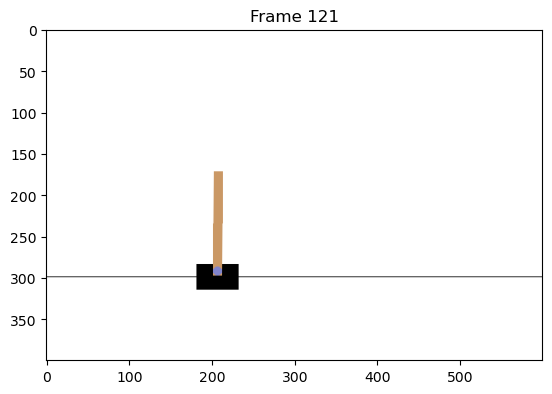

[-0.7377797  -0.5078171   0.00987556 -0.05411338] [-0.747936   -0.3128381   0.00879329 -0.3436642 ] 1
New state:  [-0.747936   -0.3128381   0.00879329 -0.3436642 ] Reward:  1.0 Terminated:  False Truncated:  False


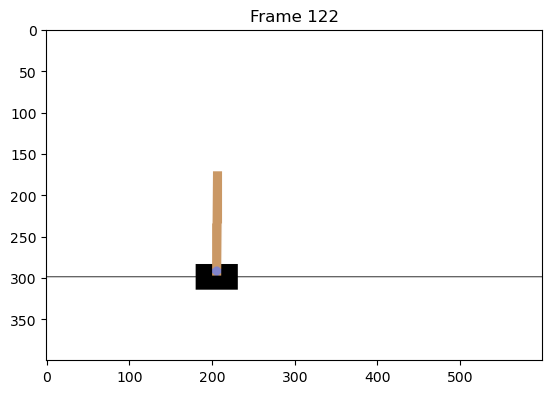

[-0.747936   -0.3128381   0.00879329 -0.3436642 ] [-0.75419277 -0.50808406  0.00192001 -0.04822143] 0
New state:  [-0.75419277 -0.50808406  0.00192001 -0.04822143] Reward:  1.0 Terminated:  False Truncated:  False


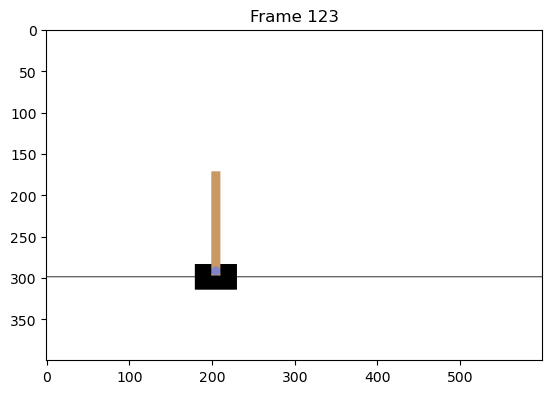

[-0.75419277 -0.50808406  0.00192001 -0.04822143] [-0.76435447 -0.31298968  0.00095558 -0.34029797] 1
New state:  [-0.76435447 -0.31298968  0.00095558 -0.34029797] Reward:  1.0 Terminated:  False Truncated:  False


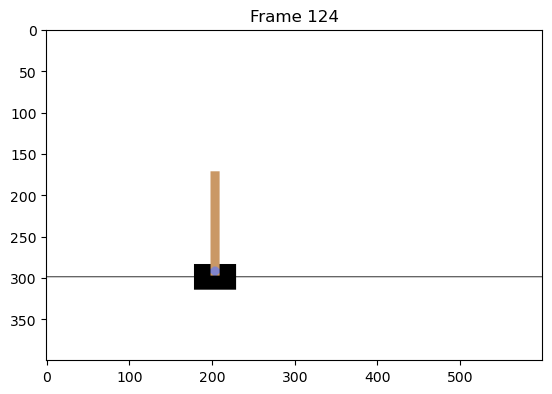

[-0.76435447 -0.31298968  0.00095558 -0.34029797] [-0.77061427 -0.5081252  -0.00585038 -0.04731385] 0
New state:  [-0.77061427 -0.5081252  -0.00585038 -0.04731385] Reward:  1.0 Terminated:  False Truncated:  False


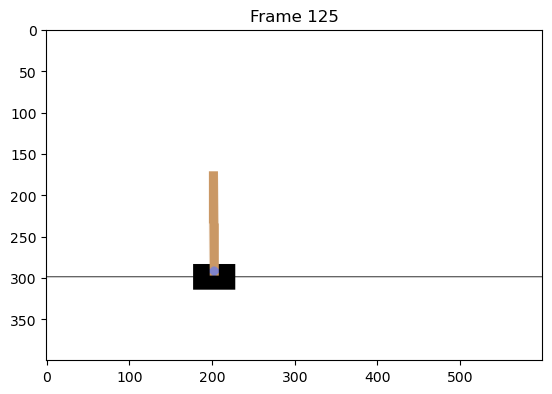

[-0.77061427 -0.5081252  -0.00585038 -0.04731385] [-0.78077674 -0.31291986 -0.00679666 -0.34183687] 1
New state:  [-0.78077674 -0.31291986 -0.00679666 -0.34183687] Reward:  1.0 Terminated:  False Truncated:  False


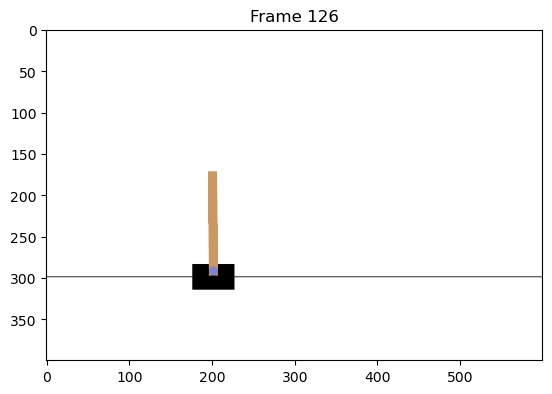

[-0.78077674 -0.31291986 -0.00679666 -0.34183687] [-0.78703517 -0.50794446 -0.0136334  -0.05130494] 0
New state:  [-0.78703517 -0.50794446 -0.0136334  -0.05130494] Reward:  1.0 Terminated:  False Truncated:  False


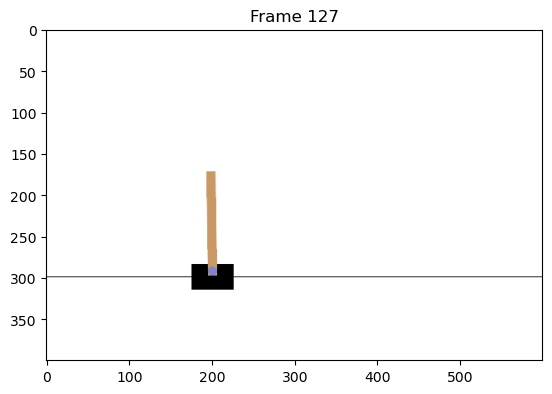

[-0.78703517 -0.50794446 -0.0136334  -0.05130494] [-0.79719406 -0.3126297  -0.0146595  -0.34825793] 1
New state:  [-0.79719406 -0.3126297  -0.0146595  -0.34825793] Reward:  1.0 Terminated:  False Truncated:  False


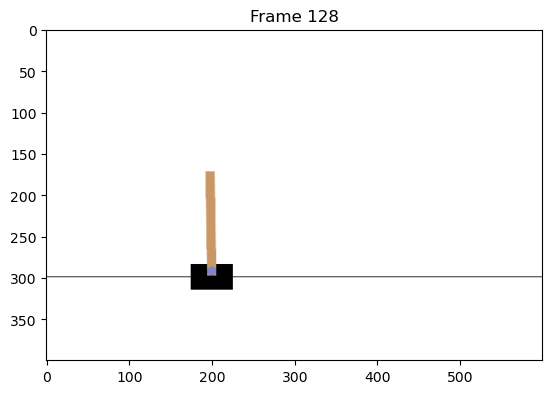

[-0.79719406 -0.3126297  -0.0146595  -0.34825793] [-0.80344665 -0.5075401  -0.02162465 -0.06023347] 0
New state:  [-0.80344665 -0.5075401  -0.02162465 -0.06023347] Reward:  1.0 Terminated:  False Truncated:  False


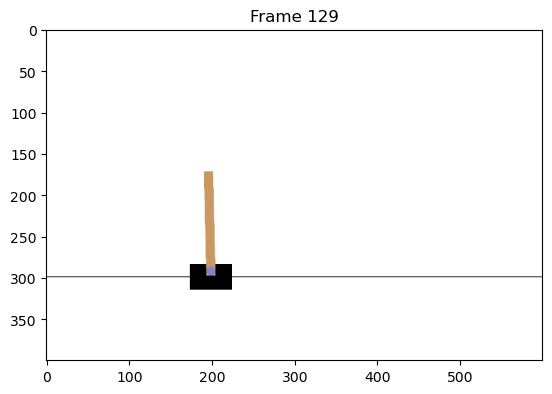

[-0.80344665 -0.5075401  -0.02162465 -0.06023347] [-0.81359744 -0.70234543 -0.02282932  0.22554904] 0
New state:  [-0.81359744 -0.70234543 -0.02282932  0.22554904] Reward:  1.0 Terminated:  False Truncated:  False


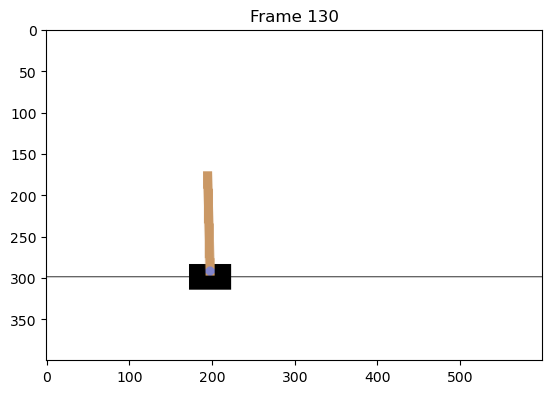

[-0.81359744 -0.70234543 -0.02282932  0.22554904] [-0.82764435 -0.5069048  -0.01831834 -0.07424679] 1
New state:  [-0.82764435 -0.5069048  -0.01831834 -0.07424679] Reward:  1.0 Terminated:  False Truncated:  False


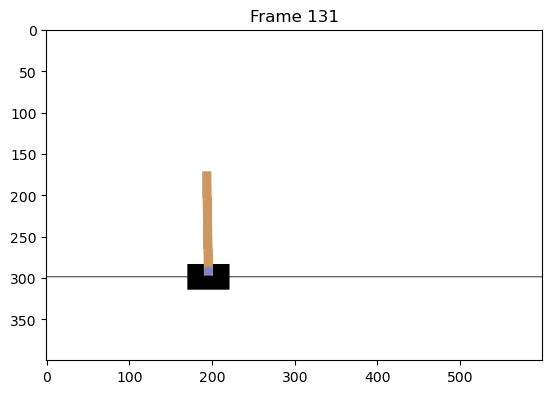

[-0.82764435 -0.5069048  -0.01831834 -0.07424679] [-0.83778244 -0.7017594  -0.01980328  0.2126008 ] 0
New state:  [-0.83778244 -0.7017594  -0.01980328  0.2126008 ] Reward:  1.0 Terminated:  False Truncated:  False


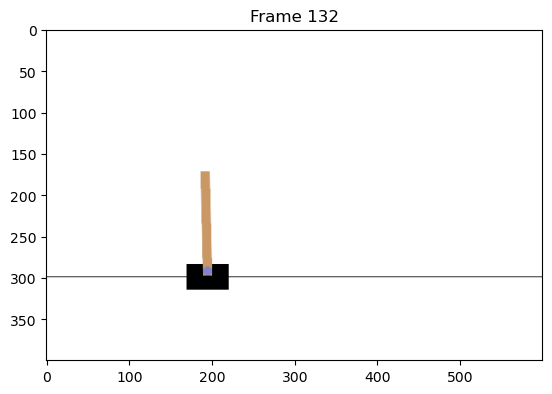

[-0.83778244 -0.7017594  -0.01980328  0.2126008 ] [-0.8518176  -0.50636    -0.01555126 -0.08626261] 1
New state:  [-0.8518176  -0.50636    -0.01555126 -0.08626261] Reward:  1.0 Terminated:  False Truncated:  False


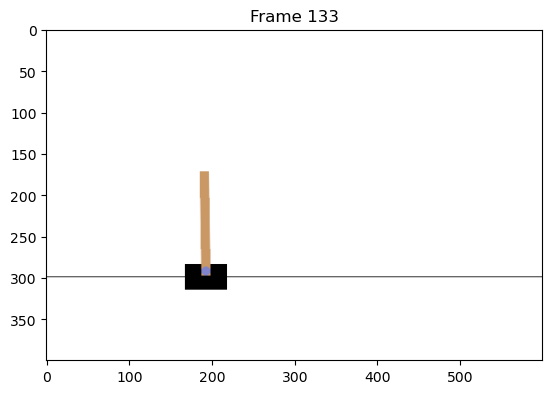

[-0.8518176  -0.50636    -0.01555126 -0.08626261] [-0.8619448  -0.7012556  -0.01727651  0.20147358] 0
New state:  [-0.8619448  -0.7012556  -0.01727651  0.20147358] Reward:  1.0 Terminated:  False Truncated:  False


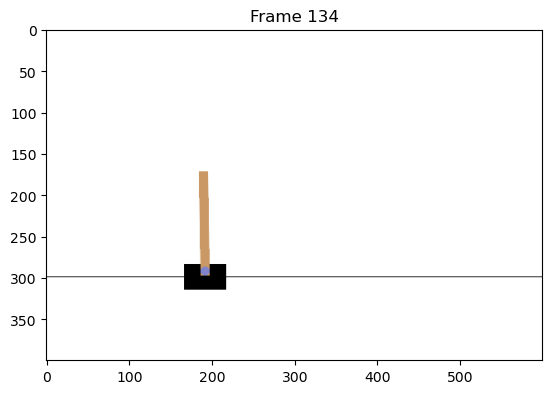

[-0.8619448  -0.7012556  -0.01727651  0.20147358] [-0.87596995 -0.5058909  -0.01324704 -0.09660881] 1
New state:  [-0.87596995 -0.5058909  -0.01324704 -0.09660881] Reward:  1.0 Terminated:  False Truncated:  False


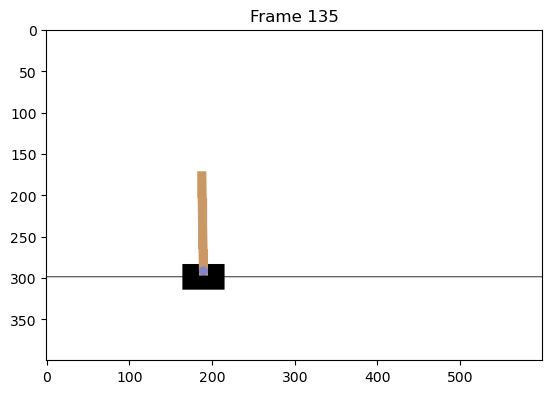

[-0.87596995 -0.5058909  -0.01324704 -0.09660881] [-0.8860878  -0.7008205  -0.01517922  0.19186543] 0
New state:  [-0.8860878  -0.7008205  -0.01517922  0.19186543] Reward:  1.0 Terminated:  False Truncated:  False


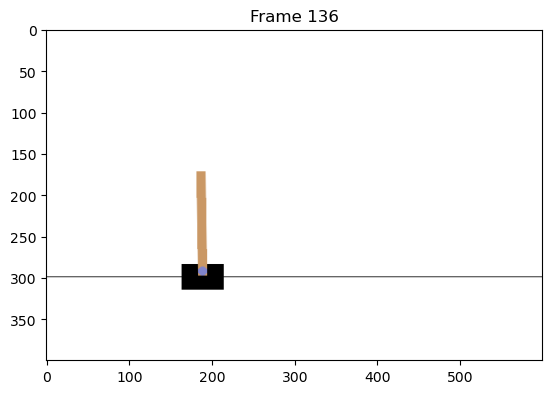

[-0.8860878  -0.7008205  -0.01517922  0.19186543] [-0.90010417 -0.5054847  -0.01134191 -0.10556699] 1
New state:  [-0.90010417 -0.5054847  -0.01134191 -0.10556699] Reward:  1.0 Terminated:  False Truncated:  False


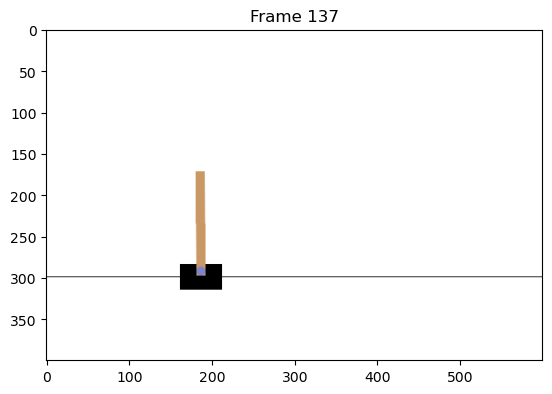

[-0.90010417 -0.5054847  -0.01134191 -0.10556699] [-0.9102138  -0.7004423  -0.01345325  0.18351614] 0
New state:  [-0.9102138  -0.7004423  -0.01345325  0.18351614] Reward:  1.0 Terminated:  False Truncated:  False


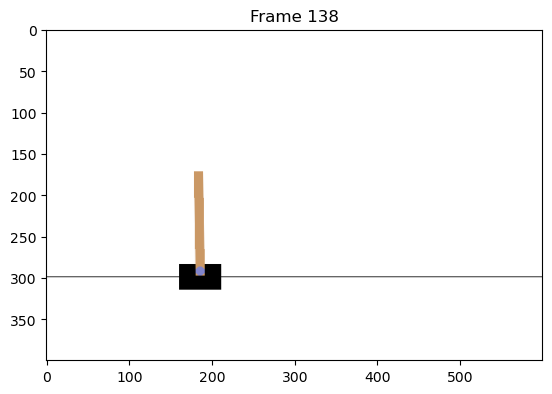

[-0.9102138  -0.7004423  -0.01345325  0.18351614] [-0.9242227  -0.50513047 -0.00978293 -0.11338024] 1
New state:  [-0.9242227  -0.50513047 -0.00978293 -0.11338024] Reward:  1.0 Terminated:  False Truncated:  False


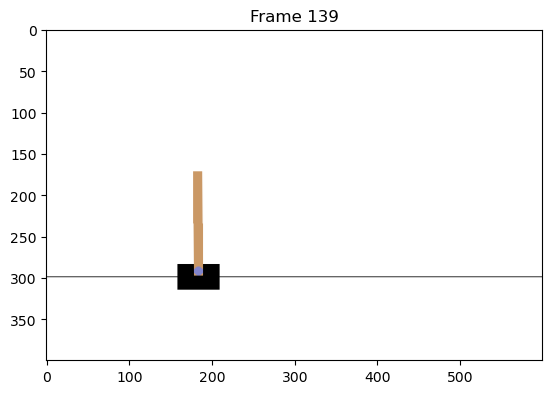

[-0.9242227  -0.50513047 -0.00978293 -0.11338024] [-0.93432534 -0.7001109  -0.01205053  0.17620026] 0
New state:  [-0.93432534 -0.7001109  -0.01205053  0.17620026] Reward:  1.0 Terminated:  False Truncated:  False


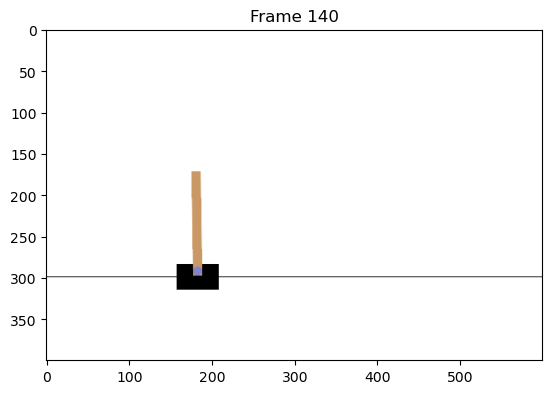

[-0.93432534 -0.7001109  -0.01205053  0.17620026] [-0.94832754 -0.50481856 -0.00852653 -0.12025972] 1
New state:  [-0.94832754 -0.50481856 -0.00852653 -0.12025972] Reward:  1.0 Terminated:  False Truncated:  False


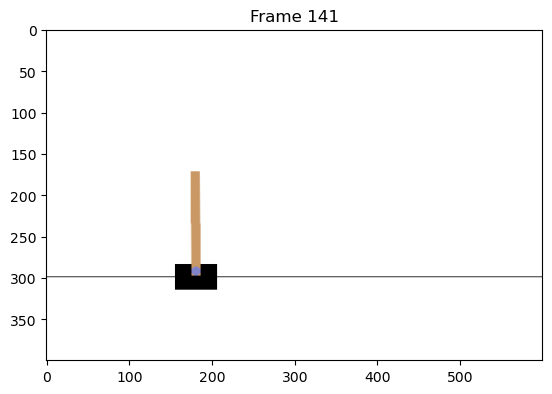

[-0.94832754 -0.50481856 -0.00852653 -0.12025972] [-0.9584239  -0.69981736 -0.01093172  0.169721  ] 0
New state:  [-0.9584239  -0.69981736 -0.01093172  0.169721  ] Reward:  1.0 Terminated:  False Truncated:  False


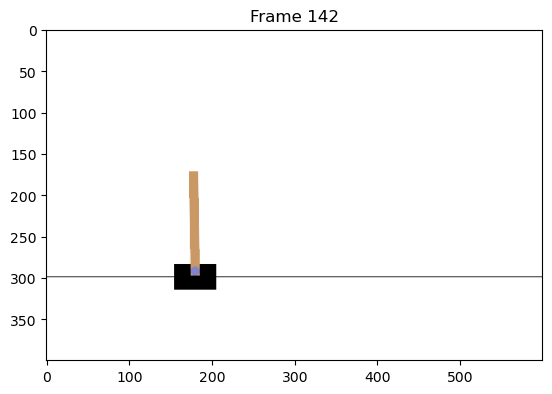

[-0.9584239  -0.69981736 -0.01093172  0.169721  ] [-0.9724203 -0.5045406 -0.0075373 -0.1263904] 1
New state:  [-0.9724203 -0.5045406 -0.0075373 -0.1263904] Reward:  1.0 Terminated:  False Truncated:  False


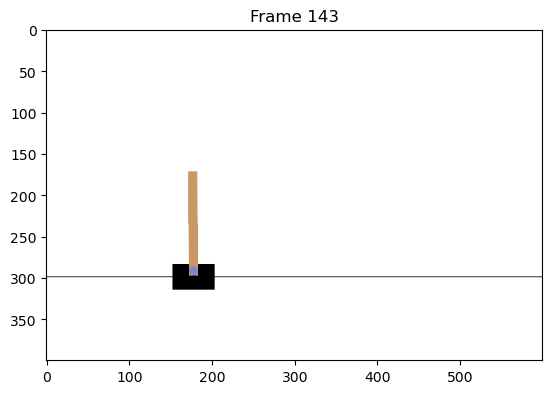

[-0.9724203 -0.5045406 -0.0075373 -0.1263904] [-0.98251104 -0.6995538  -0.01006511  0.1639051 ] 0
New state:  [-0.98251104 -0.6995538  -0.01006511  0.1639051 ] Reward:  1.0 Terminated:  False Truncated:  False


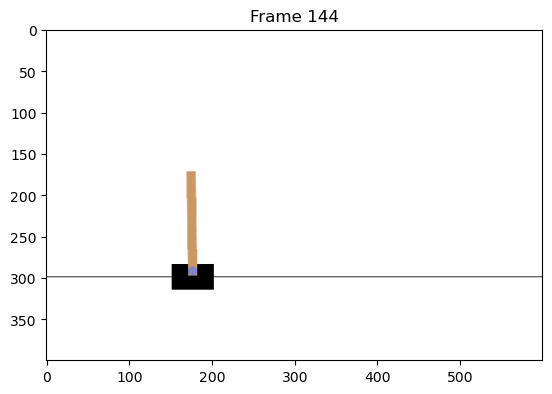

[-0.98251104 -0.6995538  -0.01006511  0.1639051 ] [-0.99650216 -0.5042892  -0.00678701 -0.13193603] 1
New state:  [-0.99650216 -0.5042892  -0.00678701 -0.13193603] Reward:  1.0 Terminated:  False Truncated:  False


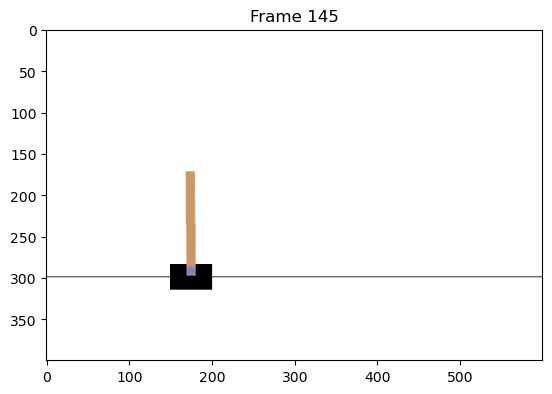

[-0.99650216 -0.5042892  -0.00678701 -0.13193603] [-1.006588   -0.6993133  -0.00942573  0.15859798] 0
New state:  [-1.006588   -0.6993133  -0.00942573  0.15859798] Reward:  1.0 Terminated:  False Truncated:  False


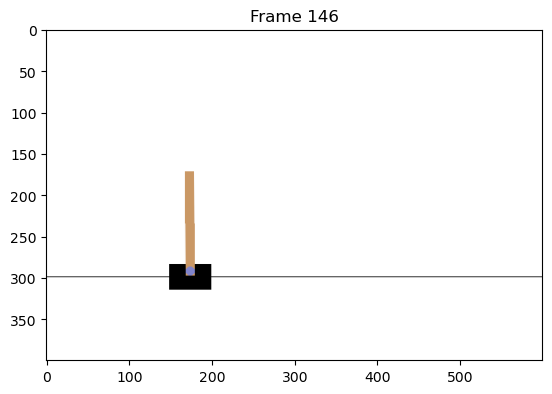

[-1.006588   -0.6993133  -0.00942573  0.15859798] [-1.0205742  -0.5040577  -0.00625377 -0.13704357] 1
New state:  [-1.0205742  -0.5040577  -0.00625377 -0.13704357] Reward:  1.0 Terminated:  False Truncated:  False


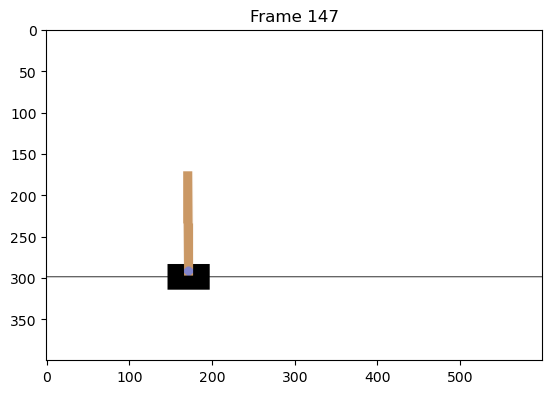

[-1.0205742  -0.5040577  -0.00625377 -0.13704357] [-1.0306554  -0.6990895  -0.00899464  0.15365985] 0
New state:  [-1.0306554  -0.6990895  -0.00899464  0.15365985] Reward:  1.0 Terminated:  False Truncated:  False


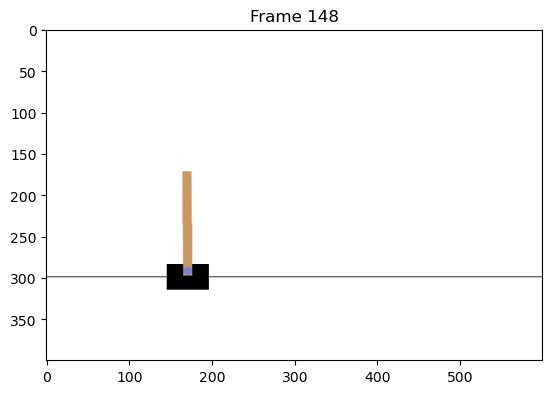

[-1.0306554  -0.6990895  -0.00899464  0.15365985] [-1.0446371  -0.5038399  -0.00592144 -0.14184706] 1
New state:  [-1.0446371  -0.5038399  -0.00592144 -0.14184706] Reward:  1.0 Terminated:  False Truncated:  False


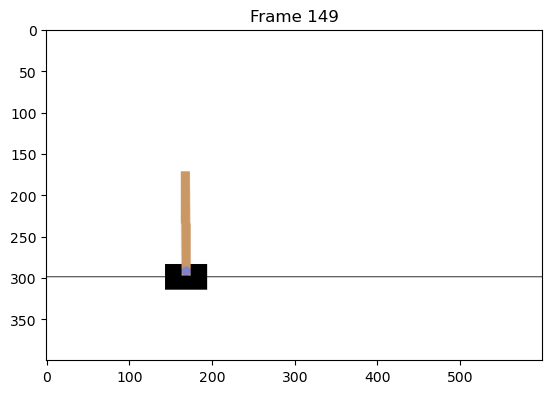

[-1.0446371  -0.5038399  -0.00592144 -0.14184706] [-1.054714   -0.69887656 -0.00875838  0.14896189] 0
New state:  [-1.054714   -0.69887656 -0.00875838  0.14896189] Reward:  1.0 Terminated:  False Truncated:  False


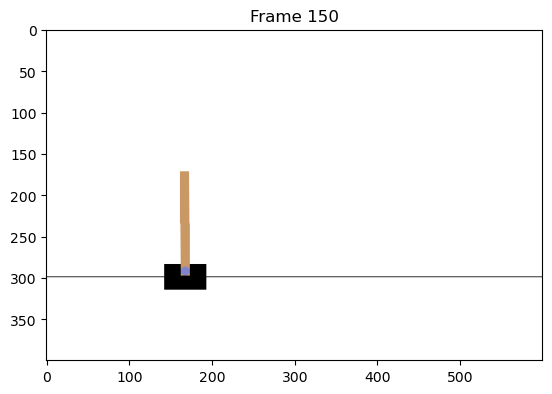

[-1.054714   -0.69887656 -0.00875838  0.14896189] [-1.0686915  -0.5036303  -0.00577915 -0.1464712 ] 1
New state:  [-1.0686915  -0.5036303  -0.00577915 -0.1464712 ] Reward:  1.0 Terminated:  False Truncated:  False


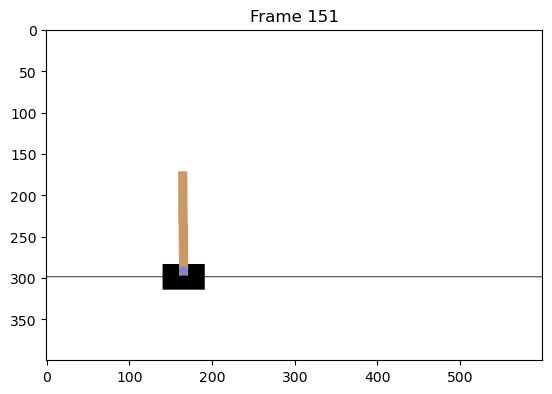

[-1.0686915  -0.5036303  -0.00577915 -0.1464712 ] [-1.0787641  -0.698669   -0.00870857  0.14438292] 0
New state:  [-1.0787641  -0.698669   -0.00870857  0.14438292] Reward:  1.0 Terminated:  False Truncated:  False


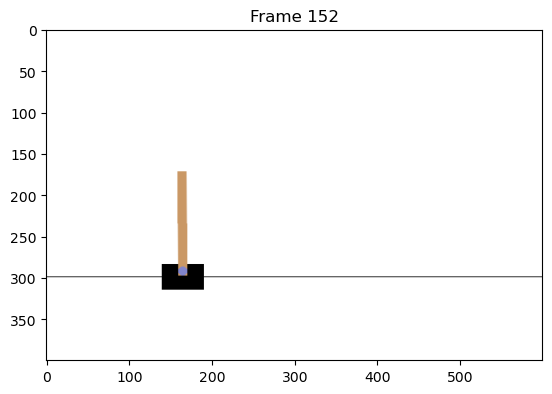

[-1.0787641  -0.698669   -0.00870857  0.14438292] [-1.0927374  -0.50342345 -0.00582091 -0.15103462] 1
New state:  [-1.0927374  -0.50342345 -0.00582091 -0.15103462] Reward:  1.0 Terminated:  False Truncated:  False


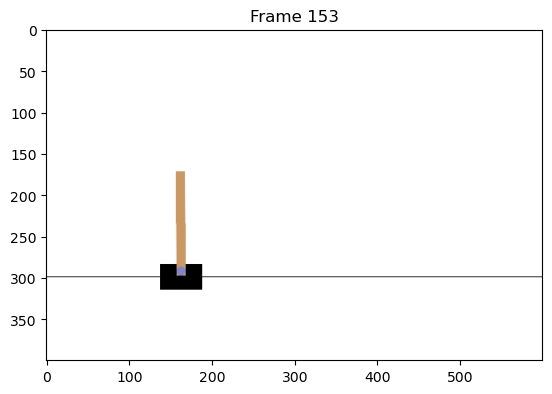

[-1.0927374  -0.50342345 -0.00582091 -0.15103462] [-1.102806   -0.69846153 -0.0088416   0.13980626] 0
New state:  [-1.102806   -0.69846153 -0.0088416   0.13980626] Reward:  1.0 Terminated:  False Truncated:  False


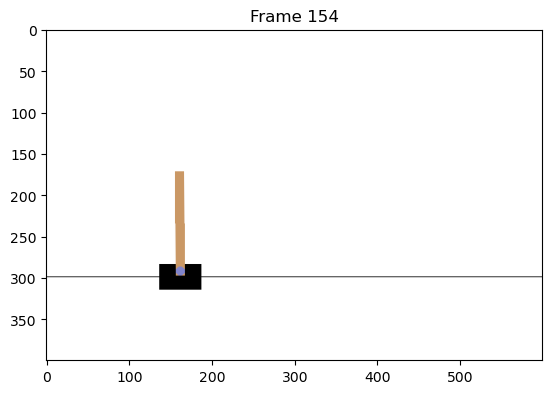

[-1.102806   -0.69846153 -0.0088416   0.13980626] [-1.1167752  -0.5032141  -0.00604548 -0.15565288] 1
New state:  [-1.1167752  -0.5032141  -0.00604548 -0.15565288] Reward:  1.0 Terminated:  False Truncated:  False


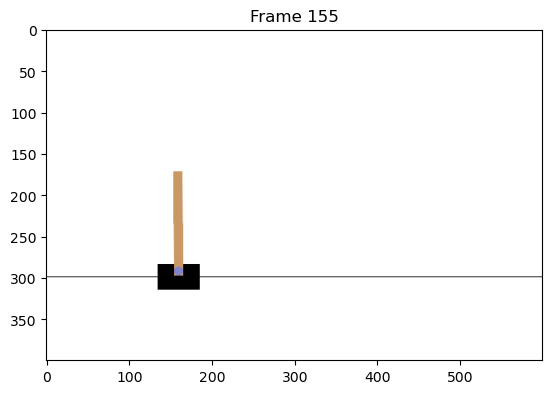

[-1.1167752  -0.5032141  -0.00604548 -0.15565288] [-1.1268394  -0.698249   -0.00915854  0.13511671] 0
New state:  [-1.1268394  -0.698249   -0.00915854  0.13511671] Reward:  1.0 Terminated:  False Truncated:  False


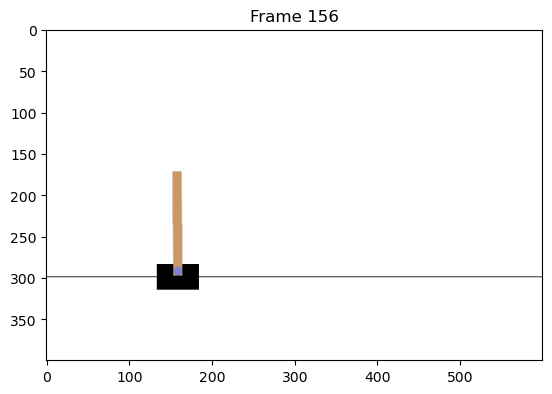

[-1.1268394  -0.698249   -0.00915854  0.13511671] [-1.1408044  -0.50299704 -0.0064562  -0.16044146] 1
New state:  [-1.1408044  -0.50299704 -0.0064562  -0.16044146] Reward:  1.0 Terminated:  False Truncated:  False


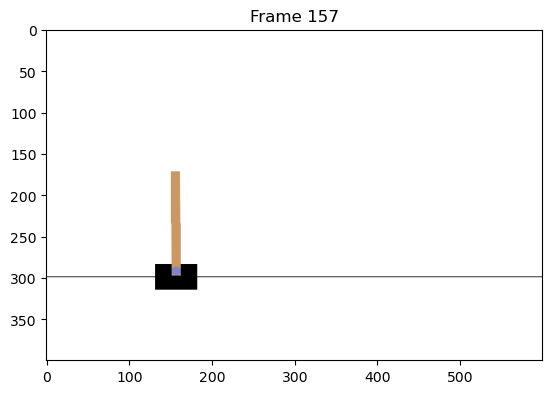

[-1.1408044  -0.50299704 -0.0064562  -0.16044146] [-1.1508644  -0.698026   -0.00966503  0.13019772] 0
New state:  [-1.1508644  -0.698026   -0.00966503  0.13019772] Reward:  1.0 Terminated:  False Truncated:  False


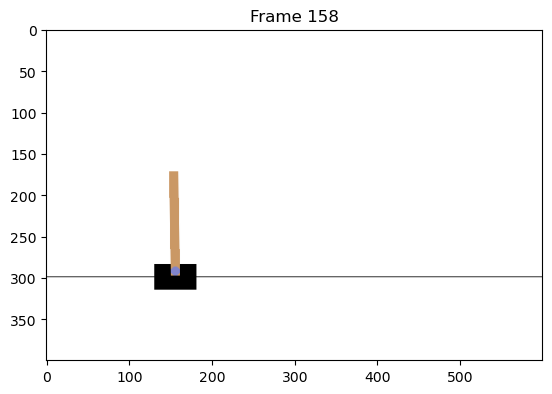

[-1.1508644  -0.698026   -0.00966503  0.13019772] [-1.1648248  -0.5027669  -0.00706108 -0.16551866] 1
New state:  [-1.1648248  -0.5027669  -0.00706108 -0.16551866] Reward:  1.0 Terminated:  False Truncated:  False


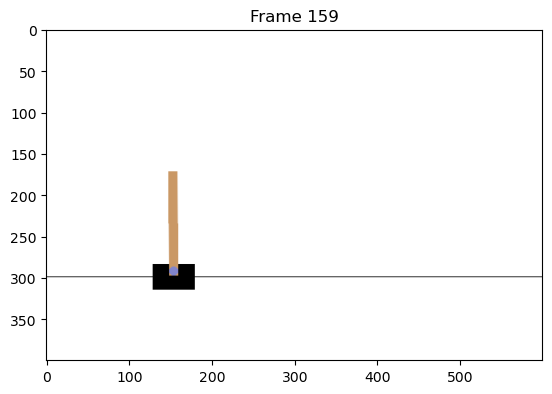

[-1.1648248  -0.5027669  -0.00706108 -0.16551866] [-1.1748803  -0.6977871  -0.01037145  0.12492836] 0
New state:  [-1.1748803  -0.6977871  -0.01037145  0.12492836] Reward:  1.0 Terminated:  False Truncated:  False


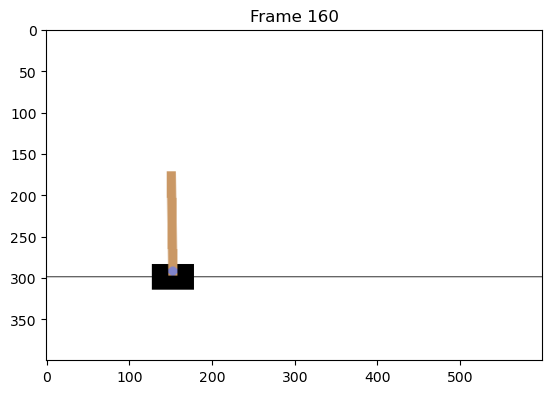

[-1.1748803  -0.6977871  -0.01037145  0.12492836] [-1.188836   -0.5025181  -0.00787288 -0.17100853] 1
New state:  [-1.188836   -0.5025181  -0.00787288 -0.17100853] Reward:  1.0 Terminated:  False Truncated:  False


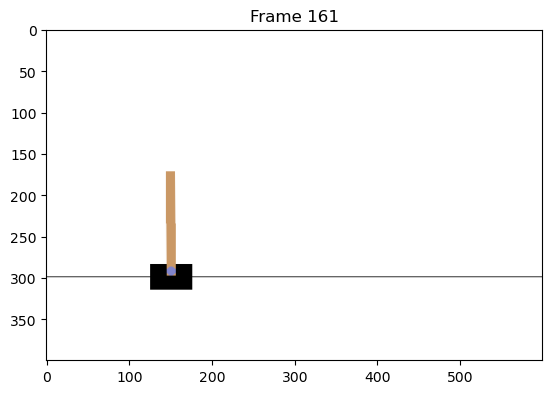

[-1.188836   -0.5025181  -0.00787288 -0.17100853] [-1.1988863  -0.69752645 -0.01129305  0.11918039] 0
New state:  [-1.1988863  -0.69752645 -0.01129305  0.11918039] Reward:  1.0 Terminated:  False Truncated:  False


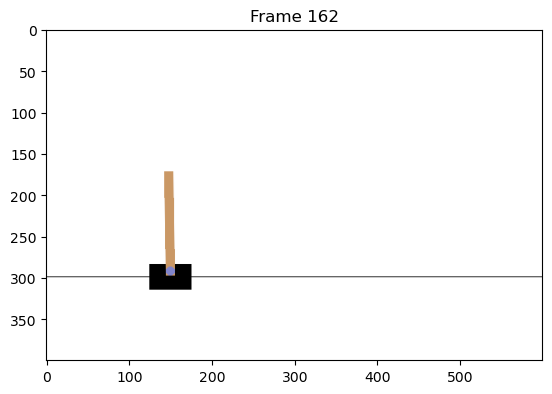

[-1.1988863  -0.69752645 -0.01129305  0.11918039] [-1.2128369  -0.5022446  -0.00890945 -0.1770439 ] 1
New state:  [-1.2128369  -0.5022446  -0.00890945 -0.1770439 ] Reward:  1.0 Terminated:  False Truncated:  False


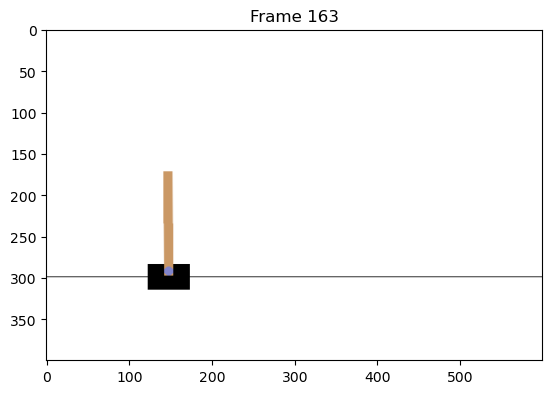

[-1.2128369  -0.5022446  -0.00890945 -0.1770439 ] [-1.2228817  -0.6972379  -0.01245032  0.11281513] 0
New state:  [-1.2228817  -0.6972379  -0.01245032  0.11281513] Reward:  1.0 Terminated:  False Truncated:  False


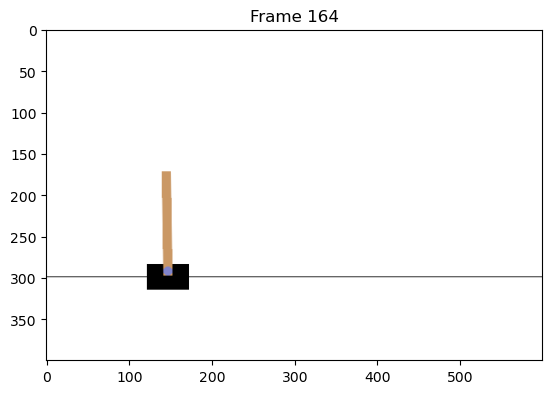

[-1.2228817  -0.6972379  -0.01245032  0.11281513] [-1.2368265  -0.5019398  -0.01019402 -0.18376964] 1
New state:  [-1.2368265  -0.5019398  -0.01019402 -0.18376964] Reward:  1.0 Terminated:  False Truncated:  False


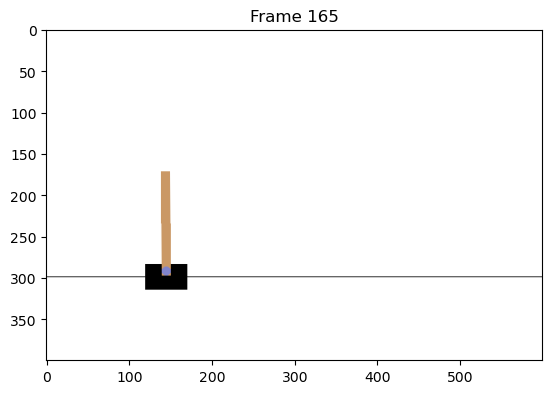

[-1.2368265  -0.5019398  -0.01019402 -0.18376964] [-1.2468653  -0.6969144  -0.01386941  0.1056801 ] 0
New state:  [-1.2468653  -0.6969144  -0.01386941  0.1056801 ] Reward:  1.0 Terminated:  False Truncated:  False


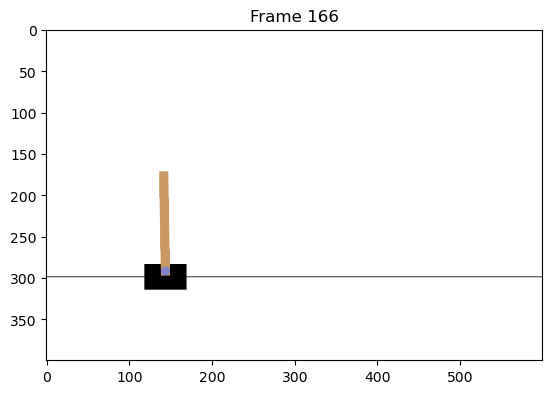

[-1.2468653  -0.6969144  -0.01386941  0.1056801 ] [-1.2608036  -0.50159645 -0.01175581 -0.1913461 ] 1
New state:  [-1.2608036  -0.50159645 -0.01175581 -0.1913461 ] Reward:  1.0 Terminated:  False Truncated:  False


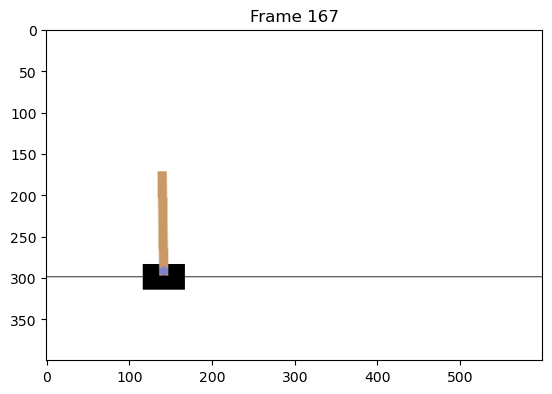

[-1.2608036  -0.50159645 -0.01175581 -0.1913461 ] [-1.2708355  -0.6965483  -0.01558273  0.0976053 ] 0
New state:  [-1.2708355  -0.6965483  -0.01558273  0.0976053 ] Reward:  1.0 Terminated:  False Truncated:  False


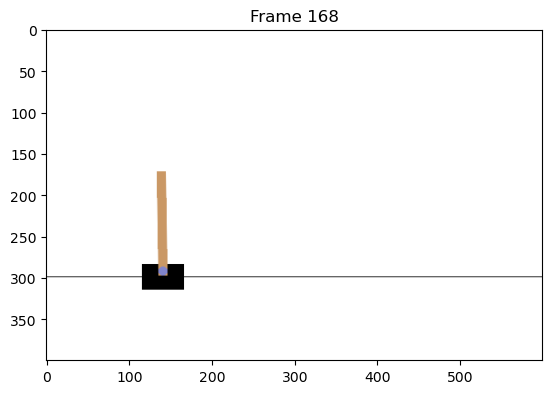

[-1.2708355  -0.6965483  -0.01558273  0.0976053 ] [-1.2847664  -0.5012065  -0.01363063 -0.19995293] 1
New state:  [-1.2847664  -0.5012065  -0.01363063 -0.19995293] Reward:  1.0 Terminated:  False Truncated:  False


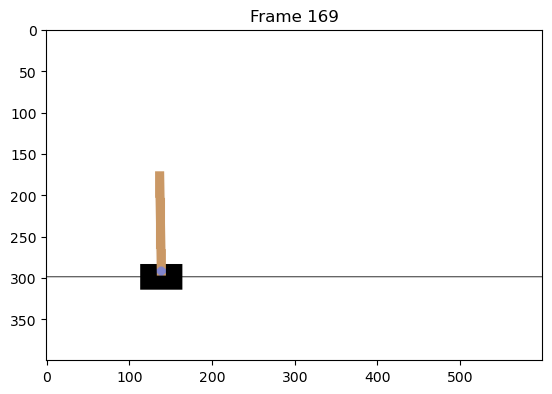

[-1.2847664  -0.5012065  -0.01363063 -0.19995293] [-1.2947906  -0.6961309  -0.01762969  0.08839918] 0
New state:  [-1.2947906  -0.6961309  -0.01762969  0.08839918] Reward:  1.0 Terminated:  False Truncated:  False


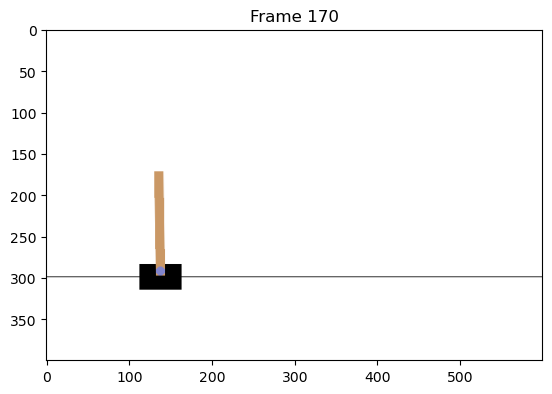

[-1.2947906  -0.6961309  -0.01762969  0.08839918] [-1.3087132  -0.50076073 -0.0158617  -0.20979337] 1
New state:  [-1.3087132  -0.50076073 -0.0158617  -0.20979337] Reward:  1.0 Terminated:  False Truncated:  False


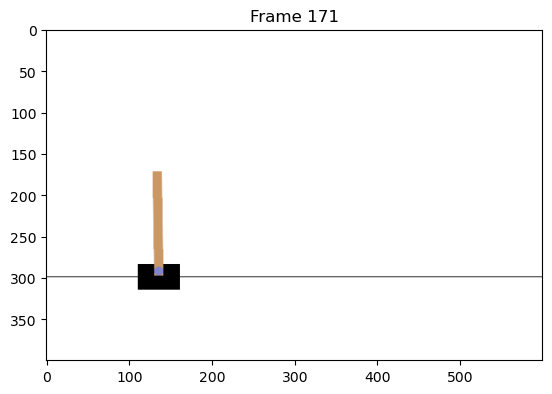

[-1.3087132  -0.50076073 -0.0158617  -0.20979337] [-1.3187284  -0.6956523  -0.02005757  0.07784411] 0
New state:  [-1.3187284  -0.6956523  -0.02005757  0.07784411] Reward:  1.0 Terminated:  False Truncated:  False


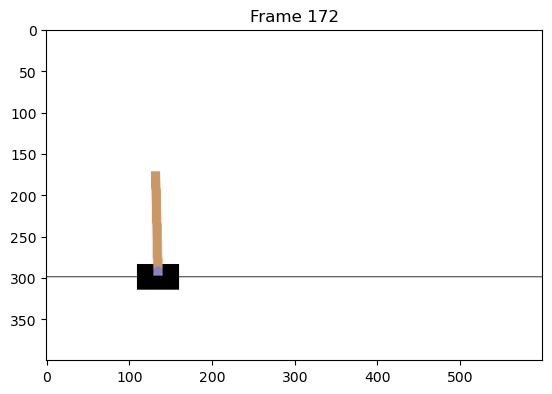

[-1.3187284  -0.6956523  -0.02005757  0.07784411] [-1.3326415  -0.5002487  -0.01850069 -0.22109894] 1
New state:  [-1.3326415  -0.5002487  -0.01850069 -0.22109894] Reward:  1.0 Terminated:  False Truncated:  False


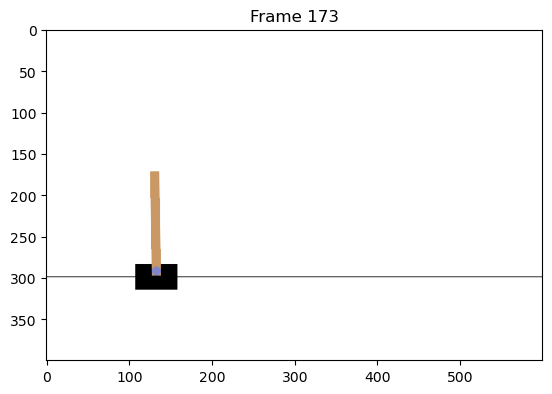

[-1.3326415  -0.5002487  -0.01850069 -0.22109894] [-1.3426465  -0.6951013  -0.02292267  0.06569117] 0
New state:  [-1.3426465  -0.6951013  -0.02292267  0.06569117] Reward:  1.0 Terminated:  False Truncated:  False


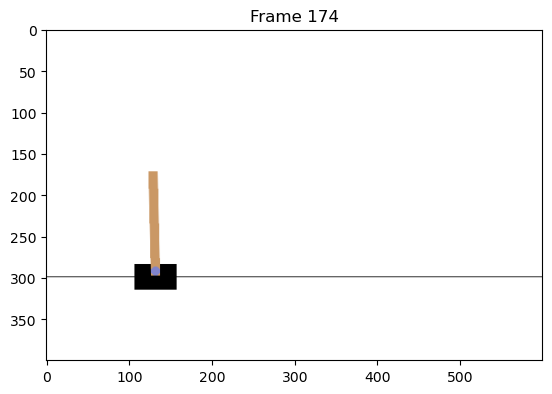

[-1.3426465  -0.6951013  -0.02292267  0.06569117] [-1.3565484  -0.49965838 -0.02160884 -0.23413494] 1
New state:  [-1.3565484  -0.49965838 -0.02160884 -0.23413494] Reward:  1.0 Terminated:  False Truncated:  False


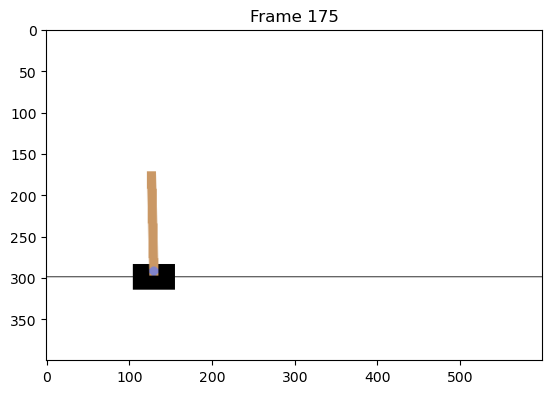

[-1.3565484  -0.49965838 -0.02160884 -0.23413494] [-1.3665416  -0.69446504 -0.02629154  0.0516543 ] 0
New state:  [-1.3665416  -0.69446504 -0.02629154  0.0516543 ] Reward:  1.0 Terminated:  False Truncated:  False


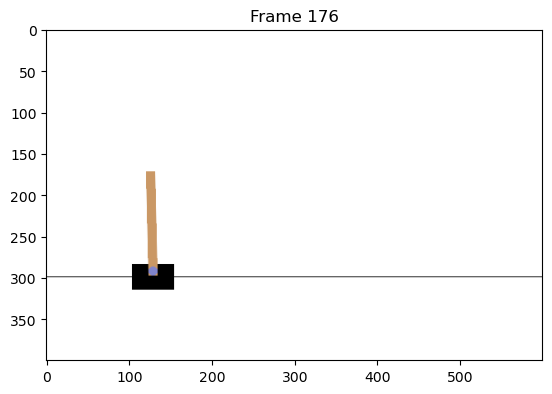

[-1.3665416  -0.69446504 -0.02629154  0.0516543 ] [-1.3804309  -0.49897614 -0.02525846 -0.2492065 ] 1
New state:  [-1.3804309  -0.49897614 -0.02525846 -0.2492065 ] Reward:  1.0 Terminated:  False Truncated:  False


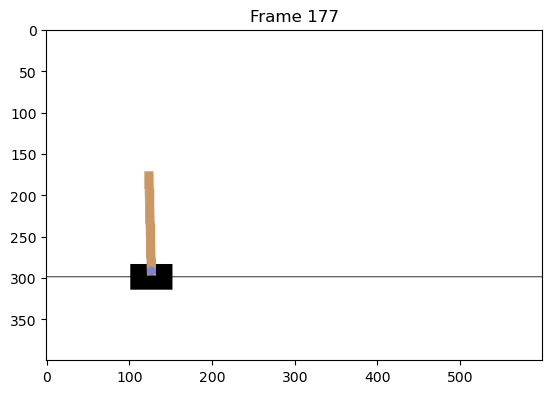

[-1.3804309  -0.49897614 -0.02525846 -0.2492065 ] [-1.3904104  -0.69372845 -0.03024259  0.03540357] 0
New state:  [-1.3904104  -0.69372845 -0.03024259  0.03540357] Reward:  1.0 Terminated:  False Truncated:  False


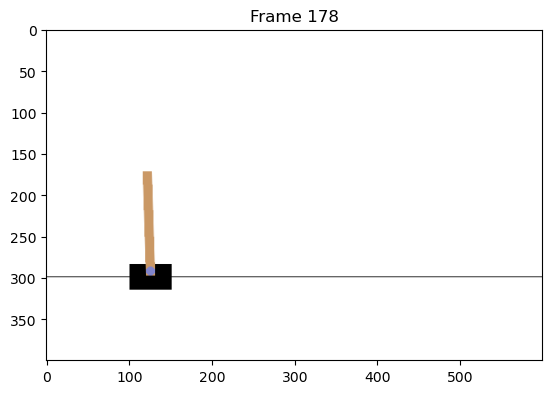

[-1.3904104  -0.69372845 -0.03024259  0.03540357] [-1.4042851  -0.49818614 -0.02953451 -0.2666657 ] 1
New state:  [-1.4042851  -0.49818614 -0.02953451 -0.2666657 ] Reward:  1.0 Terminated:  False Truncated:  False


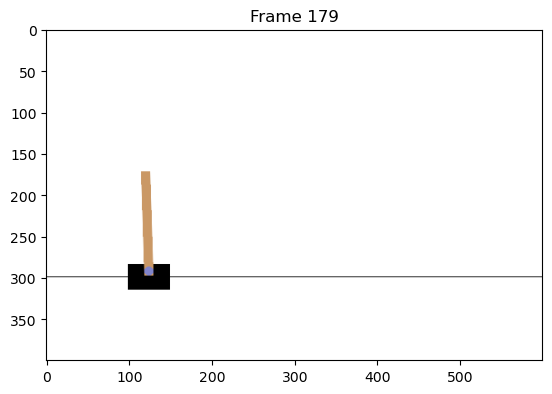

[-1.4042851  -0.49818614 -0.02953451 -0.2666657 ] [-1.4142487  -0.6928744  -0.03486783  0.01655743] 0
New state:  [-1.4142487  -0.6928744  -0.03486783  0.01655743] Reward:  1.0 Terminated:  False Truncated:  False


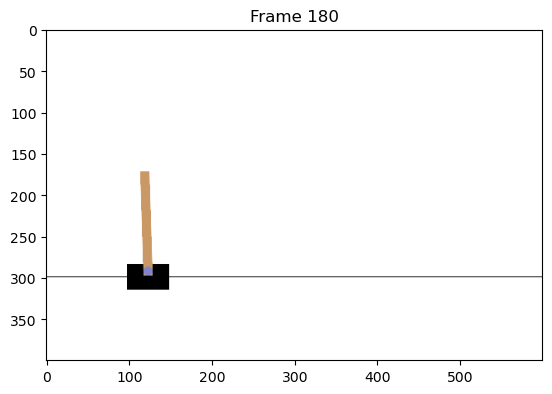

[-1.4142487  -0.6928744  -0.03486783  0.01655743] [-1.4281062  -0.4972702  -0.03453668 -0.2869196 ] 1
New state:  [-1.4281062  -0.4972702  -0.03453668 -0.2869196 ] Reward:  1.0 Terminated:  False Truncated:  False


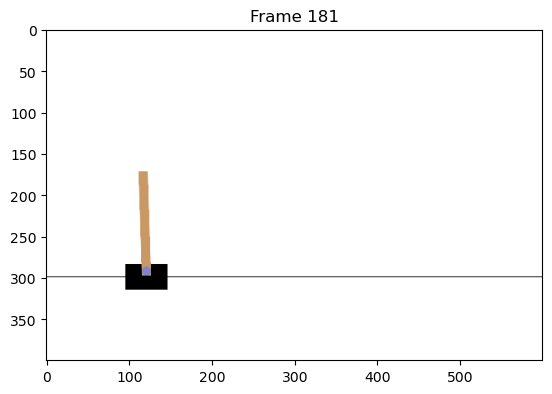

[-1.4281062  -0.4972702  -0.03453668 -0.2869196 ] [-1.4380517  -0.691883   -0.04027507 -0.00532619] 0
New state:  [-1.4380517  -0.691883   -0.04027507 -0.00532619] Reward:  1.0 Terminated:  False Truncated:  False


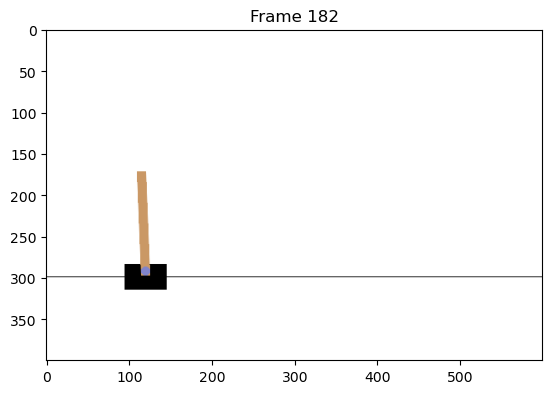

[-1.4380517  -0.691883   -0.04027507 -0.00532619] [-1.4518893  -0.49620733 -0.0403816  -0.3104394 ] 1
New state:  [-1.4518893  -0.49620733 -0.0403816  -0.3104394 ] Reward:  1.0 Terminated:  False Truncated:  False


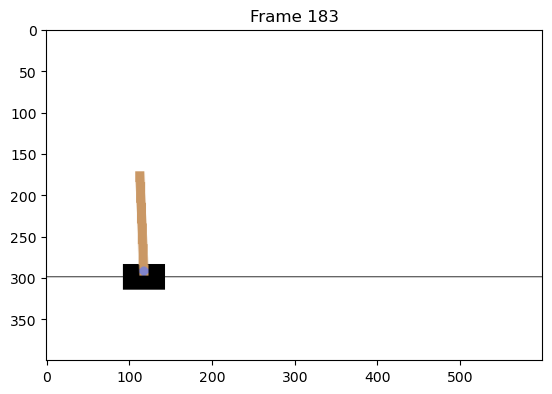

[-1.4518893  -0.49620733 -0.0403816  -0.3104394 ] [-1.4618134  -0.69073135 -0.04659038 -0.03076018] 0
New state:  [-1.4618134  -0.69073135 -0.04659038 -0.03076018] Reward:  1.0 Terminated:  False Truncated:  False


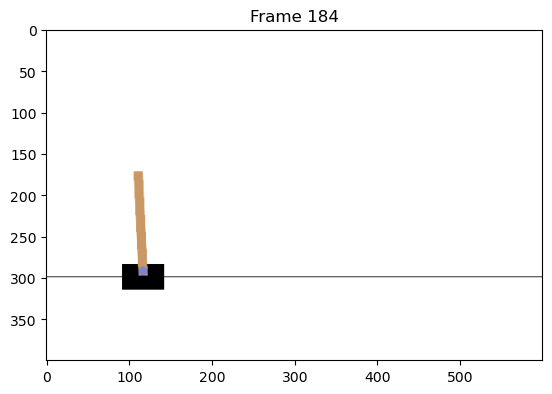

[-1.4618134  -0.69073135 -0.04659038 -0.03076018] [-1.4756281  -0.49497333 -0.04720559 -0.33777124] 1
New state:  [-1.4756281  -0.49497333 -0.04720559 -0.33777124] Reward:  1.0 Terminated:  False Truncated:  False


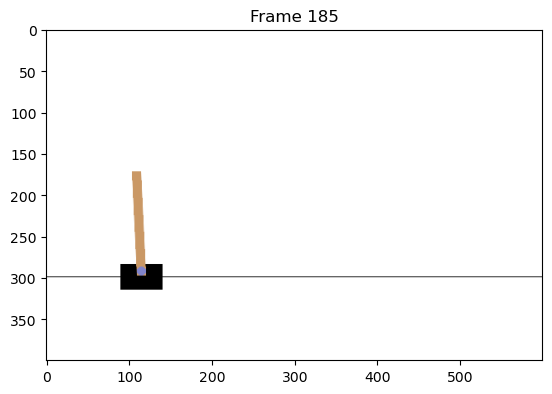

[-1.4756281  -0.49497333 -0.04720559 -0.33777124] [-1.4855275  -0.68939286 -0.05396101 -0.06034008] 0
New state:  [-1.4855275  -0.68939286 -0.05396101 -0.06034008] Reward:  1.0 Terminated:  False Truncated:  False


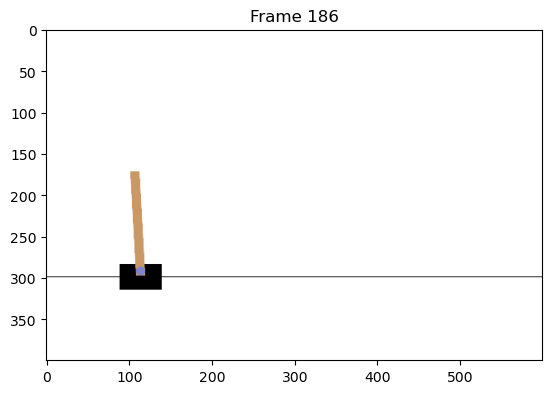

[-1.4855275  -0.68939286 -0.05396101 -0.06034008] [-1.4993154  -0.4935404  -0.05516782 -0.369548  ] 1
New state:  [-1.4993154  -0.4935404  -0.05516782 -0.369548  ] Reward:  1.0 Terminated:  False Truncated:  False


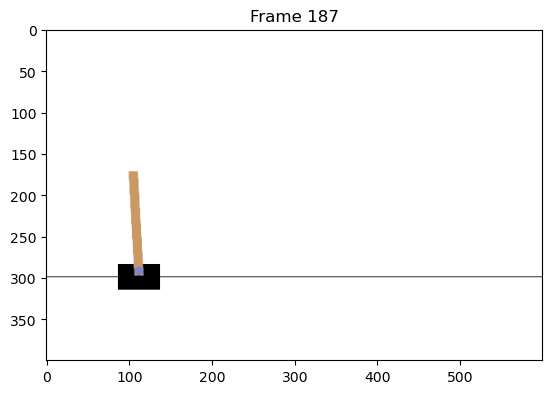

[-1.4993154  -0.4935404  -0.05516782 -0.369548  ] [-1.5091863  -0.6878369  -0.06255878 -0.09475777] 0
New state:  [-1.5091863  -0.6878369  -0.06255878 -0.09475777] Reward:  1.0 Terminated:  False Truncated:  False


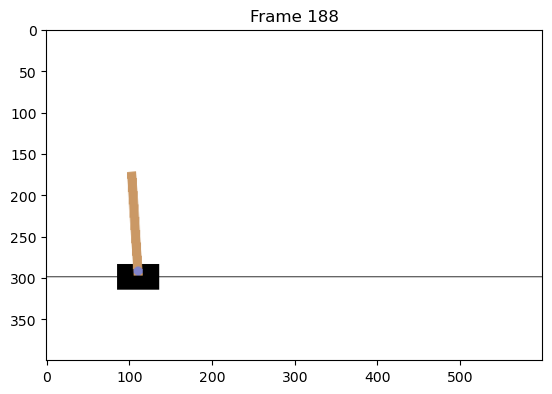

[-1.5091863  -0.6878369  -0.06255878 -0.09475777] [-1.5229429  -0.4918767  -0.06445393 -0.40650335] 1
New state:  [-1.5229429  -0.4918767  -0.06445393 -0.40650335] Reward:  1.0 Terminated:  False Truncated:  False


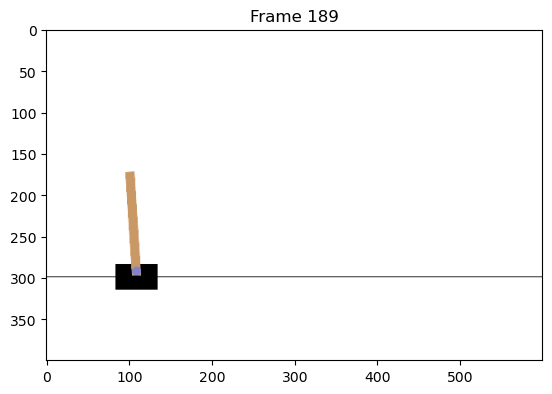

[-1.5229429  -0.4918767  -0.06445393 -0.40650335] [-1.5327805  -0.6860283  -0.072584   -0.13481702] 0
New state:  [-1.5327805  -0.6860283  -0.072584   -0.13481702] Reward:  1.0 Terminated:  False Truncated:  False


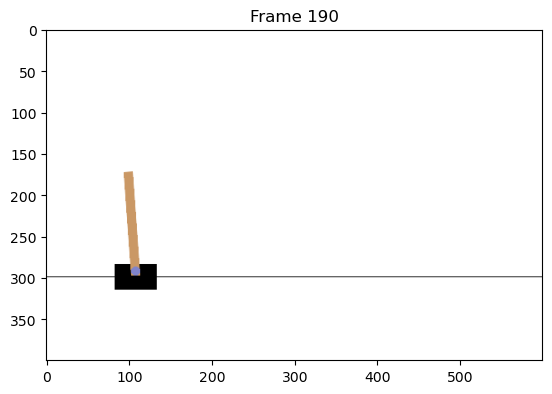

[-1.5327805  -0.6860283  -0.072584   -0.13481702] [-1.546501   -0.8800396  -0.07528034  0.13411266] 0
New state:  [-1.546501   -0.8800396  -0.07528034  0.13411266] Reward:  1.0 Terminated:  False Truncated:  False


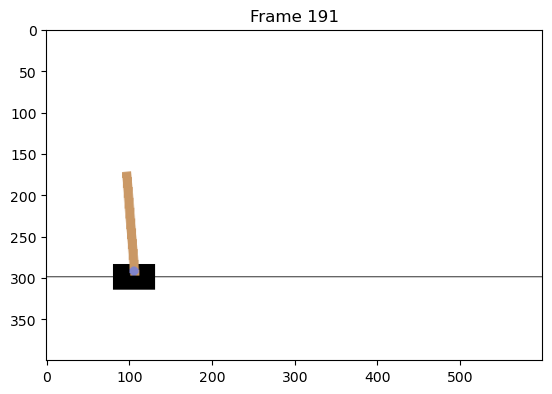

[-1.546501   -0.8800396  -0.07528034  0.13411266] [-1.5641018  -0.68392456 -0.07259808 -0.18133824] 1
New state:  [-1.5641018  -0.68392456 -0.07259808 -0.18133824] Reward:  1.0 Terminated:  False Truncated:  False


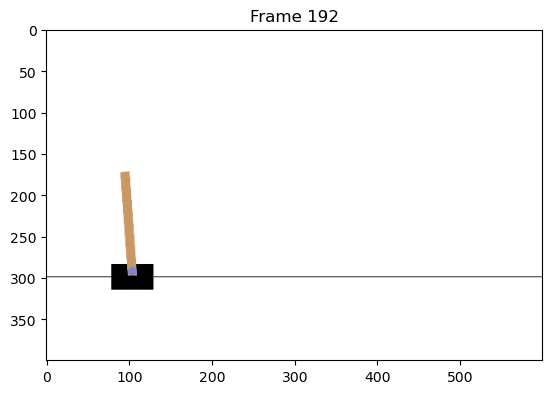

[-1.5641018  -0.68392456 -0.07259808 -0.18133824] [-1.5777804  -0.8779366  -0.07622485  0.08758823] 0
New state:  [-1.5777804  -0.8779366  -0.07622485  0.08758823] Reward:  1.0 Terminated:  False Truncated:  False


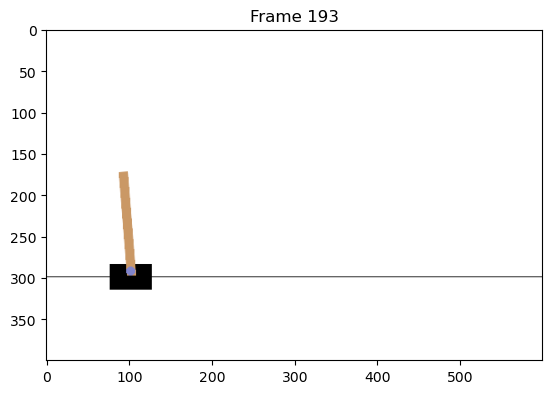

[-1.5777804  -0.8779366  -0.07622485  0.08758823] [-1.5953391  -0.6818095  -0.07447308 -0.2281366 ] 1
New state:  [-1.5953391  -0.6818095  -0.07447308 -0.2281366 ] Reward:  1.0 Terminated:  False Truncated:  False


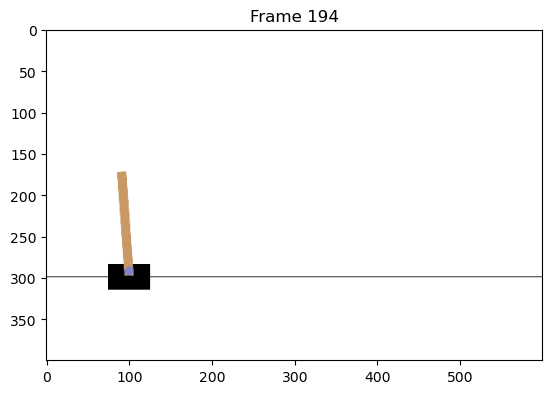

[-1.5953391  -0.6818095  -0.07447308 -0.2281366 ] [-1.6089753  -0.87579256 -0.07903582  0.04015658] 0
New state:  [-1.6089753  -0.87579256 -0.07903582  0.04015658] Reward:  1.0 Terminated:  False Truncated:  False


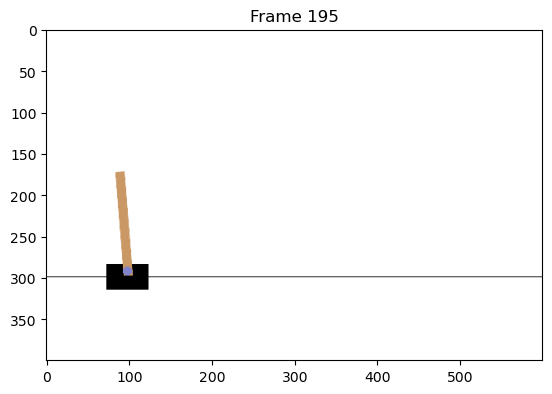

[-1.6089753  -0.87579256 -0.07903582  0.04015658] [-1.6264911  -0.6796314  -0.07823268 -0.27637893] 1
New state:  [-1.6264911  -0.6796314  -0.07823268 -0.27637893] Reward:  1.0 Terminated:  False Truncated:  False


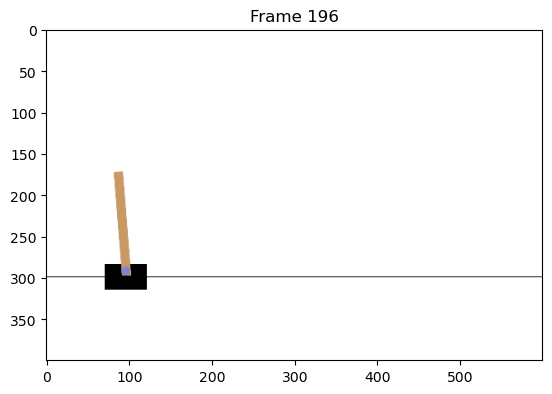

[-1.6264911  -0.6796314  -0.07823268 -0.27637893] [-1.6400838  -0.8735551  -0.08376026 -0.00936002] 0
New state:  [-1.6400838  -0.8735551  -0.08376026 -0.00936002] Reward:  1.0 Terminated:  False Truncated:  False


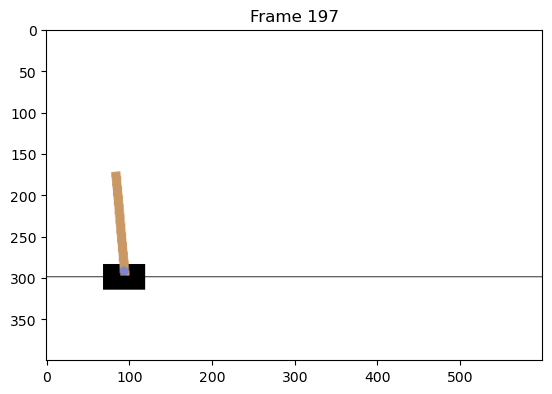

[-1.6400838  -0.8735551  -0.08376026 -0.00936002] [-1.6575549  -0.67733806 -0.08394746 -0.32725054] 1
New state:  [-1.6575549  -0.67733806 -0.08394746 -0.32725054] Reward:  1.0 Terminated:  False Truncated:  False


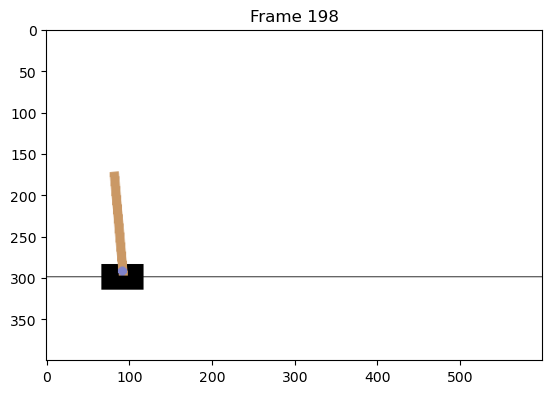

[-1.6575549  -0.67733806 -0.08394746 -0.32725054] [-1.6711016  -0.87117076 -0.09049247 -0.06217691] 0
New state:  [-1.6711016  -0.87117076 -0.09049247 -0.06217691] Reward:  1.0 Terminated:  False Truncated:  False


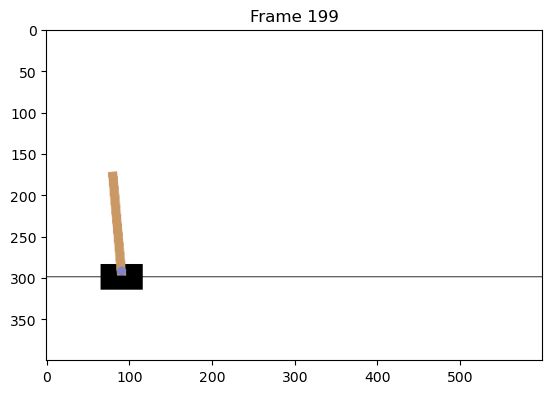

[-1.6711016  -0.87117076 -0.09049247 -0.06217691] [-1.688525   -0.67487574 -0.09173601 -0.3819832 ] 1
New state:  [-1.688525   -0.67487574 -0.09173601 -0.3819832 ] Reward:  1.0 Terminated:  False Truncated:  False


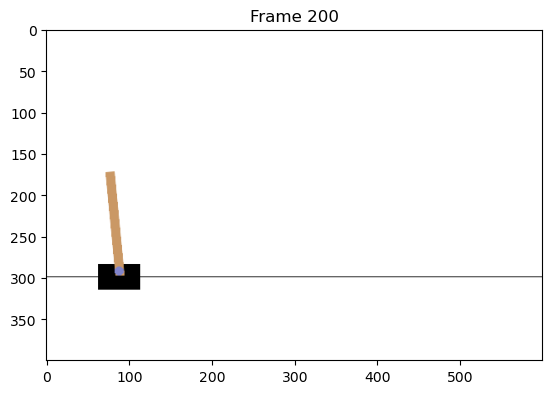

[-1.688525   -0.67487574 -0.09173601 -0.3819832 ] [-1.7020226  -0.8685835  -0.09937568 -0.11957584] 0
New state:  [-1.7020226  -0.8685835  -0.09937568 -0.11957584] Reward:  1.0 Terminated:  False Truncated:  False


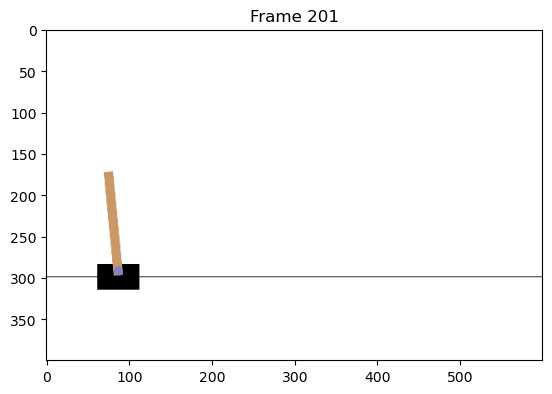

[-1.7020226  -0.8685835  -0.09937568 -0.11957584] [-1.7193942 -1.0621516 -0.1017672  0.1401754] 0
New state:  [-1.7193942 -1.0621516 -0.1017672  0.1401754] Reward:  1.0 Terminated:  False Truncated:  False


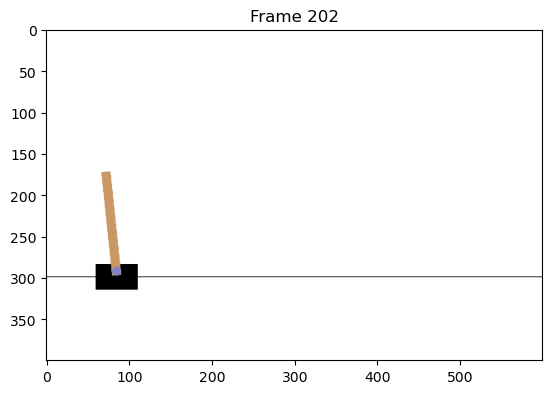

[-1.7193942 -1.0621516 -0.1017672  0.1401754] [-1.7406372  -0.8657305  -0.09896369 -0.18279982] 1
New state:  [-1.7406372  -0.8657305  -0.09896369 -0.18279982] Reward:  1.0 Terminated:  False Truncated:  False


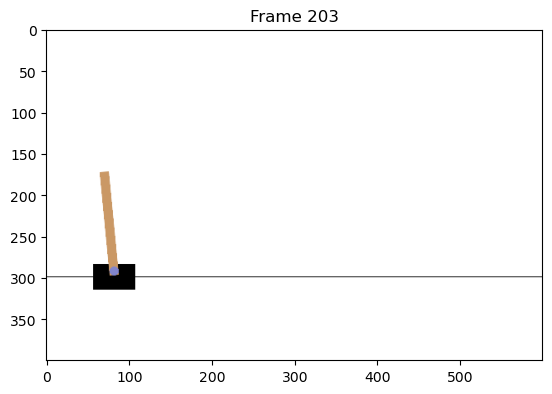

[-1.7406372  -0.8657305  -0.09896369 -0.18279982] [-1.7579519  -1.0593073  -0.10261969  0.07709689] 0
New state:  [-1.7579519  -1.0593073  -0.10261969  0.07709689] Reward:  1.0 Terminated:  False Truncated:  False


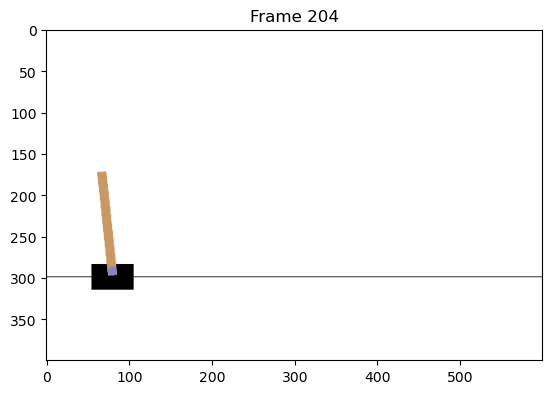

[-1.7579519  -1.0593073  -0.10261969  0.07709689] [-1.779138   -0.86287546 -0.10107774 -0.24611819] 1
New state:  [-1.779138   -0.86287546 -0.10107774 -0.24611819] Reward:  1.0 Terminated:  False Truncated:  False


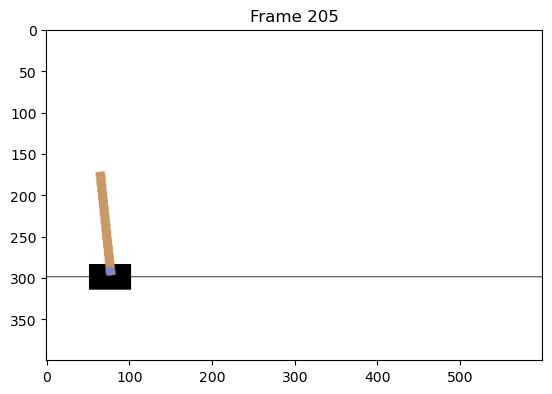

[-1.779138   -0.86287546 -0.10107774 -0.24611819] [-1.7963955  -1.0564194  -0.10600011  0.01304971] 0
New state:  [-1.7963955  -1.0564194  -0.10600011  0.01304971] Reward:  1.0 Terminated:  False Truncated:  False


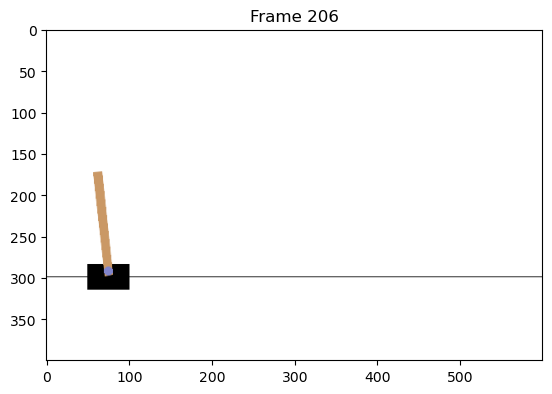

[-1.7963955  -1.0564194  -0.10600011  0.01304971] [-1.8175238  -0.8599496  -0.10573912 -0.31110665] 1
New state:  [-1.8175238  -0.8599496  -0.10573912 -0.31110665] Reward:  1.0 Terminated:  False Truncated:  False


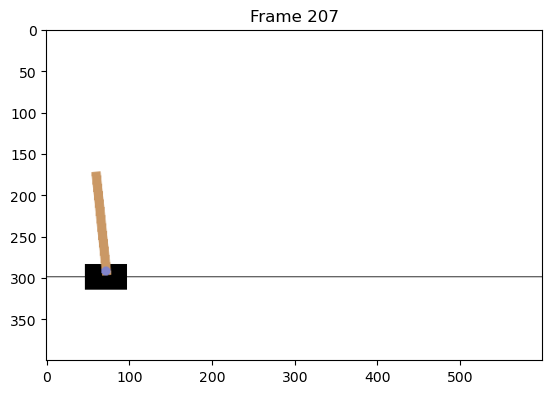

[-1.8175238  -0.8599496  -0.10573912 -0.31110665] [-1.8347229  -1.0534186  -0.11196125 -0.05355332] 0
New state:  [-1.8347229  -1.0534186  -0.11196125 -0.05355332] Reward:  1.0 Terminated:  False Truncated:  False


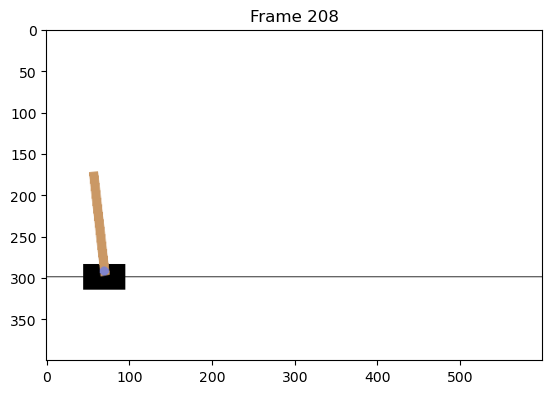

[-1.8347229  -1.0534186  -0.11196125 -0.05355332] [-1.8557912  -1.2467719  -0.11303231  0.20181292] 0
New state:  [-1.8557912  -1.2467719  -0.11303231  0.20181292] Reward:  1.0 Terminated:  False Truncated:  False


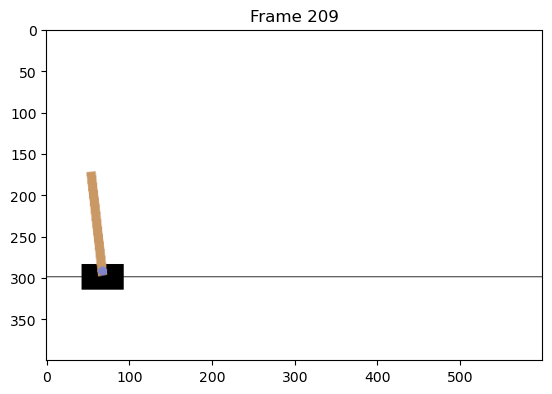

[-1.8557912  -1.2467719  -0.11303231  0.20181292] [-1.8807267  -1.0502301  -0.10899606 -0.12427925] 1
New state:  [-1.8807267  -1.0502301  -0.10899606 -0.12427925] Reward:  1.0 Terminated:  False Truncated:  False


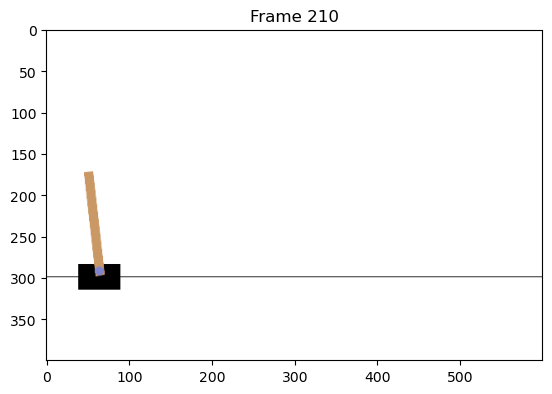

[-1.8807267  -1.0502301  -0.10899606 -0.12427925] [-1.9017313  -1.2436355  -0.11148164  0.13212575] 0
New state:  [-1.9017313  -1.2436355  -0.11148164  0.13212575] Reward:  1.0 Terminated:  False Truncated:  False


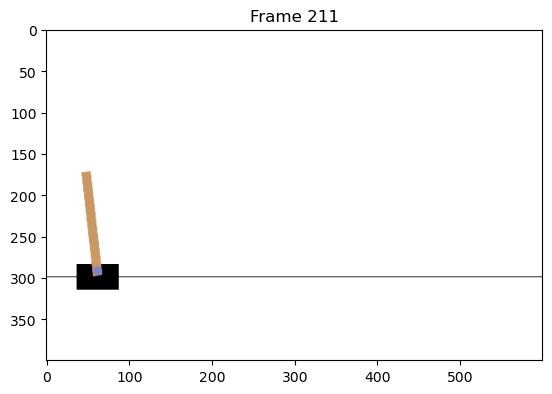

[-1.9017313  -1.2436355  -0.11148164  0.13212575] [-1.926604   -1.0471078  -0.10883912 -0.19354355] 1
New state:  [-1.926604   -1.0471078  -0.10883912 -0.19354355] Reward:  1.0 Terminated:  False Truncated:  False


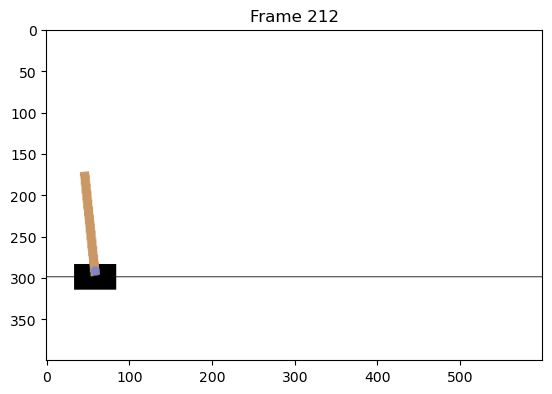

[-1.926604   -1.0471078  -0.10883912 -0.19354355] [-1.9475461  -1.2405181  -0.11271     0.06291972] 0
New state:  [-1.9475461  -1.2405181  -0.11271     0.06291972] Reward:  1.0 Terminated:  False Truncated:  False


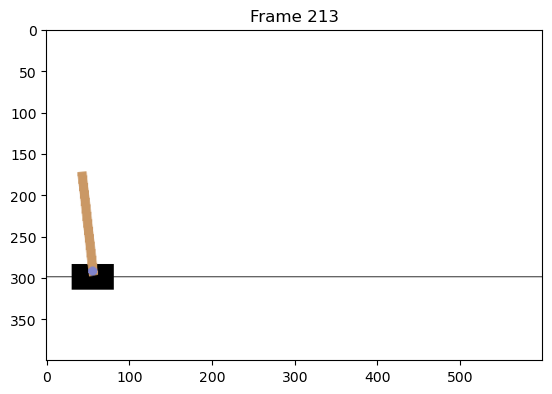

[-1.9475461  -1.2405181  -0.11271     0.06291972] [-1.9723566  -1.0439758  -0.1114516  -0.26308987] 1
New state:  [-1.9723566  -1.0439758  -0.1114516  -0.26308987] Reward:  1.0 Terminated:  False Truncated:  False


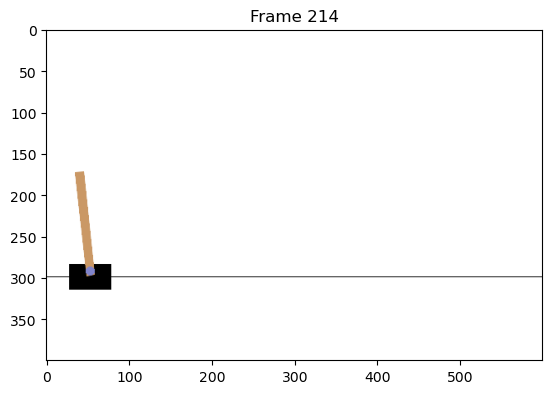

[-1.9723566  -1.0439758  -0.1114516  -0.26308987] [-1.9932361  -1.237345   -0.1167134  -0.00753452] 0
New state:  [-1.9932361  -1.237345   -0.1167134  -0.00753452] Reward:  1.0 Terminated:  False Truncated:  False


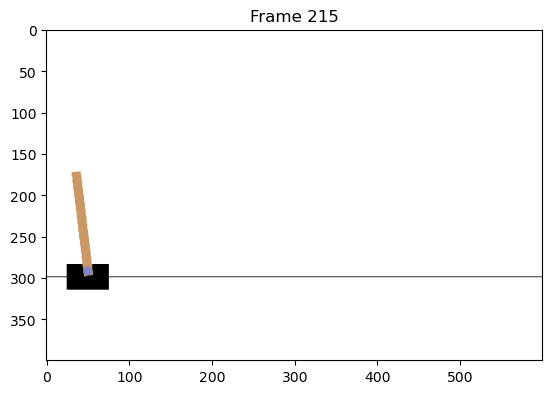

[-1.9932361  -1.237345   -0.1167134  -0.00753452] [-2.017983   -1.0407594  -0.11686409 -0.33464262] 1
New state:  [-2.017983   -1.0407594  -0.11686409 -0.33464262] Reward:  1.0 Terminated:  False Truncated:  False


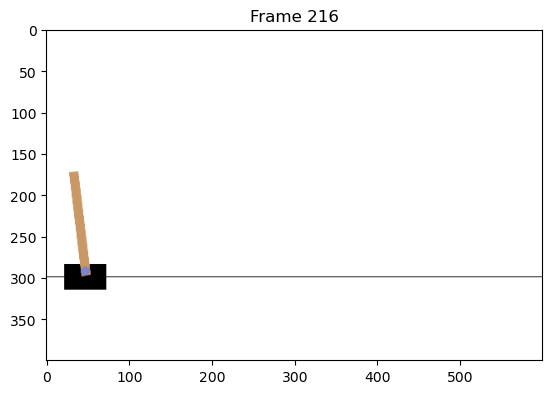

[-2.017983   -1.0407594  -0.11686409 -0.33464262] [-2.038798   -1.2340411  -0.12355694 -0.08097757] 0
New state:  [-2.038798   -1.2340411  -0.12355694 -0.08097757] Reward:  1.0 Terminated:  False Truncated:  False


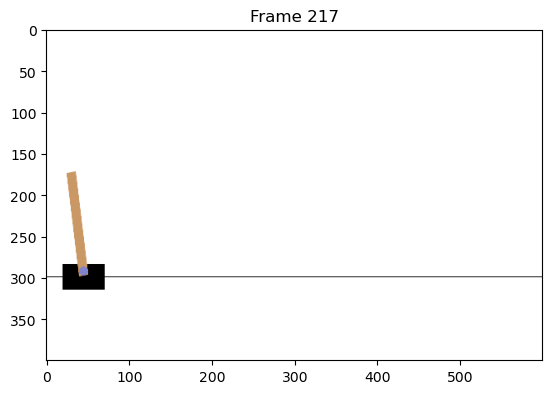

[-2.038798   -1.2340411  -0.12355694 -0.08097757] [-2.063479   -1.4271952  -0.12517649  0.17031139] 0
New state:  [-2.063479   -1.4271952  -0.12517649  0.17031139] Reward:  1.0 Terminated:  False Truncated:  False


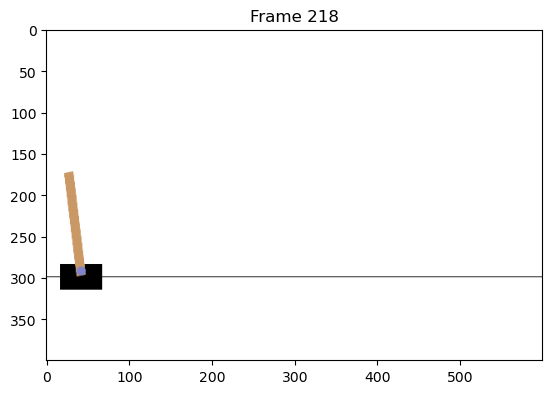

[-2.063479   -1.4271952  -0.12517649  0.17031139] [-2.092023   -1.2305245  -0.12177026 -0.15909217] 1
New state:  [-2.092023   -1.2305245  -0.12177026 -0.15909217] Reward:  1.0 Terminated:  False Truncated:  False


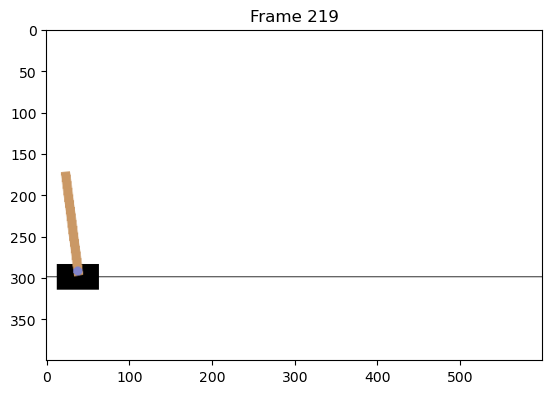

[-2.092023   -1.2305245  -0.12177026 -0.15909217] [-2.1166334  -1.4237118  -0.12495211  0.09283084] 0
New state:  [-2.1166334  -1.4237118  -0.12495211  0.09283084] Reward:  1.0 Terminated:  False Truncated:  False


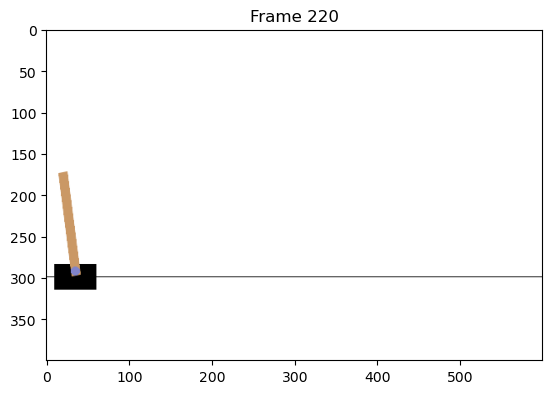

[-2.1166334  -1.4237118  -0.12495211  0.09283084] [-2.1451075  -1.227041   -0.12309549 -0.23651578] 1
New state:  [-2.1451075  -1.227041   -0.12309549 -0.23651578] Reward:  1.0 Terminated:  False Truncated:  False


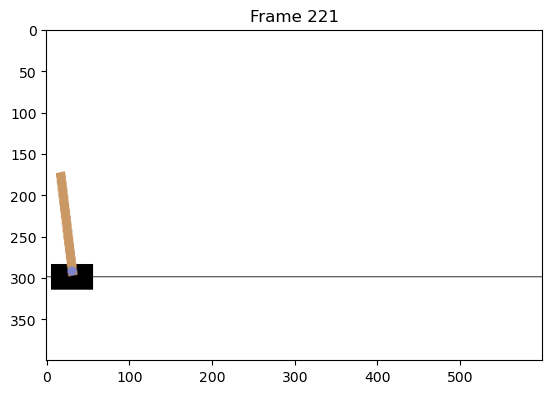

[-2.1451075  -1.227041   -0.12309549 -0.23651578] [-2.1696484  -1.4202089  -0.12782581  0.01494497] 0
New state:  [-2.1696484  -1.4202089  -0.12782581  0.01494497] Reward:  1.0 Terminated:  False Truncated:  False


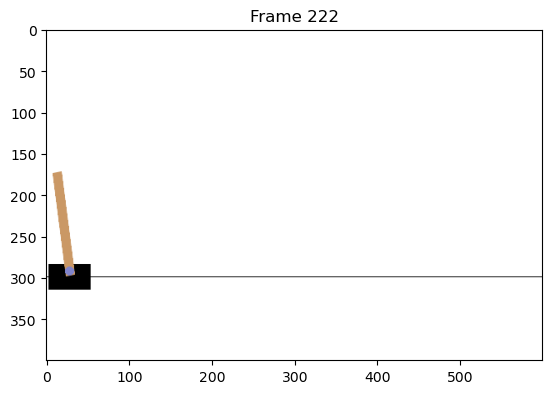

[-2.1696484  -1.4202089  -0.12782581  0.01494497] [-2.1980526  -1.2235076  -0.12752691 -0.31517836] 1
New state:  [-2.1980526  -1.2235076  -0.12752691 -0.31517836] Reward:  1.0 Terminated:  False Truncated:  False


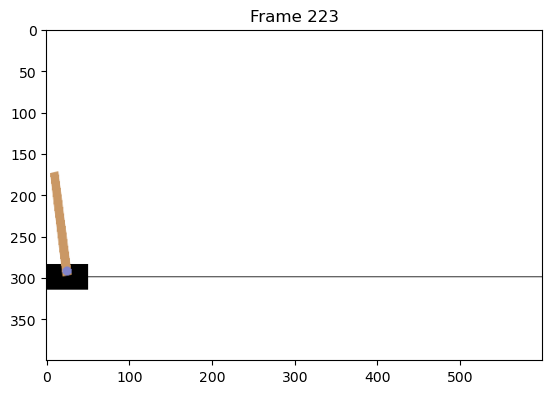

[-2.1980526  -1.2235076  -0.12752691 -0.31517836] [-2.2225227  -1.4166042  -0.13383047 -0.06527692] 0
New state:  [-2.2225227  -1.4166042  -0.13383047 -0.06527692] Reward:  1.0 Terminated:  False Truncated:  False


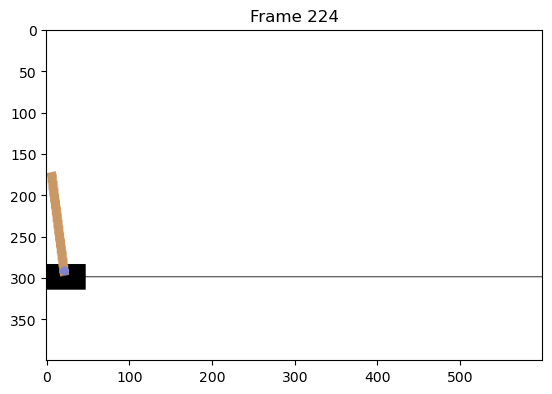

[-2.2225227  -1.4166042  -0.13383047 -0.06527692] [-2.2508547  -1.6095788  -0.13513601  0.18236785] 0
New state:  [-2.2508547  -1.6095788  -0.13513601  0.18236785] Reward:  1.0 Terminated:  False Truncated:  False


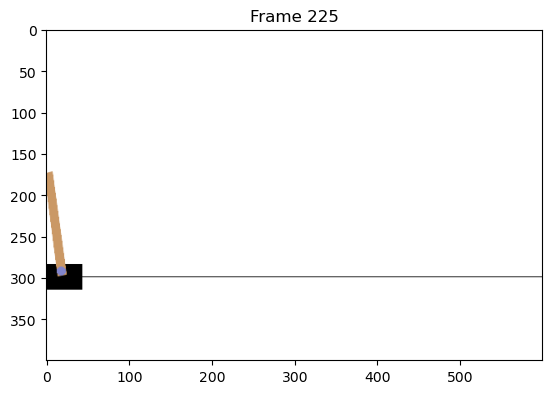

[-2.2508547  -1.6095788  -0.13513601  0.18236785] [-2.2830465  -1.4128081  -0.13148865 -0.14970657] 1
New state:  [-2.2830465  -1.4128081  -0.13148865 -0.14970657] Reward:  1.0 Terminated:  False Truncated:  False


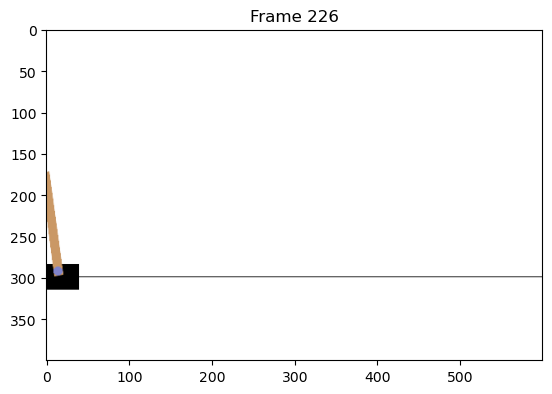

[-2.2830465  -1.4128081  -0.13148865 -0.14970657] [-2.3113027  -1.605826   -0.13448279  0.09877475] 0
New state:  [-2.3113027  -1.605826   -0.13448279  0.09877475] Reward:  1.0 Terminated:  False Truncated:  False


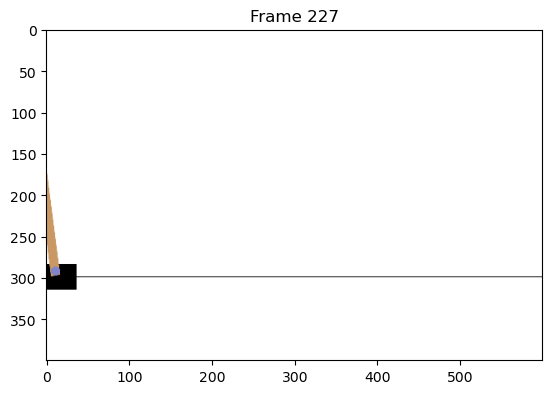

[-2.3113027  -1.605826   -0.13448279  0.09877475] [-2.343419   -1.4090587  -0.1325073  -0.23313019] 1
New state:  [-2.343419   -1.4090587  -0.1325073  -0.23313019] Reward:  1.0 Terminated:  False Truncated:  False


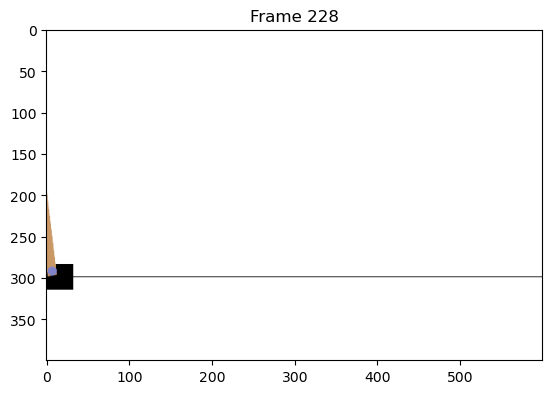

[-2.343419   -1.4090587  -0.1325073  -0.23313019] [-2.3716002  -1.602063   -0.1371699   0.01499508] 0
New state:  [-2.3716002  -1.602063   -0.1371699   0.01499508] Reward:  1.0 Terminated:  False Truncated:  False


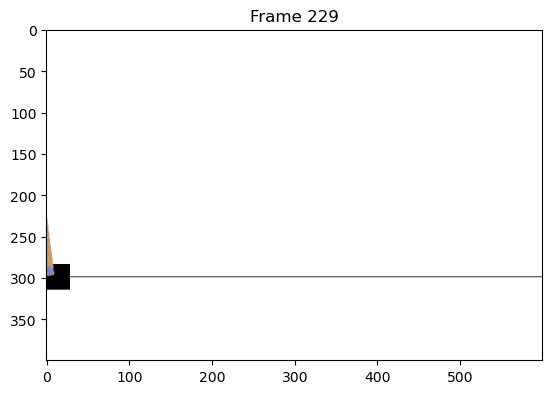

[-2.3716002  -1.602063   -0.1371699   0.01499508] [-2.4036415 -1.4052676 -0.13687   -0.3176267] 1
New state:  [-2.4036415 -1.4052676 -0.13687   -0.3176267] Reward:  1.0 Terminated:  True Truncated:  False


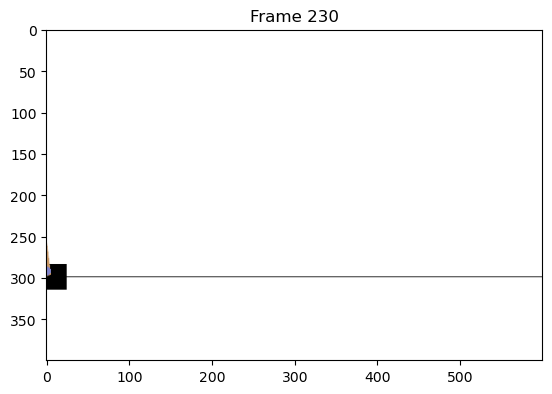

In [52]:
import matplotlib.pyplot as plt

from IPython.display import clear_output
from time import sleep

env=gym.make("CartPole-v1",render_mode="rgb_array")

state_dim = 4
action_dim = env.action_space.n

class ActorPredNwk(nn.Module):
    def __init__(self,input_dim,out_dim,
                 hidden1_dim=256,
                 hidden2_dim=256,
                 checkpoint_file = 'tmp/actor'
                 ):
        super(ActorPredNwk, self).__init__()

        self.checkpoint_file = checkpoint_file
        self.actor_nwk = nn.Sequential(
            nn.Linear(input_dim,hidden1_dim),
            nn.ReLU(),
            nn.Linear(hidden1_dim,hidden2_dim),
            nn.ReLU(),
            nn.Linear(hidden2_dim,out_dim),  
            nn.Softmax(dim=-1)
        )

    def forward(self,state):
        x = torch.Tensor(state)
        out = self.actor_nwk(x)
        return out
    
    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

    
policy_nwk = ActorPredNwk(input_dim=state_dim,out_dim=action_dim)
policy_nwk.load_checkpoint()

current_state,info = env.reset()

terminated,truncated = False,False
i = 1
while not (terminated or truncated): 
    
    action = policy_nwk(current_state)
    action = torch.argmax(action).item()
    new_state,reward,terminated,truncated,info = env.step(action)
    print(current_state,new_state,action)
    print('New state: ', new_state,'Reward: ',reward,'Terminated: ',terminated,'Truncated: ',truncated) 
    current_state = new_state 
    plt.title(f'Frame {i}')
    i += 1
    plt.imshow(env.render())
    plt.show()
   
   
